In [1]:
cd ..

m:\OneDrive\Projects\federated_imputation_pc1


## Loading

In [28]:
%load_ext autoreload
%autoreload
import copy
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from src.modules.data_spliting import split_train_test
from src.modules.data_preprocessing import load_data
import random
from src.modules.data_partition import data_partition
from src.fed_imp.sub_modules.missing_simulate.missing_adder_new import add_missing
from src.fed_imp.sub_modules.client.client_factory import ClientsFactory
from src.fed_imp.sub_modules.strategy.strategy_imp import StrategyImputation
from src.fed_imp.sub_modules.server.load_server import load_server
from src.fed_imp.sub_modules.client.simple_client import SimpleClient
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from dython.nominal import correlation_ratio
import missingno as msno
from src.fed_imp.sub_modules.missing_simulate.missing_adder_new import simulate_nan_new
from src.modules.evaluation.imputation_quality import rmse, ws_cols, sliced_ws


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [26]:
def visualize_ms(clients_ms_datas:list, sort_patterns: bool = False):
    n_cols = 5
    n_clients = len(clients_ms_datas)
    n_rows = (n_clients + 4)//n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*4, n_rows*3), squeeze=False)
    for i in range(n_clients):
        ax = axes[i//n_cols, i%n_cols]
        d = pd.DataFrame(clients_ms_datas[i])
        d = d.sort_values(by=d.columns[-1])
        if sort_patterns:
            msno.matrix(d, ax=ax, sparkline=False, sort='ascending')
        else:
            msno.matrix(d, ax=ax, sparkline=False)
        ax.set_title('Client {}'.format(i))
    plt.tight_layout()

def correlation(original_data, centralized_data):
    original_df = pd.DataFrame(original_data)
    target_col = original_df.columns[-1]
    correlation_ret = original_df.corrwith(original_df[target_col], method=correlation_ratio).sort_values(ascending=False)
    print(correlation_ret)

    centralized_df = pd.DataFrame(centralized_data)
    target_col = centralized_df.columns[-1]
    correlation_ret = centralized_df.corrwith(original_df[target_col], method=correlation_ratio).sort_values(ascending=False)
    print(correlation_ret)

def run_pred(clf_name, X_train, y_train, X_test, y_test):
    accus = []
    for i in range(5):
        seed = 21 + i*93940
        if clf_name == 'LR':
            clf = LogisticRegression(random_state=seed, max_iter=1000)
        elif clf_name == 'MLP':
            clf = MLPClassifier(
                [32, 32], batch_size = 128, random_state=seed, alpha = 0.001, max_iter = 1000)
        else:
            raise ValueError('clf_name should be LR or MLP')
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        accus.append(metrics.accuracy_score(y_test, y_pred))
    return np.mean(accus), np.std(accus)

def sklearn_evaluation(rets):

    original_data = rets['data']['origin_data'].reshape(-1, rets['data']['origin_data'].shape[-1])
    centralized_data = rets['data']['imputed_data'].reshape(-1, rets['data']['origin_data'].shape[-1])
    test_data = rets['data']['test_data']

    X_train = centralized_data[:, :-1]
    y_train = centralized_data[:, -1]
    X_test = test_data[:, :-1]
    y_test = test_data[:, -1]
    accu, std = run_pred('MLP', X_train, y_train, X_test, y_test)
    print("Accuracy imputed centralized MLP:{:.4f} ({:.3f})".format(accu, std))

    accu, std = run_pred('LR', X_train, y_train, X_test, y_test)
    print("Accuracy imputed centralized LR:{:.4f} ({:.3f})".format(accu, std))

    # X_train = original_data[:, :-1]
    # y_train = original_data[:, -1]
    # X_test = test_data[:, :-1]
    # y_test = test_data[:, -1]
    # accu, std = run_pred('MLP', X_train, y_train, X_test, y_test)
    # print("Accuracy orignal centralized MLP:{:.4f} ({:.3f})".format(accu, std))

    # accu, std = run_pred('LR', X_train, y_train, X_test, y_test)
    # print("Accuracy orignal centralized MLP:{:.4f} ({:.3f})".format(accu, std))


def vis_imp(ret):
    x = list(range(len(ret['client_imp_history'])))
    client_ids = list(ret['client_imp_history'][0][2]['metrics'].keys())

    fig, ax = plt.subplots(1, 3, figsize=(15, 4))
    for client_id in client_ids:
        for idx, metric in enumerate(['imp@rmse', 'imp@w2', 'imp@sliced_ws']):
            y = [ret['client_imp_history'][i][2]['metrics'][client_id][metric] for i in x]
            ax[idx].plot(x, y, label=client_id)
            ax[idx].set_title(metric)
    plt.show()

In [5]:
experiment_config_template = {
  "num_clients": 20,
  "data": {
    "dataset_name": "ijcnn_balanced_pca",
    "normalize": True
  },
  "data_partition": {
    "strategy": "sample@p=0.01",
    "params": {}
  },
  "missing_simulate": {
    "mr_strategy": "fixed",
    "mf_strategy": "all",
    "mm_strategy": "mary_lr"
  },
  "imputation": {
    "initial_strategy_num": "mean",
    "initial_strategy_cat": "mode",
    "estimator_num": "ridge_cv",
    "estimator_cat": "logistic_cv",
    "imp_evaluation_model": "logistic",
    "imp_evaluation_params": {
      "tune_params": "gridsearch"
    },
    "clip": False
  },
  "agg_strategy_imp": {
    "strategy": "fedavg-s",
    "params": {
      "ms_field": "missing_cell_pct",
      "beta": 0.7
    }
  },
  "server_type": "fedavg_pytorch",
  "server": {
    "impute_mode": "instant",
    "imp_round": 20,
    "imp_local_epochs": 0,
    "pred_round": 0,
    "pred_local_epochs": 0,
    "model_fit_mode": "one_shot"
  },
  "pred_model": {
    "model_params": {
      "model": "2nn",
      "num_hiddens": 128,
      "model_init_config": None,
      "model_other_params": None
    },
    "train_params": {
      "batch_size": 128,
      "learning_rate": 0.001,
      "weight_decay": 0.0001,
      "pred_round": 200,
      "pred_local_epochs": 3
    }
  },
  "experiment": {
    "n_rounds": 1,
    "seed": 102931466,
    "mtp": False,
    "random_seed": 50,
    "num_process": 3,
    "test_size": 0.1,
    "track": True
  },
  "tune_params": False,
  "track": False,
  "tune_params": True,
  "prediction": False,
  "save_state": False,
  "test_size": 0.1,
  "algo_params": {
    "local": {},
    "fedavg-s": {},
    "fedwavg": {
      "alpha": 0.9
    },
    "fedmechw": {
      "client_thres": 1.0,
      "alpha": 0.8,
      "beta": 0.15
    },
    "fedmechclw": {
      "client_thres": 0.2,
      "thres1": 0.2,
      "alpha": 0.5
    },
    'testavg':{
        
    },
    'testavg2':{
        
    },
    'testavg3':{
        
    },
    "scale_factor": 4
  }
}

In [6]:
server_config_tmpl = {
    "server_name": 'fedavg_mlp_pytorch_pred',
    "server_pred_config": {
        "model_params": {
            "model": "2nn",
            "num_hiddens": 32,
            "model_init_config": None,
            "model_other_params": None
        },
        "train_params": {
            "batch_size": 128,
            "learning_rate": 0.001,
            "weight_decay": 0.001,
            "pred_round": 1000,
            "pred_local_epochs": 5,
            'local_epoch': 5,
            'sample_pct': 1
        }
    },
    "server_config": {
        'pred_rounds': 1,
        'seed': 21
    }
}

In [29]:
def NN_evaluation(ret0, type='centralized', n_rounds = 500):
    clients_ = {}
    data_imp = ret0['data']['imputed_data']
    missing_mask = ret0['data']['missing_mask']
    data_true = ret0['data']['origin_data']
    n_clients = ret0['data']['origin_data'].shape[0]
    test_data = ret0['data']['test_data']
    for client_id in range(n_clients):
        clients_[client_id] = SimpleClient(
            client_id=client_id,
            data_imp=data_imp[client_id],
            missing_mask=missing_mask[client_id],
            data_true=data_true[client_id],
            data_test=test_data
        )

    pred_config = server_config_tmpl.copy()
    if type == 'centralized':
        server_name = 'central_mlp_pytorch_pred'
    elif type == 'fedavg':
        server_name = 'fedavg_mlp_pytorch_pred_local'
    else:
        raise ValueError('type should be centralized or fedavg')
    server_pred_config = pred_config['server_pred_config']
    server_pred_config['train_params']['pred_round'] = n_rounds
    server_config = pred_config['server_config']
    server_ = load_server(
            server_name, clients=clients_, server_config=server_config, pred_config=server_pred_config,
            test_data=test_data
        )

    pred_ret2 = server_.prediction()
    print(pred_ret2["accu_mean"])
    return pred_ret2

In [22]:
trackers = {}
rets ={}

## MARY LR 20:0

### Local

sample {'p': '280'}
0.010859026565832848 25785
['mary_sigmoid_left' 'mary_sigmoid_left' 'mary_sigmoid_left'
 'mary_sigmoid_left' 'mary_sigmoid_left' 'mary_sigmoid_left'
 'mary_sigmoid_left' 'mary_sigmoid_left' 'mary_sigmoid_left'
 'mary_sigmoid_left' 'mary_sigmoid_left' 'mary_sigmoid_left'
 'mary_sigmoid_left' 'mary_sigmoid_left' 'mary_sigmoid_left'
 'mary_sigmoid_left' 'mary_sigmoid_left' 'mary_sigmoid_left'
 'mary_sigmoid_left' 'mary_sigmoid_left']


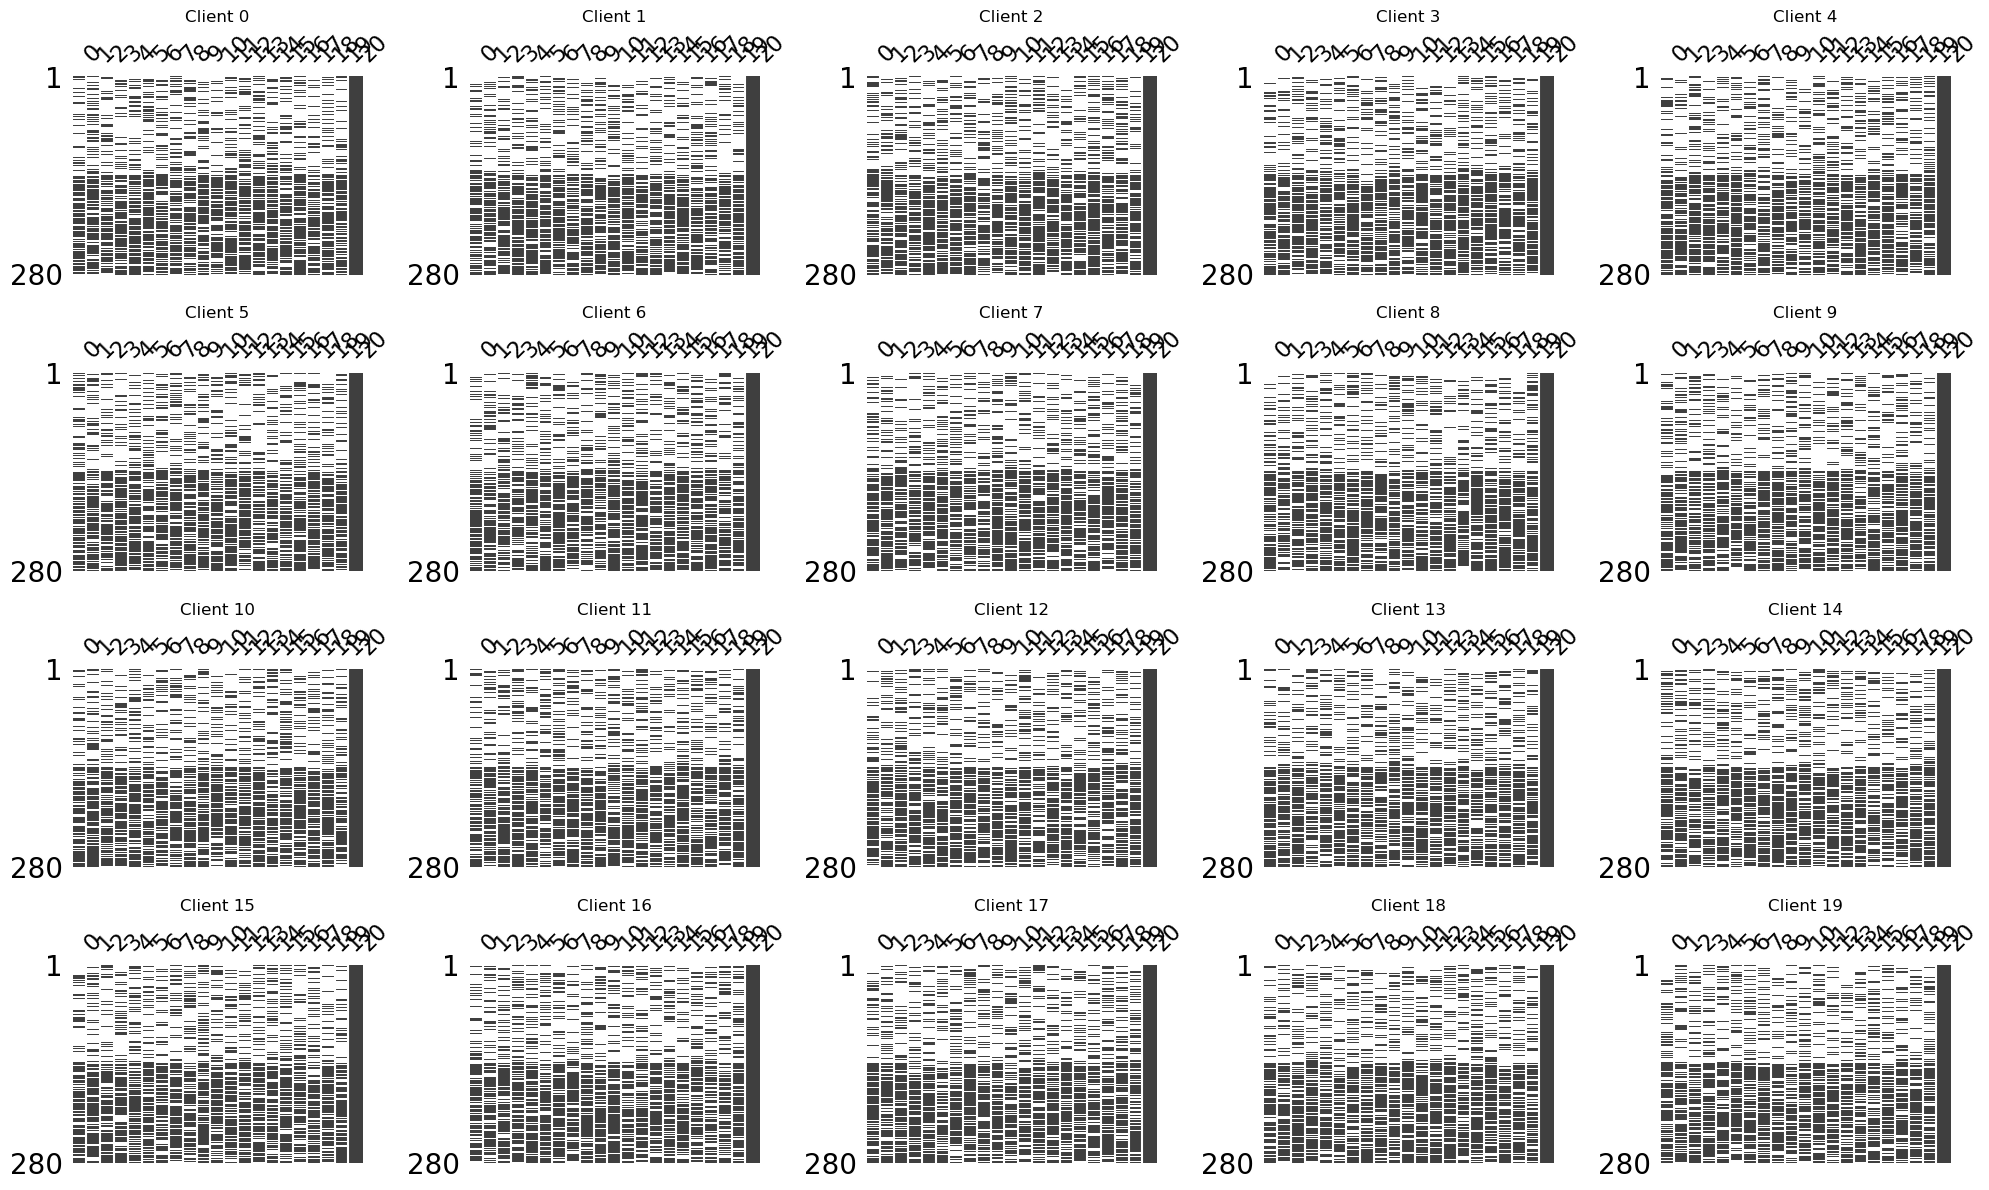

In [92]:
config2 = experiment_config_template.copy()
config2['data']['dataset_name'] = 'ijcnn_balanced_pca'
config2['num_clients'] = 20
config2['missing_simulate']['mr_strategy'] = 'fixed@mr=0.5'
config2['missing_simulate']['mf_strategy'] = 'all'
config2['missing_simulate']['mm_strategy'] = 'mary_sigmoid_lr@sp=extreme_r=1.0'
config2['data_partition']['strategy'] = 'sample@p=280'
config2['agg_strategy_imp']['strategy'] = 'fedavg-s'

configuration = config2
num_clients = configuration['num_clients']
# set random seed
seed = configuration['experiment']['seed']
mtp = configuration['experiment']['mtp']
tune_params = configuration['tune_params']
random.seed(seed)  # seed for split data

# load data
dataset_params = configuration['data']
data, data_config = load_data(**dataset_params)
regression = data_config['task_type'] == 'regression'

n_rounds = configuration['experiment']['n_rounds']
test_size = configuration['experiment'].get('test_size', 0.1)
if n_rounds == 1:
    n_rounds_data = split_train_test(data, n_folds=2, seed=seed, test_size=test_size, regression=regression)
else:
    n_rounds_data = split_train_test(
        data, n_folds=n_rounds, seed=seed, test_size=test_size, regression=regression
        )

# n rounds average
train_data, test_data = n_rounds_data[0]

new_seed = (seed + 10087 * 0) % (2 ^ 23)
regression = data_config['task_type'] == 'regression'
data_partition_params = configuration['data_partition']
data_partitions = data_partition(
    **data_partition_params, data=train_data.values, n_clients=num_clients, seed=new_seed,
    regression=regression
)
missing_params = configuration['missing_simulate']
cols = np.arange(0, train_data.shape[1] - 1)
scenario = missing_params
data_ms_clients2 = add_missing(
    train_data_list=data_partitions, scenario=scenario, cols=cols, seed=new_seed
)

client_factory = ClientsFactory(debug=False)
clients = client_factory.generate_clients(
    num_clients, data_partitions, data_ms_clients2, test_data.values, data_config,
    configuration['imputation'], seed=new_seed
)
visualize_ms(data_ms_clients2)

2023-07-21 10:26:53.909 | INFO     | src.fed_imp.sub_modules.server.base_server:run:155 - FL finished in 121.65824409993365


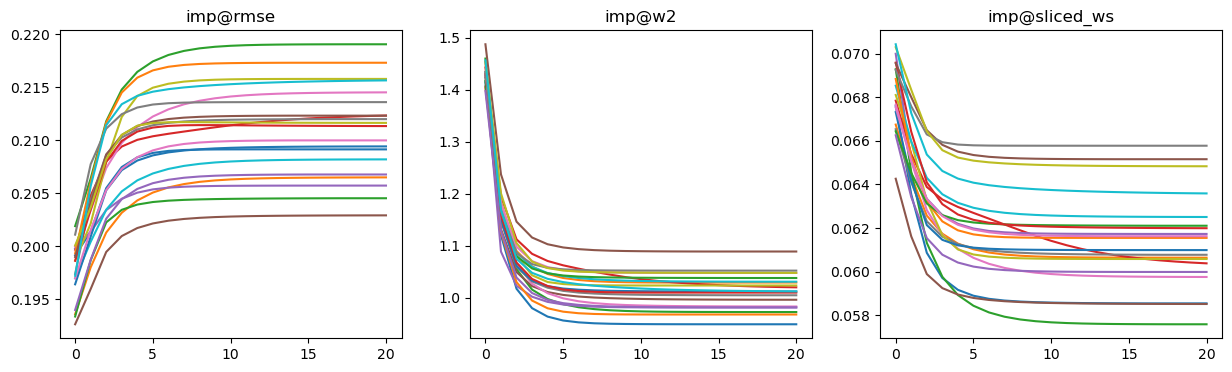

{'imp@rmse': 0.21093843057209277, 'imp@ws': 1.0128029882480358, 'imp@sliced_ws': 0.061437466599834026}
Accuracy imputed centralized MLP:0.5514 (0.010)
Accuracy imputed centralized LR:0.8147 (0.000)


In [93]:
configuration['agg_strategy_imp']['strategy'] = 'local'
configuration['server_type'] = 'fedavg_pytorch'
configuration['prediction'] = False
configuration['save_state'] = True
configuration['track'] = True

# Create Imputation Strategy
imp_strategy = configuration['agg_strategy_imp']['strategy']
params = configuration['algo_params'][imp_strategy]

strategy_imp = StrategyImputation(strategy=imp_strategy, params=params)

# Create Server
server_type = configuration['server_type']
server_config = configuration['server']
server_config["n_cols"] = test_data.shape[1] - 1

pred_config = configuration['pred_model']
pred_config['model_params']['input_feature_dim'] = test_data.shape[1] - 1
pred_config['model_params']['output_classes_dim'] = len(np.unique(test_data.iloc[:, -1].values))

server = load_server(
    server_type,
    clients=clients,
    strategy_imp=strategy_imp,
    server_config=server_config,
    pred_config=pred_config,
    test_data=test_data.values,
    seed=new_seed,
    track=configuration['track'],
    run_prediction=configuration['prediction'],
    persist_data=configuration['save_state'],
)

# return server
ret00 = server.run()
trackers['mary_left_local'] = server.stats_tracker
rets['mary_left_local'] = ret00

vis_imp(ret00)
print(ret00['imp_result'])
sklearn_evaluation(ret00)

### Simple Average

sample {'p': '280'}
0.010859026565832848 25785
['mary_sigmoid_left' 'mary_sigmoid_right' 'mary_sigmoid_right'
 'mary_sigmoid_right' 'mary_sigmoid_right' 'mary_sigmoid_right'
 'mary_sigmoid_right' 'mary_sigmoid_right' 'mary_sigmoid_right'
 'mary_sigmoid_right' 'mary_sigmoid_right' 'mary_sigmoid_right'
 'mary_sigmoid_right' 'mary_sigmoid_right' 'mary_sigmoid_right'
 'mary_sigmoid_right' 'mary_sigmoid_right' 'mary_sigmoid_right'
 'mary_sigmoid_right' 'mary_sigmoid_right']


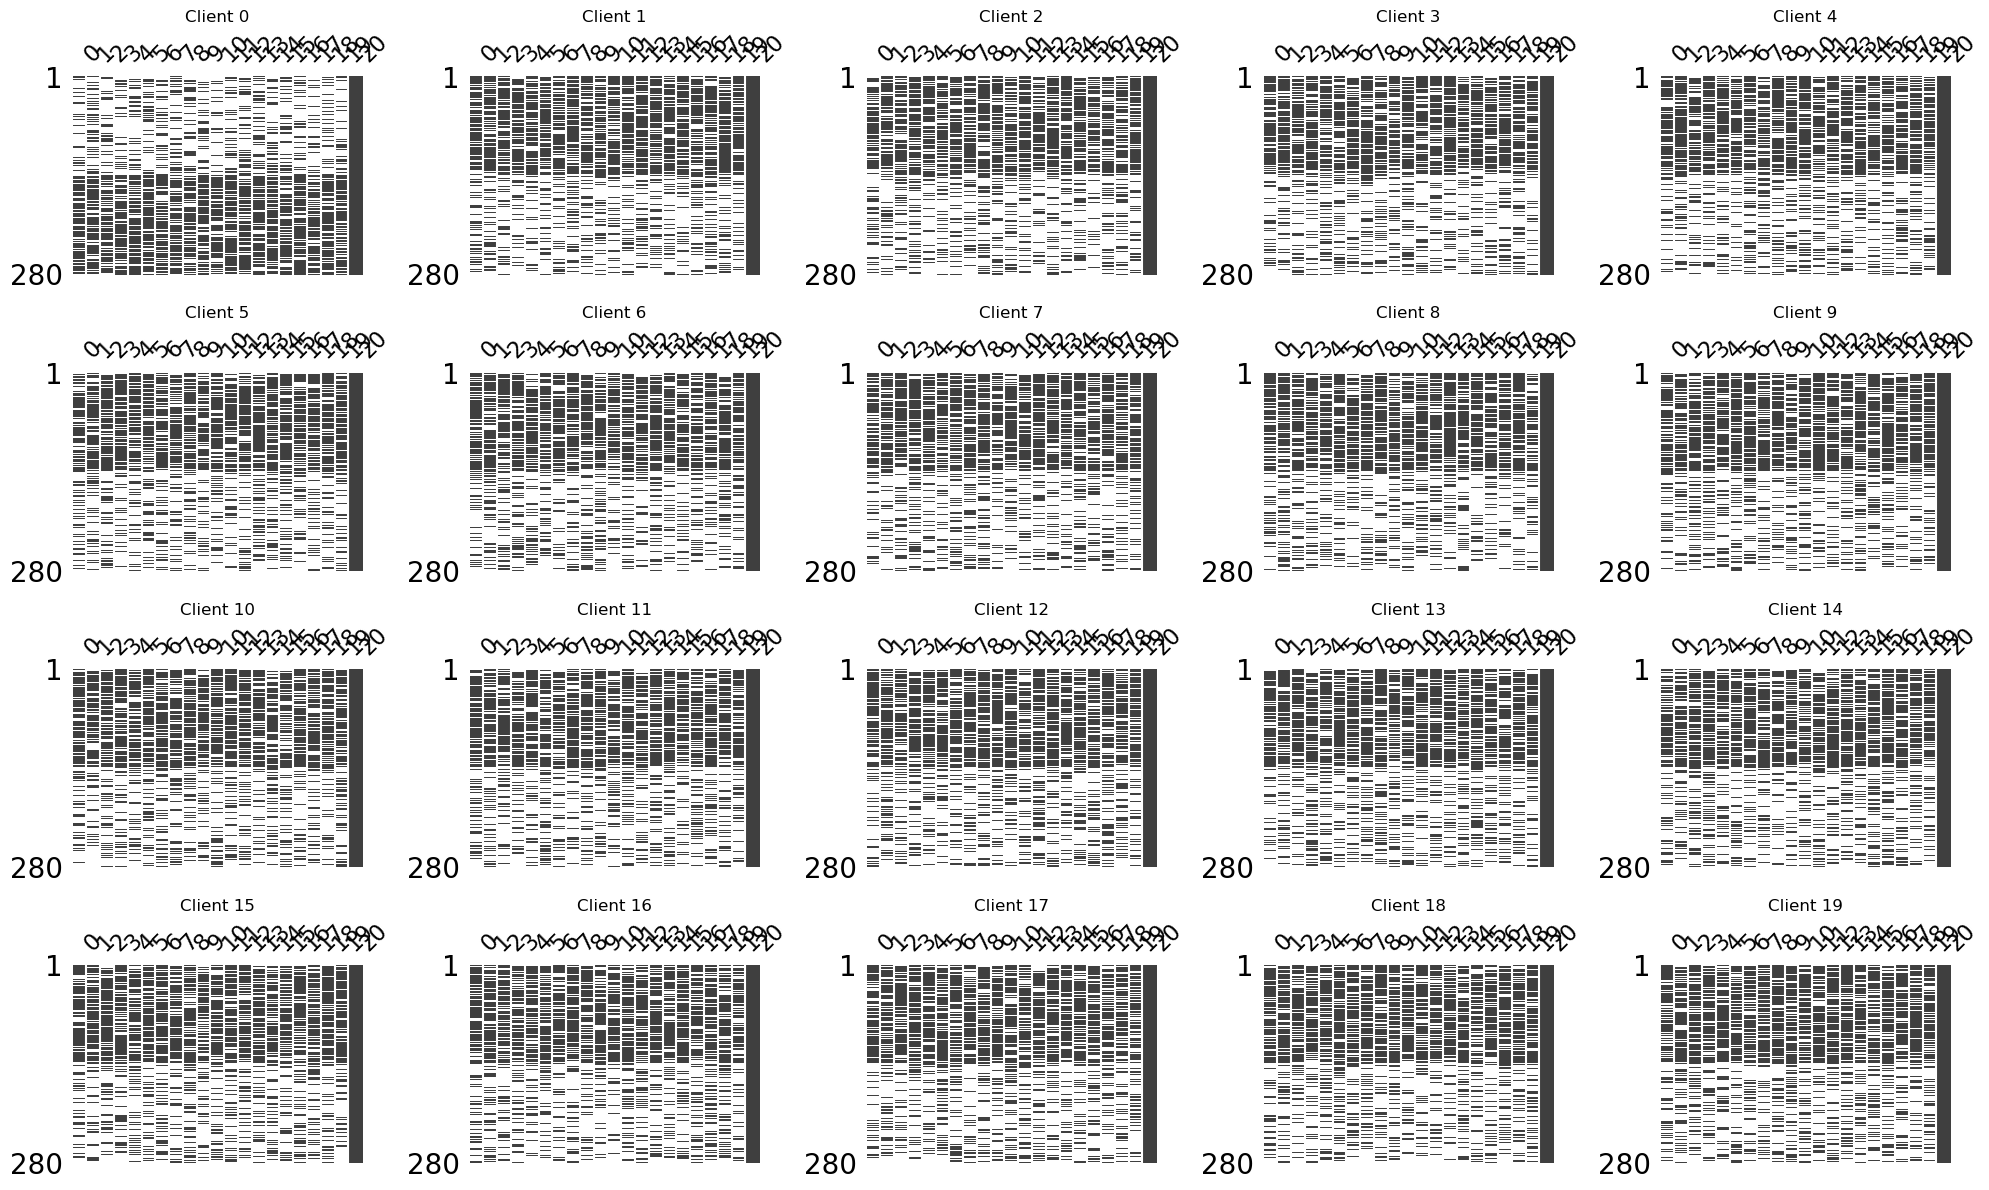

In [52]:
config2 = experiment_config_template.copy()
config2['data']['dataset_name'] = 'ijcnn_balanced_pca'
config2['num_clients'] = 20
config2['missing_simulate']['mr_strategy'] = 'fixed@mr=0.5'
config2['missing_simulate']['mf_strategy'] = 'all'
config2['missing_simulate']['mm_strategy'] = 'mary_sigmoid_lr@sp=extreme_r=1.0'
config2['data_partition']['strategy'] = 'sample@p=280'
config2['agg_strategy_imp']['strategy'] = 'fedavg-s'

configuration = config2
num_clients = configuration['num_clients']
# set random seed
seed = configuration['experiment']['seed']
mtp = configuration['experiment']['mtp']
tune_params = configuration['tune_params']
random.seed(seed)  # seed for split data

# load data
dataset_params = configuration['data']
data, data_config = load_data(**dataset_params)
regression = data_config['task_type'] == 'regression'

n_rounds = configuration['experiment']['n_rounds']
test_size = configuration['experiment'].get('test_size', 0.1)
if n_rounds == 1:
    n_rounds_data = split_train_test(data, n_folds=2, seed=seed, test_size=test_size, regression=regression)
else:
    n_rounds_data = split_train_test(
        data, n_folds=n_rounds, seed=seed, test_size=test_size, regression=regression
        )

# n rounds average
train_data, test_data = n_rounds_data[0]

new_seed = (seed + 10087 * 0) % (2 ^ 23)
regression = data_config['task_type'] == 'regression'
data_partition_params = configuration['data_partition']
data_partitions = data_partition(
    **data_partition_params, data=train_data.values, n_clients=num_clients, seed=new_seed,
    regression=regression
)
missing_params = configuration['missing_simulate']
cols = np.arange(0, train_data.shape[1] - 1)
scenario = missing_params
data_ms_clients2 = add_missing(
    train_data_list=data_partitions, scenario=scenario, cols=cols, seed=new_seed
)

client_factory = ClientsFactory(debug=False)
clients = client_factory.generate_clients(
    num_clients, data_partitions, data_ms_clients2, test_data.values, data_config,
    configuration['imputation'], seed=new_seed
)
visualize_ms(data_ms_clients2)

2023-07-21 09:40:36.324 | INFO     | src.fed_imp.sub_modules.server.base_server:run:155 - FL finished in 111.14772120001726


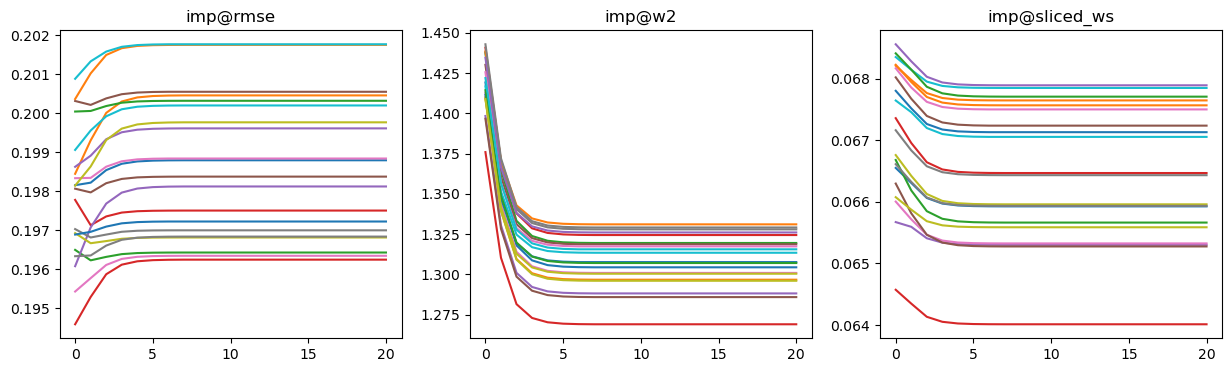

{'imp@rmse': 0.19864963057562046, 'imp@ws': 1.3089092603181873, 'imp@sliced_ws': 0.06647413136811693}
Accuracy imputed centralized MLP:0.5930 (0.016)
Accuracy imputed centralized LR:0.8435 (0.000)


In [53]:
configuration['agg_strategy_imp']['strategy'] = 'fedavg-s'
configuration['server_type'] = 'fedavg_pytorch'
configuration['prediction'] = False
configuration['save_state'] = True
configuration['track'] = True

# Create Imputation Strategy
imp_strategy = configuration['agg_strategy_imp']['strategy']
params = configuration['algo_params'][imp_strategy]

strategy_imp = StrategyImputation(strategy=imp_strategy, params=params)

# Create Server
server_type = configuration['server_type']
server_config = configuration['server']
server_config["n_cols"] = test_data.shape[1] - 1

pred_config = configuration['pred_model']
pred_config['model_params']['input_feature_dim'] = test_data.shape[1] - 1
pred_config['model_params']['output_classes_dim'] = len(np.unique(test_data.iloc[:, -1].values))

server = load_server(
    server_type,
    clients=clients,
    strategy_imp=strategy_imp,
    server_config=server_config,
    pred_config=pred_config,
    test_data=test_data.values,
    seed=new_seed,
    track=configuration['track'],
    run_prediction=configuration['prediction'],
    persist_data=configuration['save_state'],
)

# return server
ret001 = server.run()
trackers['mary_left_simpleavg'] = server.stats_tracker
rets['mary_left_simpleavg'] = ret001

vis_imp(ret001)
print(ret001['imp_result'])
sklearn_evaluation(ret001)

### Our

sample {'p': '280'}
0.010859026565832848 25785
['mary_sigmoid_left' 'mary_sigmoid_right' 'mary_sigmoid_right'
 'mary_sigmoid_right' 'mary_sigmoid_right' 'mary_sigmoid_right'
 'mary_sigmoid_right' 'mary_sigmoid_right' 'mary_sigmoid_right'
 'mary_sigmoid_right' 'mary_sigmoid_right' 'mary_sigmoid_right'
 'mary_sigmoid_right' 'mary_sigmoid_right' 'mary_sigmoid_right'
 'mary_sigmoid_right' 'mary_sigmoid_right' 'mary_sigmoid_right'
 'mary_sigmoid_right' 'mary_sigmoid_right']


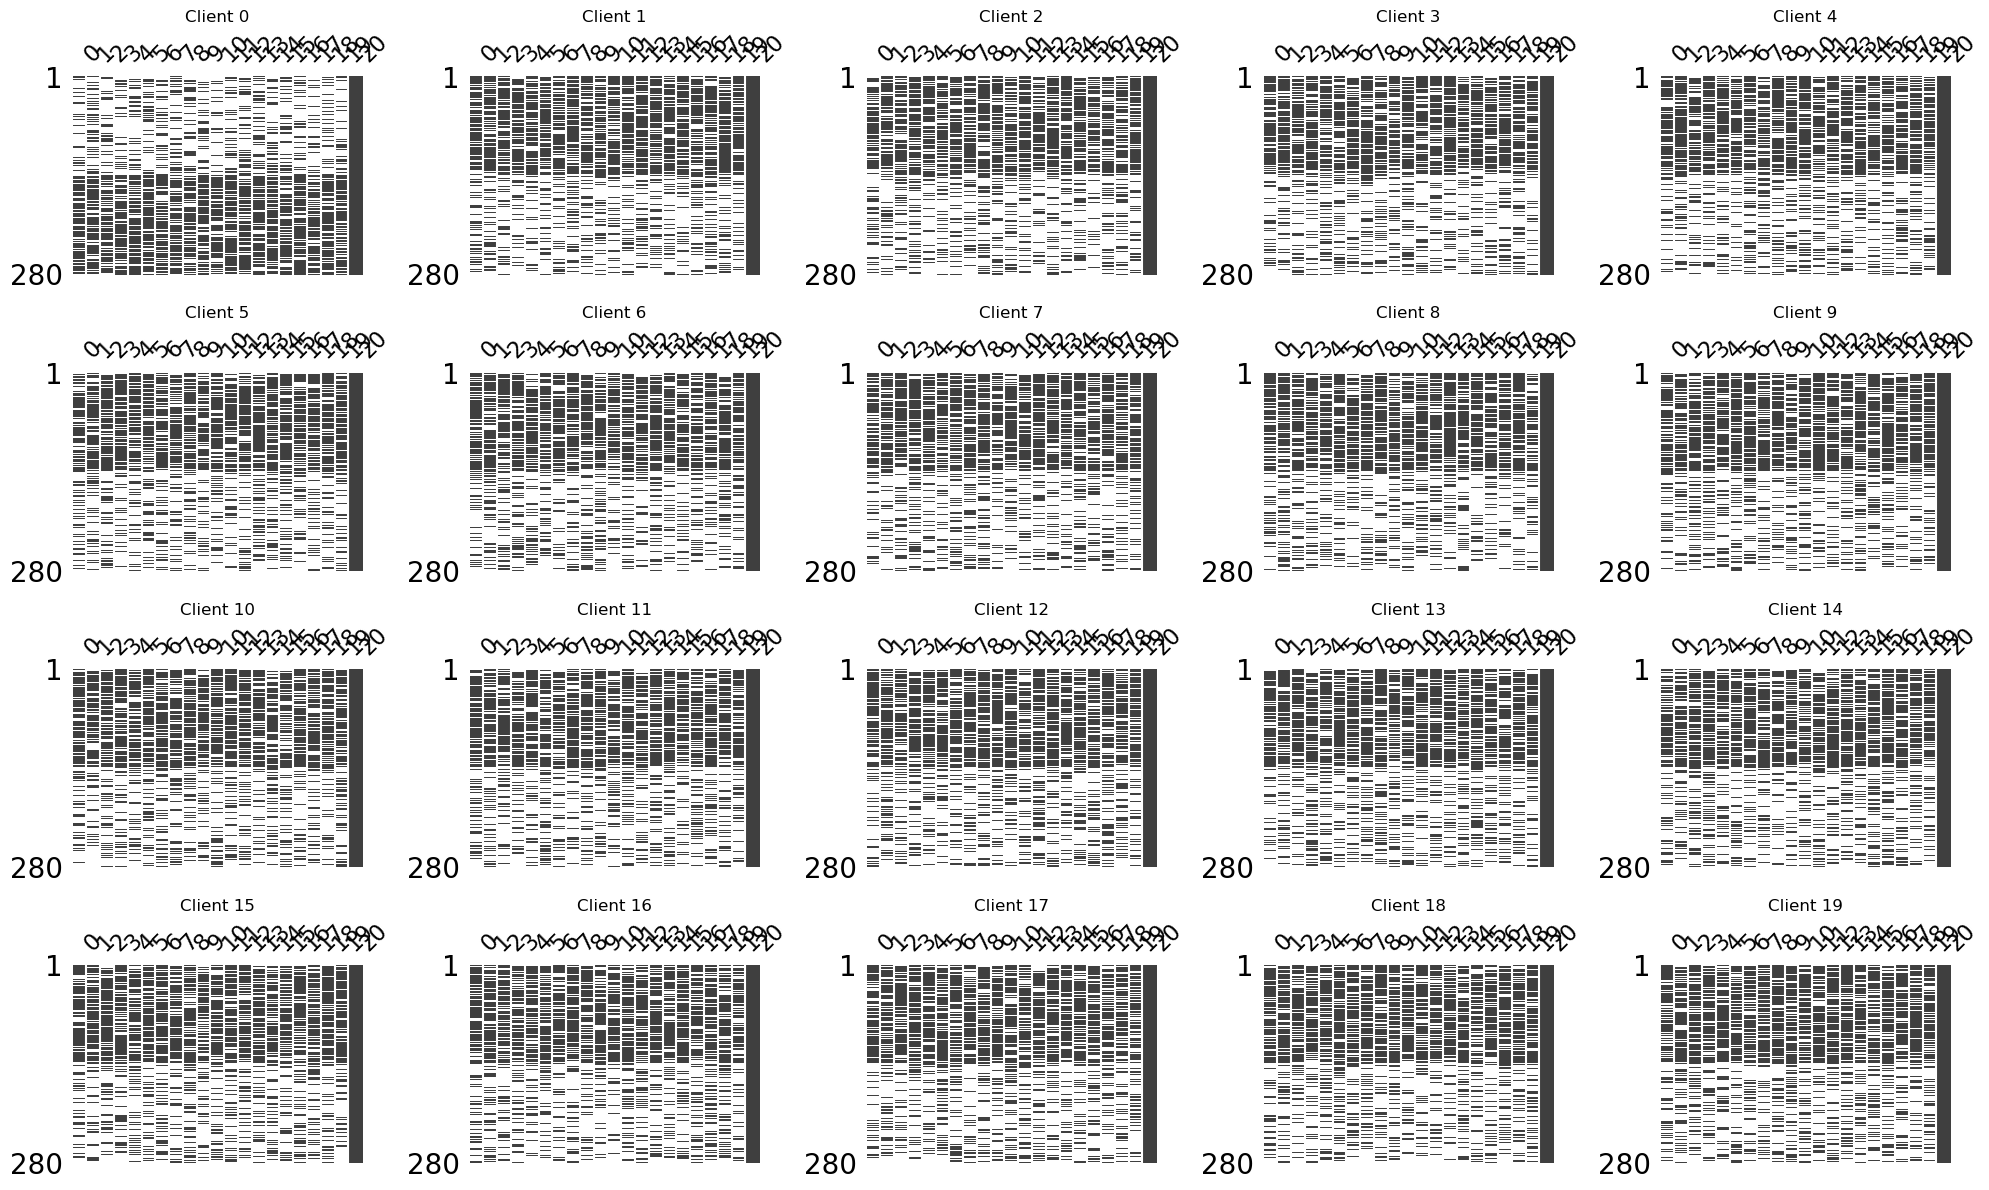

In [54]:
config2 = experiment_config_template.copy()
config2['data']['dataset_name'] = 'ijcnn_balanced_pca'
config2['num_clients'] = 20
config2['missing_simulate']['mr_strategy'] = 'fixed@mr=0.5'
config2['missing_simulate']['mf_strategy'] = 'all'
config2['missing_simulate']['mm_strategy'] = 'mary_sigmoid_lr@sp=extreme_r=1.0'
config2['data_partition']['strategy'] = 'sample@p=280'
config2['agg_strategy_imp']['strategy'] = 'fedavg-s'

configuration = config2
num_clients = configuration['num_clients']
# set random seed
seed = configuration['experiment']['seed']
mtp = configuration['experiment']['mtp']
tune_params = configuration['tune_params']
random.seed(seed)  # seed for split data

# load data
dataset_params = configuration['data']
data, data_config = load_data(**dataset_params)
regression = data_config['task_type'] == 'regression'

n_rounds = configuration['experiment']['n_rounds']
test_size = configuration['experiment'].get('test_size', 0.1)
if n_rounds == 1:
    n_rounds_data = split_train_test(data, n_folds=2, seed=seed, test_size=test_size, regression=regression)
else:
    n_rounds_data = split_train_test(
        data, n_folds=n_rounds, seed=seed, test_size=test_size, regression=regression
        )

# n rounds average
train_data, test_data = n_rounds_data[0]

new_seed = (seed + 10087 * 0) % (2 ^ 23)
regression = data_config['task_type'] == 'regression'
data_partition_params = configuration['data_partition']
data_partitions = data_partition(
    **data_partition_params, data=train_data.values, n_clients=num_clients, seed=new_seed,
    regression=regression
)
missing_params = configuration['missing_simulate']
cols = np.arange(0, train_data.shape[1] - 1)
scenario = missing_params
data_ms_clients2 = add_missing(
    train_data_list=data_partitions, scenario=scenario, cols=cols, seed=new_seed
)

client_factory = ClientsFactory(debug=False)
clients = client_factory.generate_clients(
    num_clients, data_partitions, data_ms_clients2, test_data.values, data_config,
    configuration['imputation'], seed=new_seed
)
visualize_ms(data_ms_clients2)

2023-07-21 09:45:00.657 | INFO     | src.fed_imp.sub_modules.server.base_server:run:155 - FL finished in 115.30042480002157


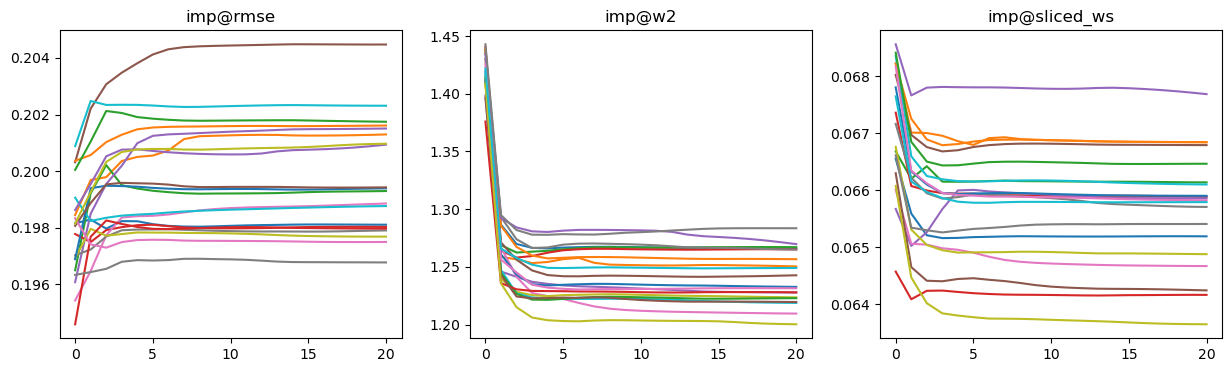

{'imp@rmse': 0.1997162395811133, 'imp@ws': 1.2417815591110966, 'imp@sliced_ws': 0.06570780960700805}
Accuracy imputed centralized MLP:0.5823 (0.011)
Accuracy imputed centralized LR:0.8447 (0.000)


In [56]:
configuration['agg_strategy_imp']['strategy'] = 'fedmechw'
configuration['server_type'] = 'fedavg_pytorch'
configuration['prediction'] = False
configuration['save_state'] = True
configuration['track'] = True

configuration['algo_params']["fedmechw"] = {
    "client_thres": 1.0,
    "alpha": 1.0,
    "beta": 0
}
configuration['algo_params']["scale_factor"] = 4


# Create Imputation Strategy
imp_strategy = configuration['agg_strategy_imp']['strategy']
params = configuration['algo_params'][imp_strategy]

strategy_imp = StrategyImputation(strategy=imp_strategy, params=params)

# Create Server
server_type = configuration['server_type']
server_config = configuration['server']
server_config["n_cols"] = test_data.shape[1] - 1

pred_config = configuration['pred_model']
pred_config['model_params']['input_feature_dim'] = test_data.shape[1] - 1
pred_config['model_params']['output_classes_dim'] = len(np.unique(test_data.iloc[:, -1].values))

server = load_server(
    server_type,
    clients=clients,
    strategy_imp=strategy_imp,
    server_config=server_config,
    pred_config=pred_config,
    test_data=test_data.values,
    seed=new_seed,
    track=configuration['track'],
    run_prediction=configuration['prediction'],
    persist_data=configuration['save_state'],
)

# return server
ret001 = server.run()
trackers['mary_left_fedmechw'] = server.stats_tracker
rets['mary_left_fedmechw'] = ret001

vis_imp(ret001)
print(ret001['imp_result'])
sklearn_evaluation(ret001)

## MARY Right 20:0

### Local

sample {'p': '280'}
0.010859026565832848 25785
['mary_sigmoid_right' 'mary_sigmoid_right' 'mary_sigmoid_right'
 'mary_sigmoid_right' 'mary_sigmoid_right' 'mary_sigmoid_right'
 'mary_sigmoid_right' 'mary_sigmoid_right' 'mary_sigmoid_right'
 'mary_sigmoid_right' 'mary_sigmoid_right' 'mary_sigmoid_right'
 'mary_sigmoid_right' 'mary_sigmoid_right' 'mary_sigmoid_right'
 'mary_sigmoid_right' 'mary_sigmoid_right' 'mary_sigmoid_right'
 'mary_sigmoid_right' 'mary_sigmoid_right']


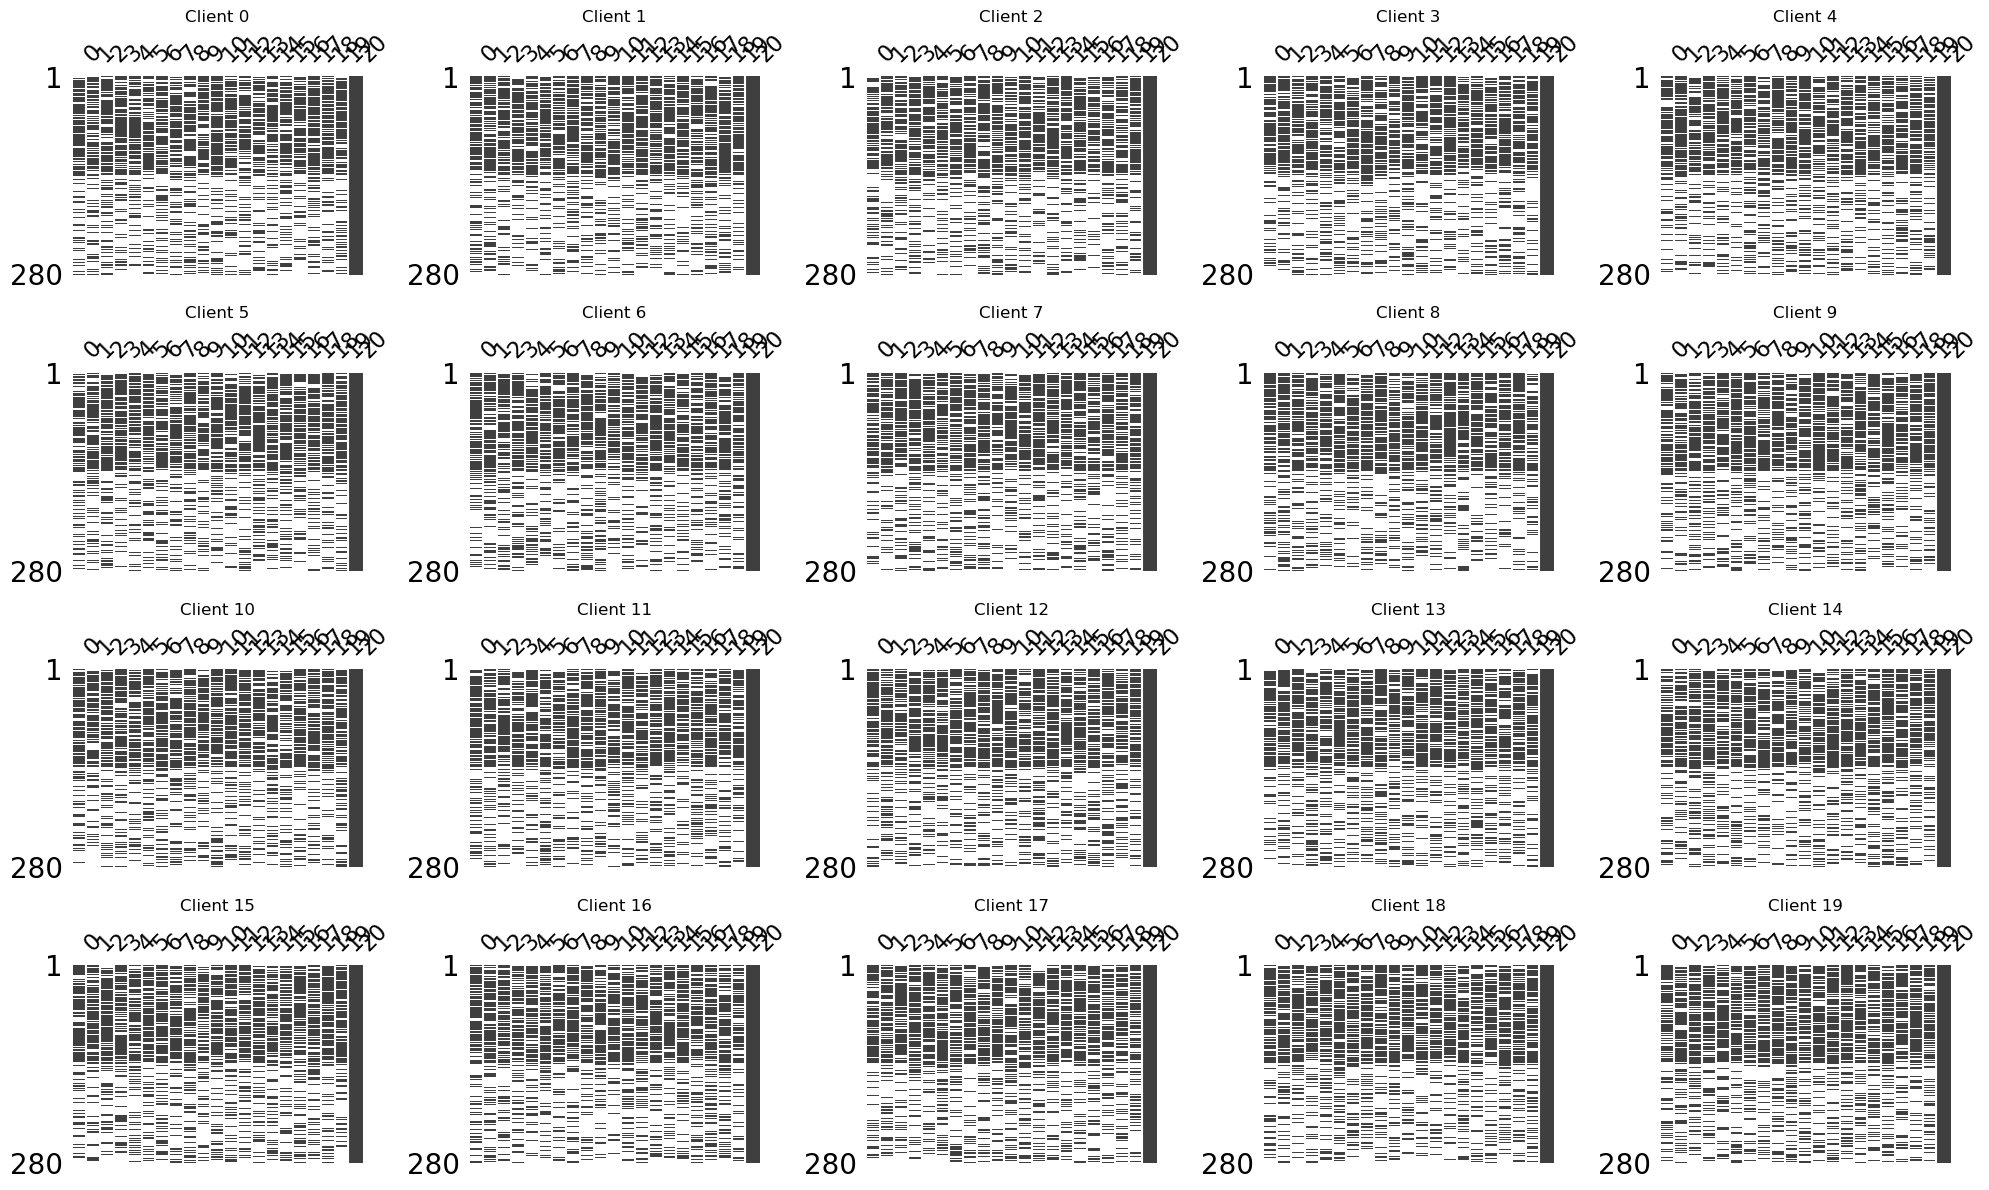

In [96]:
config2 = experiment_config_template.copy()
config2['data']['dataset_name'] = 'ijcnn_balanced_pca'
config2['num_clients'] = 20
config2['missing_simulate']['mr_strategy'] = 'fixed@mr=0.5'
config2['missing_simulate']['mf_strategy'] = 'all'
config2['missing_simulate']['mm_strategy'] = 'mary_sigmoid_lr@sp=extreme_r=0.0'
config2['data_partition']['strategy'] = 'sample@p=280'
config2['agg_strategy_imp']['strategy'] = 'fedavg-s'

configuration = config2
num_clients = configuration['num_clients']
# set random seed
seed = configuration['experiment']['seed']
mtp = configuration['experiment']['mtp']
tune_params = configuration['tune_params']
random.seed(seed)  # seed for split data

# load data
dataset_params = configuration['data']
data, data_config = load_data(**dataset_params)
regression = data_config['task_type'] == 'regression'

n_rounds = configuration['experiment']['n_rounds']
test_size = configuration['experiment'].get('test_size', 0.1)
if n_rounds == 1:
    n_rounds_data = split_train_test(data, n_folds=2, seed=seed, test_size=test_size, regression=regression)
else:
    n_rounds_data = split_train_test(
        data, n_folds=n_rounds, seed=seed, test_size=test_size, regression=regression
        )

# n rounds average
train_data, test_data = n_rounds_data[0]

new_seed = (seed + 10087 * 0) % (2 ^ 23)
regression = data_config['task_type'] == 'regression'
data_partition_params = configuration['data_partition']
data_partitions = data_partition(
    **data_partition_params, data=train_data.values, n_clients=num_clients, seed=new_seed,
    regression=regression
)
missing_params = configuration['missing_simulate']
cols = np.arange(0, train_data.shape[1] - 1)
scenario = missing_params
data_ms_clients2 = add_missing(
    train_data_list=data_partitions, scenario=scenario, cols=cols, seed=new_seed
)

client_factory = ClientsFactory(debug=False)
clients = client_factory.generate_clients(
    num_clients, data_partitions, data_ms_clients2, test_data.values, data_config,
    configuration['imputation'], seed=new_seed
)
visualize_ms(data_ms_clients2)

2023-07-21 10:39:33.332 | INFO     | src.fed_imp.sub_modules.server.base_server:run:155 - FL finished in 112.32617769995704


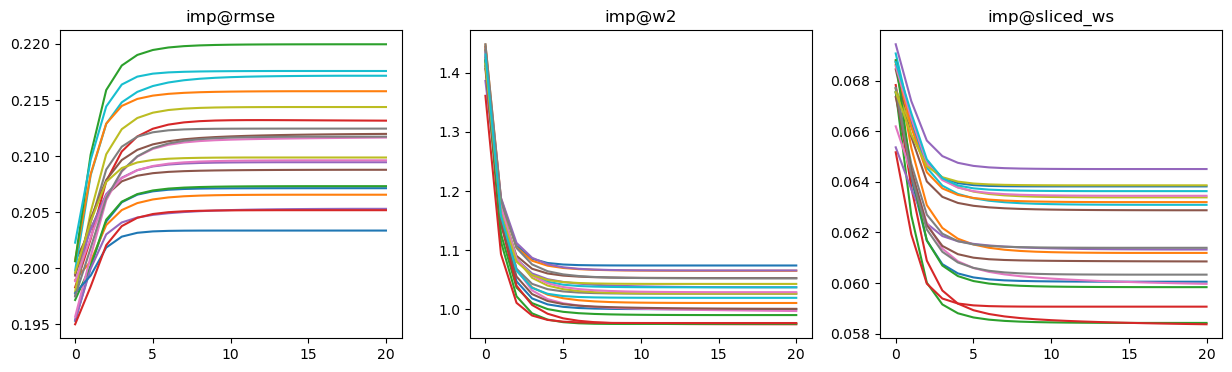

{'imp@rmse': 0.21093843057209277, 'imp@ws': 1.0128029882480358, 'imp@sliced_ws': 0.061437466599834026}
Accuracy imputed centralized MLP:0.5690 (0.009)
Accuracy imputed centralized LR:0.8452 (0.000)


In [97]:
configuration['agg_strategy_imp']['strategy'] = 'local'
configuration['server_type'] = 'fedavg_pytorch'
configuration['prediction'] = False
configuration['save_state'] = True
configuration['track'] = True

# Create Imputation Strategy
imp_strategy = configuration['agg_strategy_imp']['strategy']
params = configuration['algo_params'][imp_strategy]

strategy_imp = StrategyImputation(strategy=imp_strategy, params=params)

# Create Server
server_type = configuration['server_type']
server_config = configuration['server']
server_config["n_cols"] = test_data.shape[1] - 1

pred_config = configuration['pred_model']
pred_config['model_params']['input_feature_dim'] = test_data.shape[1] - 1
pred_config['model_params']['output_classes_dim'] = len(np.unique(test_data.iloc[:, -1].values))

server = load_server(
    server_type,
    clients=clients,
    strategy_imp=strategy_imp,
    server_config=server_config,
    pred_config=pred_config,
    test_data=test_data.values,
    seed=new_seed,
    track=configuration['track'],
    run_prediction=configuration['prediction'],
    persist_data=configuration['save_state'],
)

# return server
ret101 = server.run()
trackers['mary_right_local'] = server.stats_tracker
rets['mary_right_local'] = ret101

vis_imp(ret101)
print(ret101['imp_result'])
sklearn_evaluation(ret101)

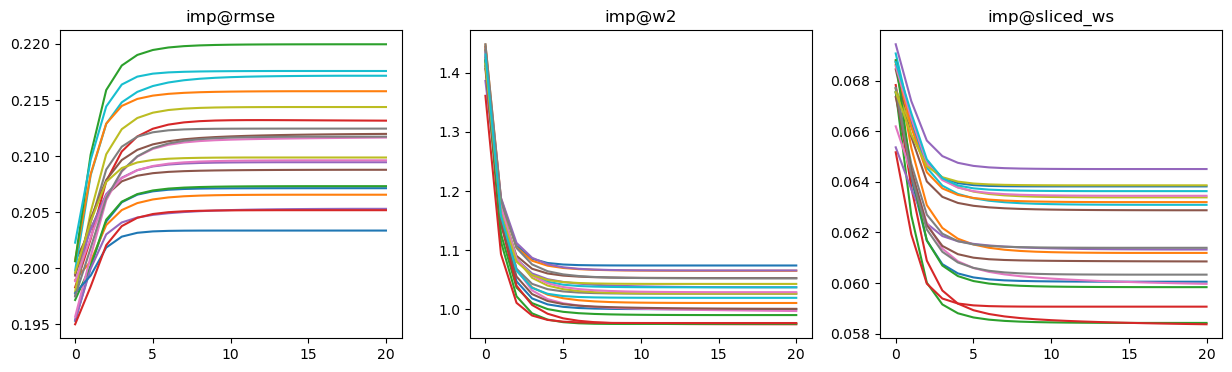

{'imp@rmse': 0.2109149942727615, 'imp@ws': 1.0226367154866451, 'imp@sliced_ws': 0.061636247155269955}
Accuracy imputed centralized MLP:0.5690 (0.009)
Accuracy imputed centralized LR:0.8452 (0.000)


In [99]:
vis_imp(ret101)
print(ret101['imp_result'])
sklearn_evaluation(ret101)

## MARY LR 19:1

### Local

### Simple Average

sample {'p': '280'}
0.010859026565832848 25785


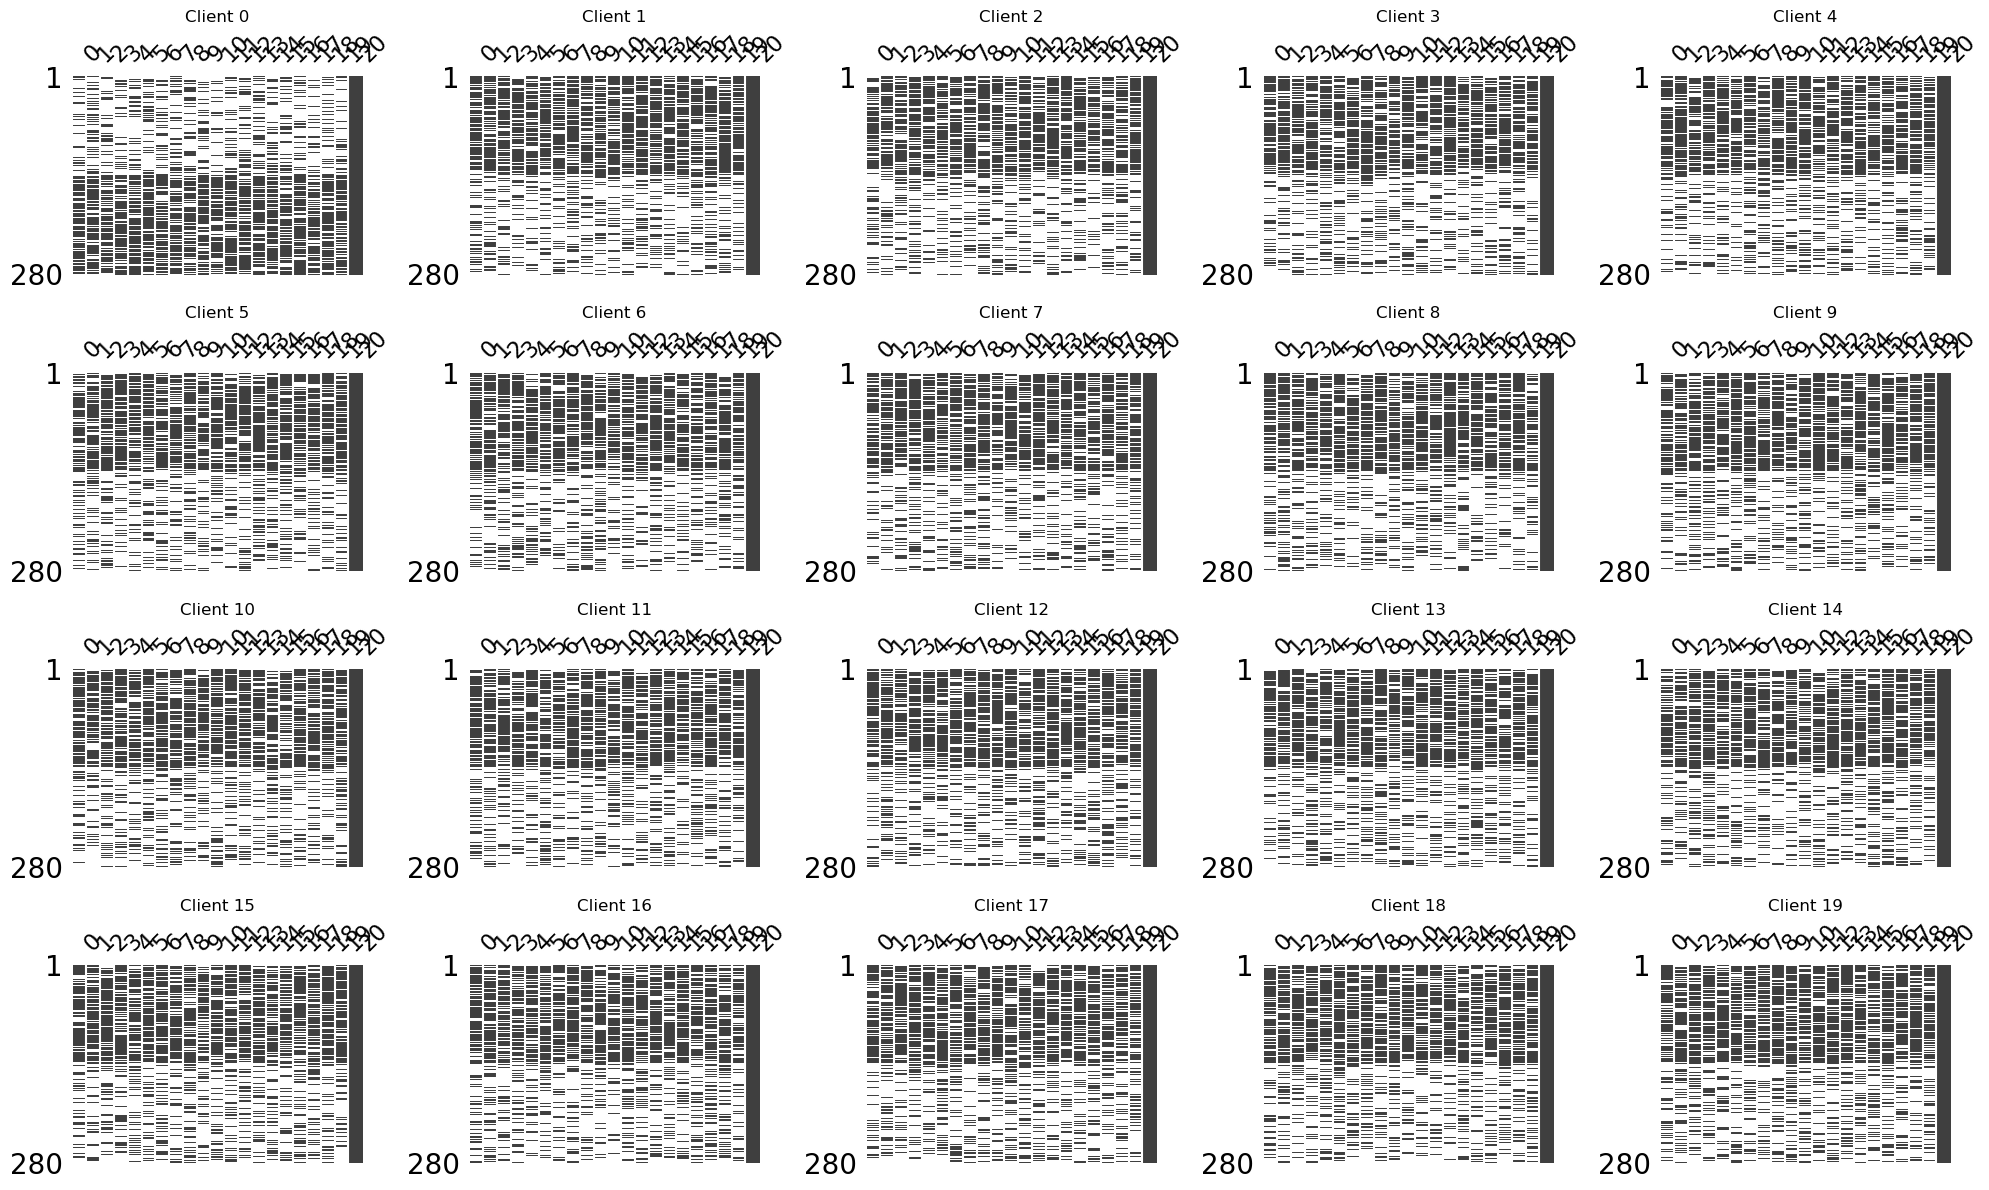

In [13]:
config2 = experiment_config_template.copy()
config2['data']['dataset_name'] = 'ijcnn_balanced_pca'
config2['num_clients'] = 20
config2['missing_simulate']['mr_strategy'] = 'fixed@mr=0.5'
config2['missing_simulate']['mf_strategy'] = 'all'
config2['missing_simulate']['mm_strategy'] = 'mary_sigmoid_lr@sp=extreme_sr=0.95'
config2['data_partition']['strategy'] = 'sample@p=280'
config2['agg_strategy_imp']['strategy'] = 'fedavg-s'

configuration = config2
num_clients = configuration['num_clients']
# set random seed
seed = configuration['experiment']['seed']
mtp = configuration['experiment']['mtp']
tune_params = configuration['tune_params']
random.seed(seed)  # seed for split data

# load data
dataset_params = configuration['data']
data, data_config = load_data(**dataset_params)
regression = data_config['task_type'] == 'regression'

n_rounds = configuration['experiment']['n_rounds']
test_size = configuration['experiment'].get('test_size', 0.1)
if n_rounds == 1:
    n_rounds_data = split_train_test(data, n_folds=2, seed=seed, test_size=test_size, regression=regression)
else:
    n_rounds_data = split_train_test(
        data, n_folds=n_rounds, seed=seed, test_size=test_size, regression=regression
        )

# n rounds average
train_data, test_data = n_rounds_data[0]

new_seed = (seed + 10087 * 0) % (2 ^ 23)
regression = data_config['task_type'] == 'regression'
data_partition_params = configuration['data_partition']
data_partitions = data_partition(
    **data_partition_params, data=train_data.values, n_clients=num_clients, seed=new_seed,
    regression=regression
)
missing_params = configuration['missing_simulate']
cols = np.arange(0, train_data.shape[1] - 1)
scenario = missing_params
data_ms_clients2 = add_missing(
    train_data_list=data_partitions, scenario=scenario, cols=cols, seed=new_seed
)

client_factory = ClientsFactory(debug=False)
clients = client_factory.generate_clients(
    num_clients, data_partitions, data_ms_clients2, test_data.values, data_config,
    configuration['imputation'], seed=new_seed
)
visualize_ms(data_ms_clients2)

2023-07-21 08:58:51.302 | INFO     | src.fed_imp.sub_modules.server.base_server:run:155 - FL finished in 105.28214969998226


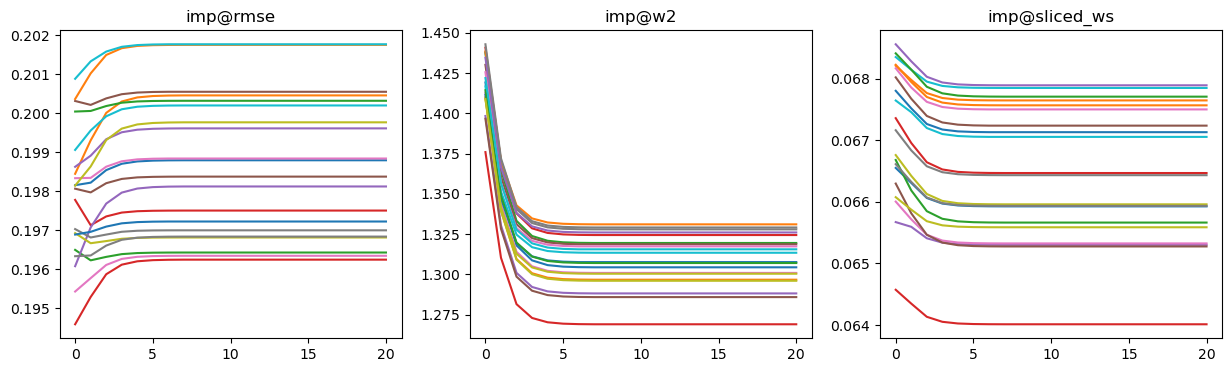

{'imp@rmse': 0.19864963057562046, 'imp@ws': 1.3089092603181873, 'imp@sliced_ws': 0.06647413136811693}
Accuracy imputed centralized MLP:0.5930 (0.016)
Accuracy imputed centralized LR:0.8435 (0.000)
Accuracy orignal centralized MLP:0.9406 (0.005)
Accuracy orignal centralized MLP:0.8703 (0.000)


In [14]:
configuration['agg_strategy_imp']['strategy'] = 'fedavg-s'
configuration['server_type'] = 'fedavg_pytorch'
configuration['prediction'] = False
configuration['save_state'] = True
configuration['track'] = True

# Create Imputation Strategy
imp_strategy = configuration['agg_strategy_imp']['strategy']
params = configuration['algo_params'][imp_strategy]

strategy_imp = StrategyImputation(strategy=imp_strategy, params=params)

# Create Server
server_type = configuration['server_type']
server_config = configuration['server']
server_config["n_cols"] = test_data.shape[1] - 1

pred_config = configuration['pred_model']
pred_config['model_params']['input_feature_dim'] = test_data.shape[1] - 1
pred_config['model_params']['output_classes_dim'] = len(np.unique(test_data.iloc[:, -1].values))

server = load_server(
    server_type,
    clients=clients,
    strategy_imp=strategy_imp,
    server_config=server_config,
    pred_config=pred_config,
    test_data=test_data.values,
    seed=new_seed,
    track=configuration['track'],
    run_prediction=configuration['prediction'],
    persist_data=configuration['save_state'],
)

# return server
ret0 = server.run()
trackers['mary_lr_simpleavg'] = server.stats_tracker
rets['mary_lr_simpleavg'] = ret0

vis_imp(ret0)
print(ret0['imp_result'])
sklearn_evaluation(ret0)

In [20]:
pred_ret0 = NN_evaluation(ret0, type='centralized')

2023-07-21 09:03:21.455 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:158 - Round: 0, test_accu: 0.5000, train_loss: 0.6914 val_accu: 0.5009 val_f1: 0.3353
2023-07-21 09:03:33.283 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:158 - Round: 100, test_accu: 0.5874, train_loss: 0.2971 val_accu: 0.8732 val_f1: 0.8732
2023-07-21 09:03:45.289 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:158 - Round: 200, test_accu: 0.5839, train_loss: 0.2757 val_accu: 0.8723 val_f1: 0.8723
2023-07-21 09:03:58.272 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:158 - Round: 300, test_accu: 0.6020, train_loss: 0.2684 val_accu: 0.8768 val_f1: 0.8767
2023-07-21 09:04:11.398 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:158 - Round: 400, test_accu: 0.5813, train_loss: 0.2606 val_accu: 0.8705 val_f1: 0.8705
2023-07-21 09:04:23.768 | I

KeyboardInterrupt: 

### Our Models

sample {'p': '280'}
0.010859026565832848 25785


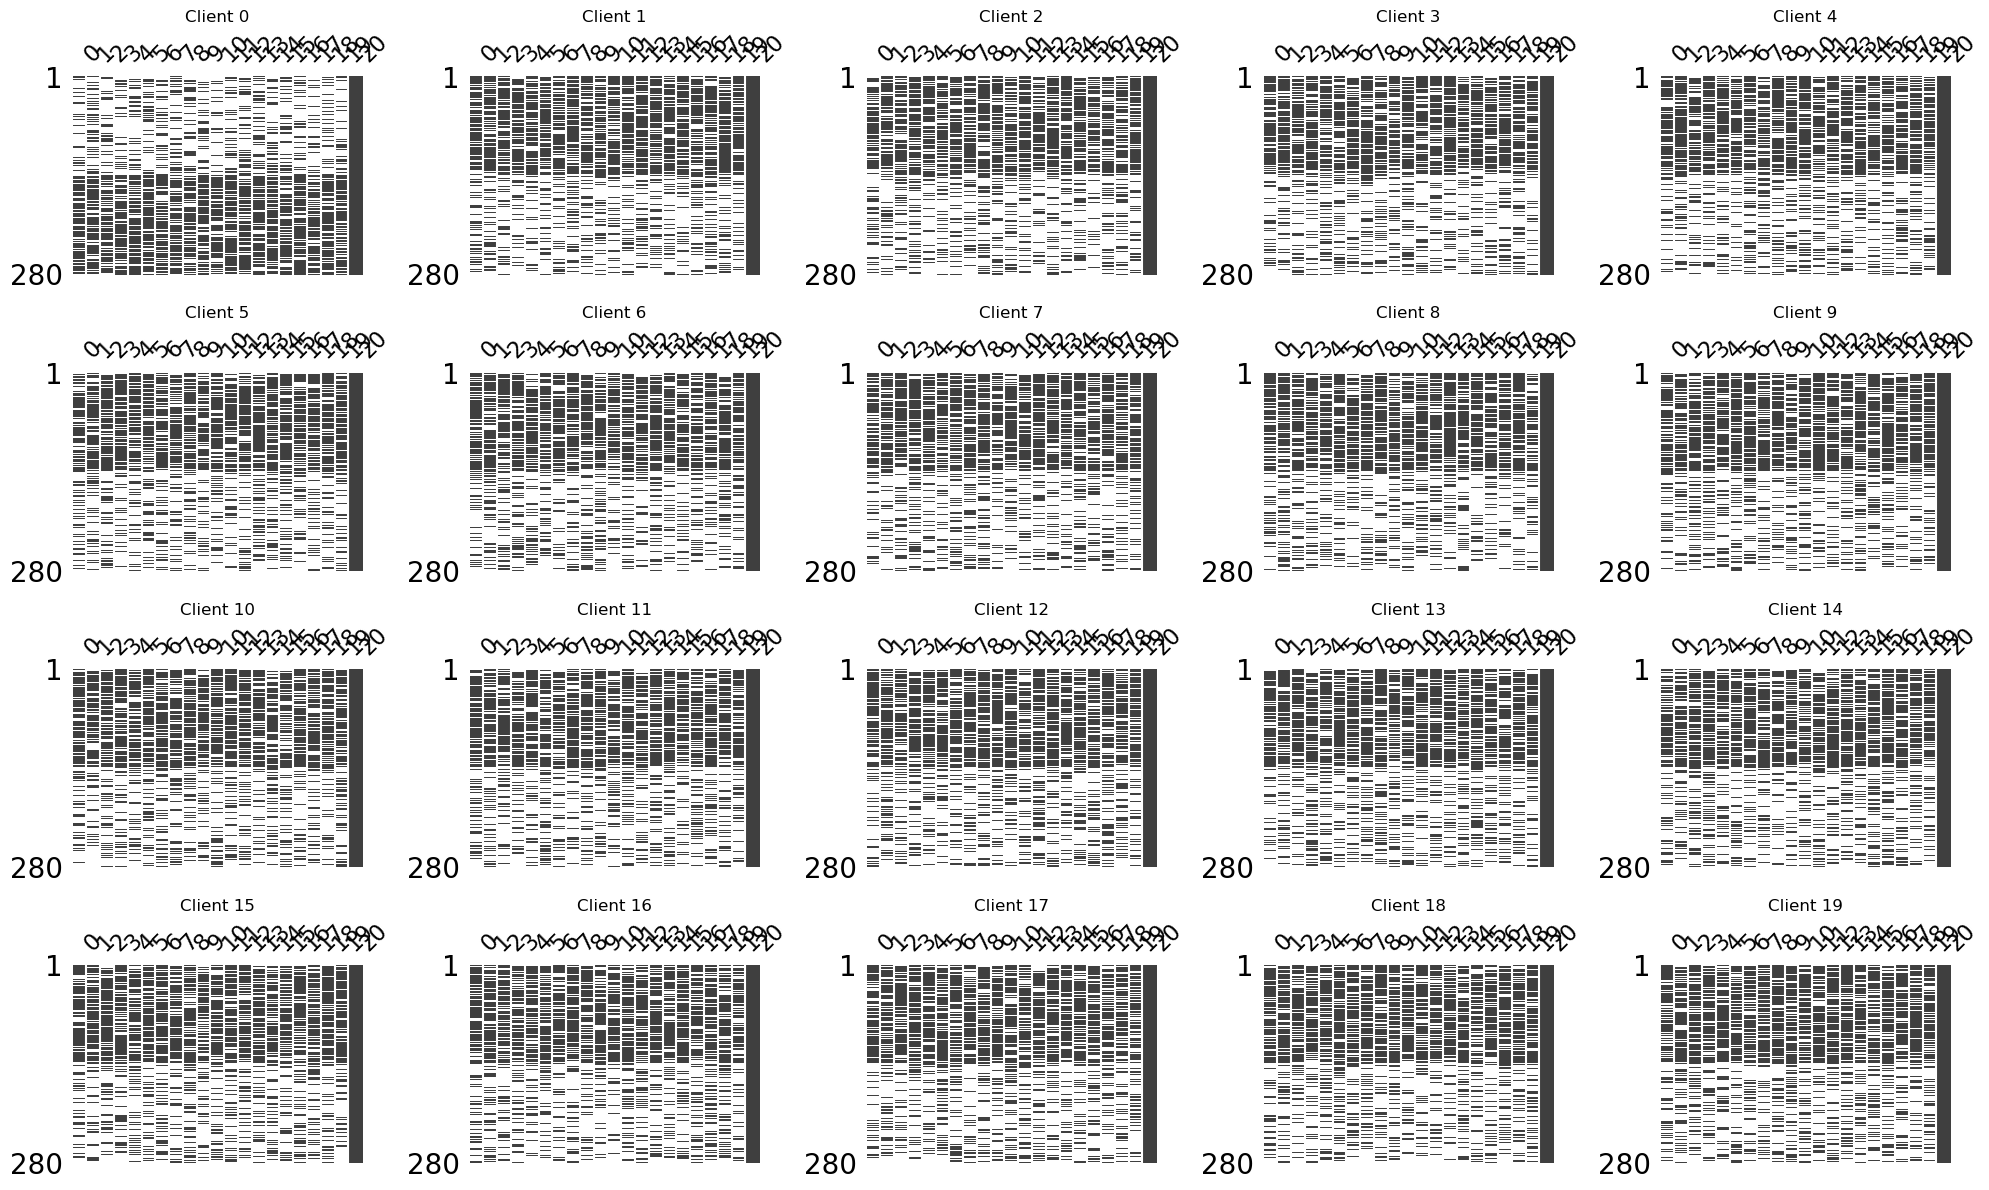

In [23]:
config2 = experiment_config_template.copy()
config2['data']['dataset_name'] = 'ijcnn_balanced_pca'
config2['num_clients'] = 20
config2['missing_simulate']['mr_strategy'] = 'fixed@mr=0.5'
config2['missing_simulate']['mf_strategy'] = 'all'
config2['missing_simulate']['mm_strategy'] = 'mary_sigmoid_lr@sp=extreme_sr=0.95'
config2['data_partition']['strategy'] = 'sample@p=280'
config2['agg_strategy_imp']['strategy'] = 'fedavg-s'

configuration = config2
num_clients = configuration['num_clients']
# set random seed
seed = configuration['experiment']['seed']
mtp = configuration['experiment']['mtp']
tune_params = configuration['tune_params']
random.seed(seed)  # seed for split data

# load data
dataset_params = configuration['data']
data, data_config = load_data(**dataset_params)
regression = data_config['task_type'] == 'regression'

n_rounds = configuration['experiment']['n_rounds']
test_size = configuration['experiment'].get('test_size', 0.1)
if n_rounds == 1:
    n_rounds_data = split_train_test(data, n_folds=2, seed=seed, test_size=test_size, regression=regression)
else:
    n_rounds_data = split_train_test(
        data, n_folds=n_rounds, seed=seed, test_size=test_size, regression=regression
        )

# n rounds average
train_data, test_data = n_rounds_data[0]

new_seed = (seed + 10087 * 0) % (2 ^ 23)
regression = data_config['task_type'] == 'regression'
data_partition_params = configuration['data_partition']
data_partitions = data_partition(
    **data_partition_params, data=train_data.values, n_clients=num_clients, seed=new_seed,
    regression=regression
)
missing_params = configuration['missing_simulate']
cols = np.arange(0, train_data.shape[1] - 1)
scenario = missing_params
data_ms_clients2 = add_missing(
    train_data_list=data_partitions, scenario=scenario, cols=cols, seed=new_seed
)

client_factory = ClientsFactory(debug=False)
clients = client_factory.generate_clients(
    num_clients, data_partitions, data_ms_clients2, test_data.values, data_config,
    configuration['imputation'], seed=new_seed
)
visualize_ms(data_ms_clients2)

testavg3


2023-07-21 09:08:18.904 | INFO     | src.fed_imp.sub_modules.server.base_server:run:155 - FL finished in 114.62446760002058


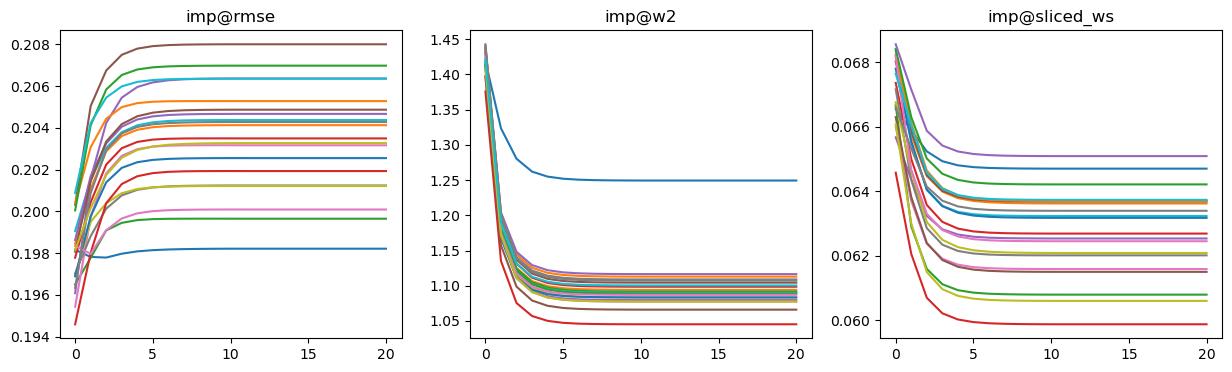

{'imp@rmse': 0.2035040130377211, 'imp@ws': 1.0980890483979928, 'imp@sliced_ws': 0.06272996424627436}
Accuracy imputed centralized MLP:0.5833 (0.022)
Accuracy imputed centralized LR:0.8317 (0.000)
Accuracy orignal centralized MLP:0.9406 (0.005)
Accuracy orignal centralized MLP:0.8703 (0.000)


In [24]:
configuration['agg_strategy_imp']['strategy'] = 'testavg3'
configuration['server_type'] = 'fedavg_pytorch'
configuration['prediction'] = False
configuration['save_state'] = True
configuration['track'] = True

# Create Imputation Strategy
imp_strategy = configuration['agg_strategy_imp']['strategy']
params = configuration['algo_params'][imp_strategy]

strategy_imp = StrategyImputation(strategy=imp_strategy, params=params)

# Create Server
server_type = configuration['server_type']
server_config = configuration['server']
server_config["n_cols"] = test_data.shape[1] - 1

pred_config = configuration['pred_model']
pred_config['model_params']['input_feature_dim'] = test_data.shape[1] - 1
pred_config['model_params']['output_classes_dim'] = len(np.unique(test_data.iloc[:, -1].values))

server = load_server(
    server_type,
    clients=clients,
    strategy_imp=strategy_imp,
    server_config=server_config,
    pred_config=pred_config,
    test_data=test_data.values,
    seed=new_seed,
    track=configuration['track'],
    run_prediction=configuration['prediction'],
    persist_data=configuration['save_state'],
)

# return server
ret4 = server.run()
rets['mnar_lr_complementary'] = ret4
trackers['mnar_lr_complementary'] = server.stats_tracker

vis_imp(ret4)
print(ret4['imp_result'])
sklearn_evaluation(ret4)

In [27]:
NN_evaluation(ret4, type='centralized')

2023-07-21 09:09:19.127 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:158 - Round: 0, test_accu: 0.5000, train_loss: 0.6917 val_accu: 0.5000 val_f1: 0.3333
2023-07-21 09:09:31.810 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:158 - Round: 100, test_accu: 0.5981, train_loss: 0.2488 val_accu: 0.8830 val_f1: 0.8830
2023-07-21 09:09:45.188 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:158 - Round: 200, test_accu: 0.5860, train_loss: 0.2266 val_accu: 0.8929 val_f1: 0.8928
2023-07-21 09:09:58.323 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:158 - Round: 300, test_accu: 0.5899, train_loss: 0.2173 val_accu: 0.8973 val_f1: 0.8973
2023-07-21 09:10:12.570 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:158 - Round: 400, test_accu: 0.5676, train_loss: 0.2108 val_accu: 0.8875 val_f1: 0.8875


KeyError: 'pred_result'

## MCAR

### Local 

sample {'p': '280'}
0.010859026565832848 25785
['mcar' 'mcar' 'mcar' 'mcar' 'mcar' 'mcar' 'mcar' 'mcar' 'mcar' 'mcar'
 'mcar' 'mcar' 'mcar' 'mcar' 'mcar' 'mcar' 'mcar' 'mcar' 'mcar' 'mcar']


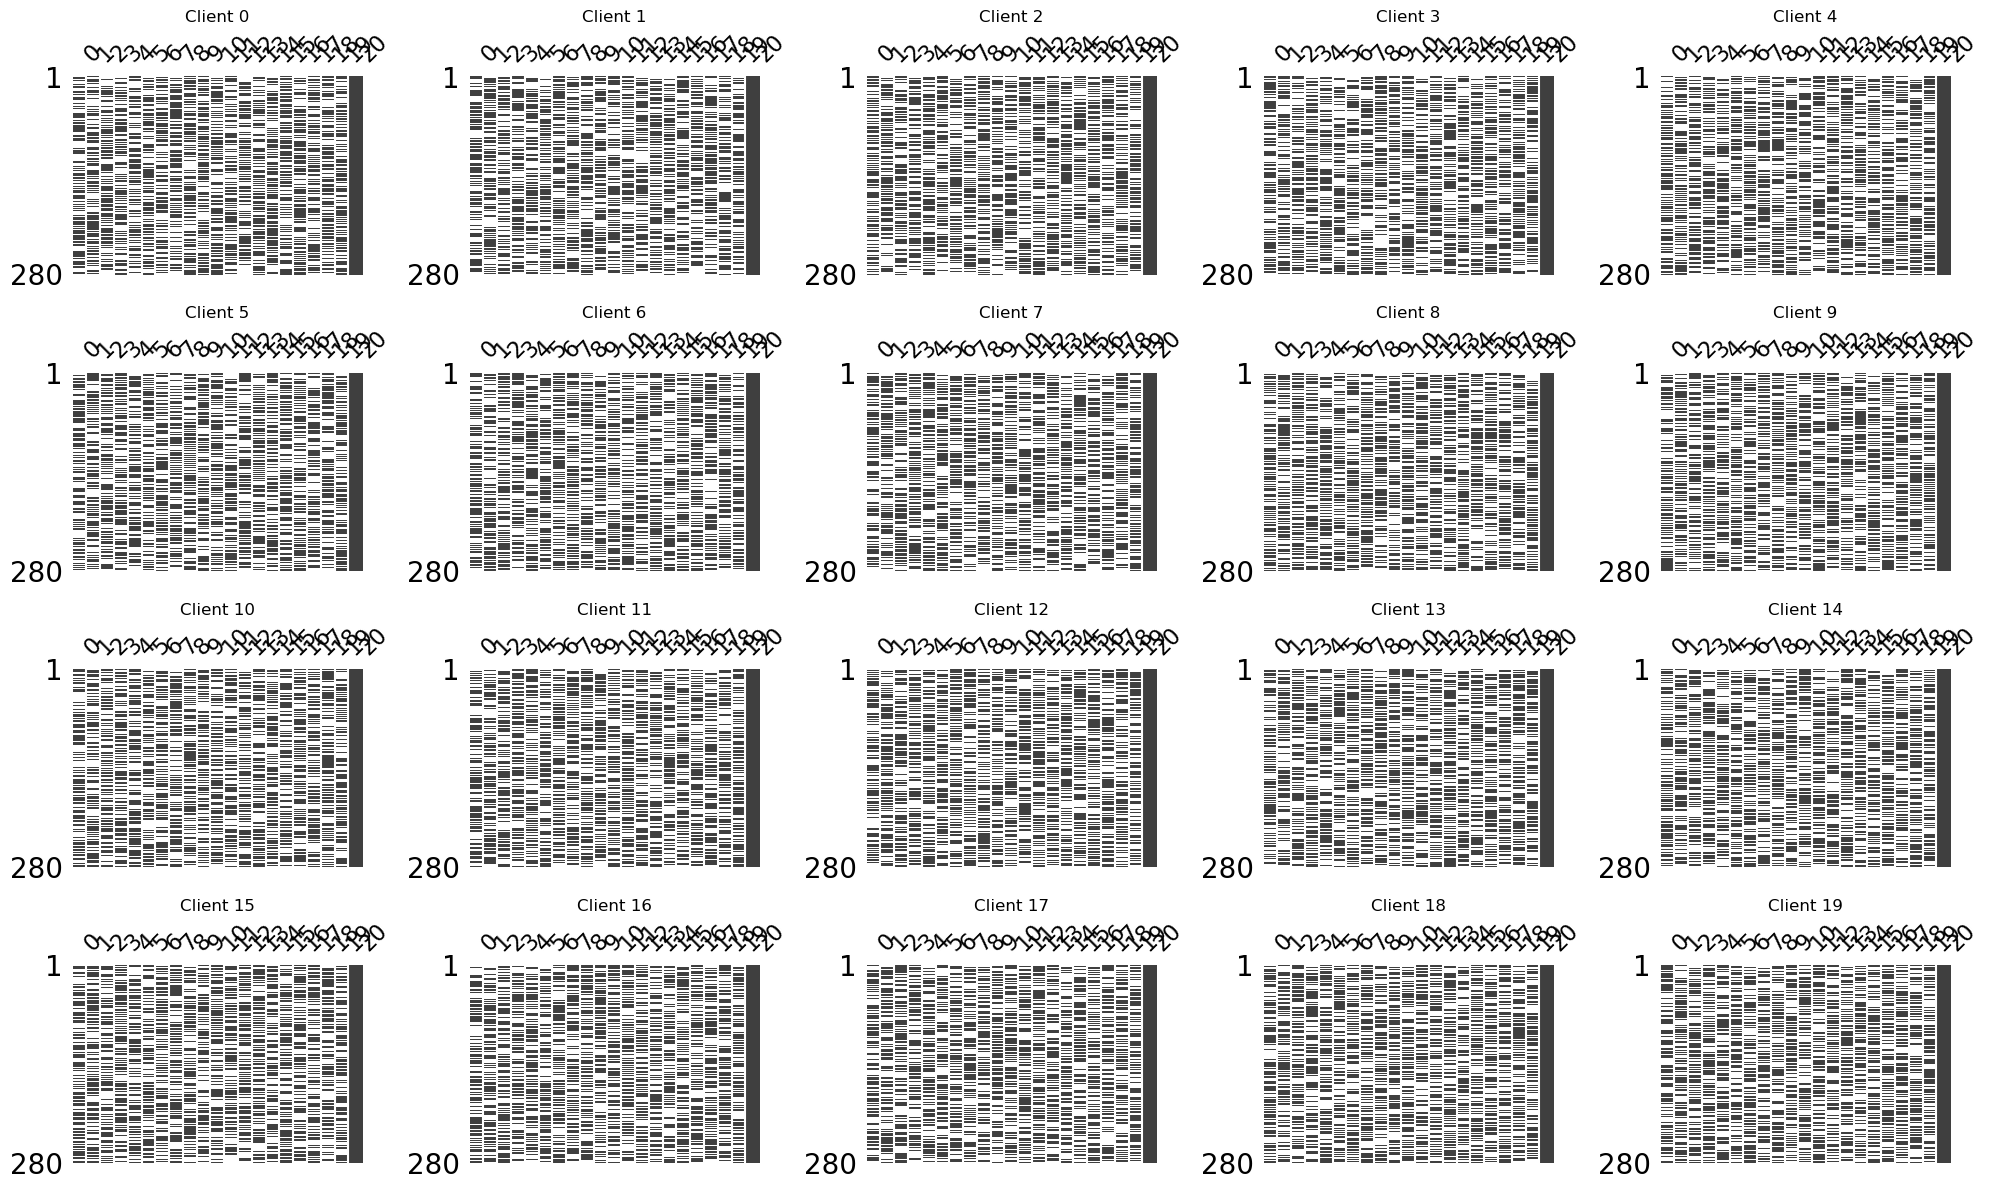

In [49]:
config2 = experiment_config_template.copy()
config2['data']['dataset_name'] = 'ijcnn_balanced_pca'
config2['num_clients'] = 20
config2['missing_simulate']['mr_strategy'] = 'fixed@mr=0.5'
config2['missing_simulate']['mf_strategy'] = 'all'
config2['missing_simulate']['mm_strategy'] = 'single@m=1'
config2['data_partition']['strategy'] = 'sample@p=280'
config2['agg_strategy_imp']['strategy'] = 'fedavg-s'

configuration = config2
num_clients = configuration['num_clients']
# set random seed
seed = configuration['experiment']['seed']
mtp = configuration['experiment']['mtp']
tune_params = configuration['tune_params']
random.seed(seed)  # seed for split data

# load data
dataset_params = configuration['data']
data, data_config = load_data(**dataset_params)
regression = data_config['task_type'] == 'regression'

n_rounds = configuration['experiment']['n_rounds']
test_size = configuration['experiment'].get('test_size', 0.1)
if n_rounds == 1:
    n_rounds_data = split_train_test(data, n_folds=2, seed=seed, test_size=test_size, regression=regression)
else:
    n_rounds_data = split_train_test(
        data, n_folds=n_rounds, seed=seed, test_size=test_size, regression=regression
        )

# n rounds average
train_data, test_data = n_rounds_data[0]

new_seed = (seed + 10087 * 0) % (2 ^ 23)
regression = data_config['task_type'] == 'regression'
data_partition_params = configuration['data_partition']
data_partitions = data_partition(
    **data_partition_params, data=train_data.values, n_clients=num_clients, seed=new_seed,
    regression=regression
)
missing_params = configuration['missing_simulate']
cols = np.arange(0, train_data.shape[1] - 1)
scenario = missing_params
data_ms_clients2 = add_missing(
    train_data_list=data_partitions, scenario=scenario, cols=cols, seed=new_seed
)

client_factory = ClientsFactory(debug=False)
clients = client_factory.generate_clients(
    num_clients, data_partitions, data_ms_clients2, test_data.values, data_config,
    configuration['imputation'], seed=new_seed
)

visualize_ms(data_ms_clients2)

2023-07-21 09:34:10.572 | INFO     | src.fed_imp.sub_modules.server.base_server:run:155 - FL finished in 106.5657244999893


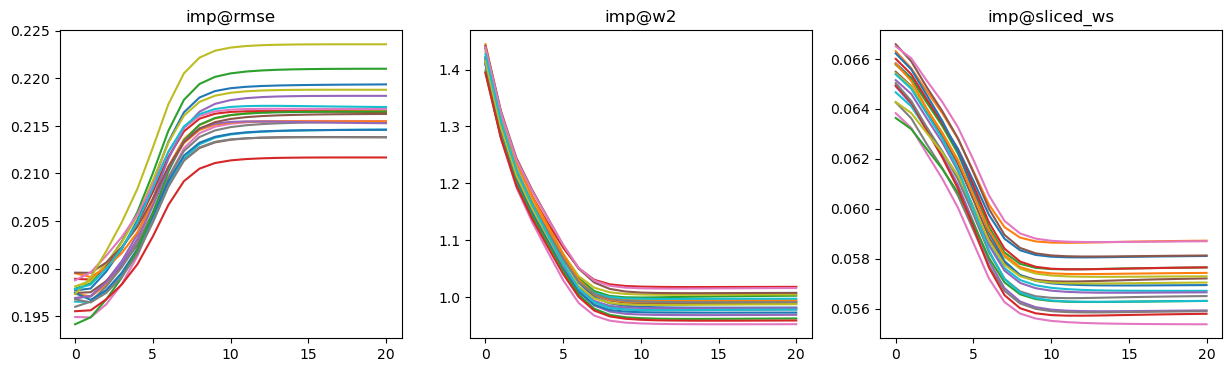

{'imp@rmse': 0.2165428085000487, 'imp@ws': 0.9864654210735513, 'imp@sliced_ws': 0.057006111234912844}
Accuracy imputed centralized MLP:0.8298 (0.015)
Accuracy imputed centralized LR:0.8556 (0.000)


In [50]:
configuration['agg_strategy_imp']['strategy'] = 'fedavg-s'
configuration['server_type'] = 'fedavg_pytorch'
configuration['prediction'] = False
configuration['save_state'] = True
configuration['track'] = True

# Create Imputation Strategy
imp_strategy = configuration['agg_strategy_imp']['strategy']
params = configuration['algo_params'][imp_strategy]

strategy_imp = StrategyImputation(strategy=imp_strategy, params=params)

# Create Server
server_type = configuration['server_type']
server_config = configuration['server']
server_config["n_cols"] = test_data.shape[1] - 1

pred_config = configuration['pred_model']
pred_config['model_params']['input_feature_dim'] = test_data.shape[1] - 1
pred_config['model_params']['output_classes_dim'] = len(np.unique(test_data.iloc[:, -1].values))

server = load_server(
    server_type,
    clients=clients,
    strategy_imp=strategy_imp,
    server_config=server_config,
    pred_config=pred_config,
    test_data=test_data.values,
    seed=new_seed,
    track=configuration['track'],
    run_prediction=configuration['prediction'],
    persist_data=configuration['save_state'],
)

# return server
ret05 = server.run()
trackers['mcar_local'] = server.stats_tracker
rets['mcar_local'] = ret05

vis_imp(ret05)
print(ret05['imp_result'])
sklearn_evaluation(ret05)

### Simple Averaging

sample {'p': '280'}
0.010859026565832848 25785
['mcar' 'mcar' 'mcar' 'mcar' 'mcar' 'mcar' 'mcar' 'mcar' 'mcar' 'mcar'
 'mcar' 'mcar' 'mcar' 'mcar' 'mcar' 'mcar' 'mcar' 'mcar' 'mcar' 'mcar']


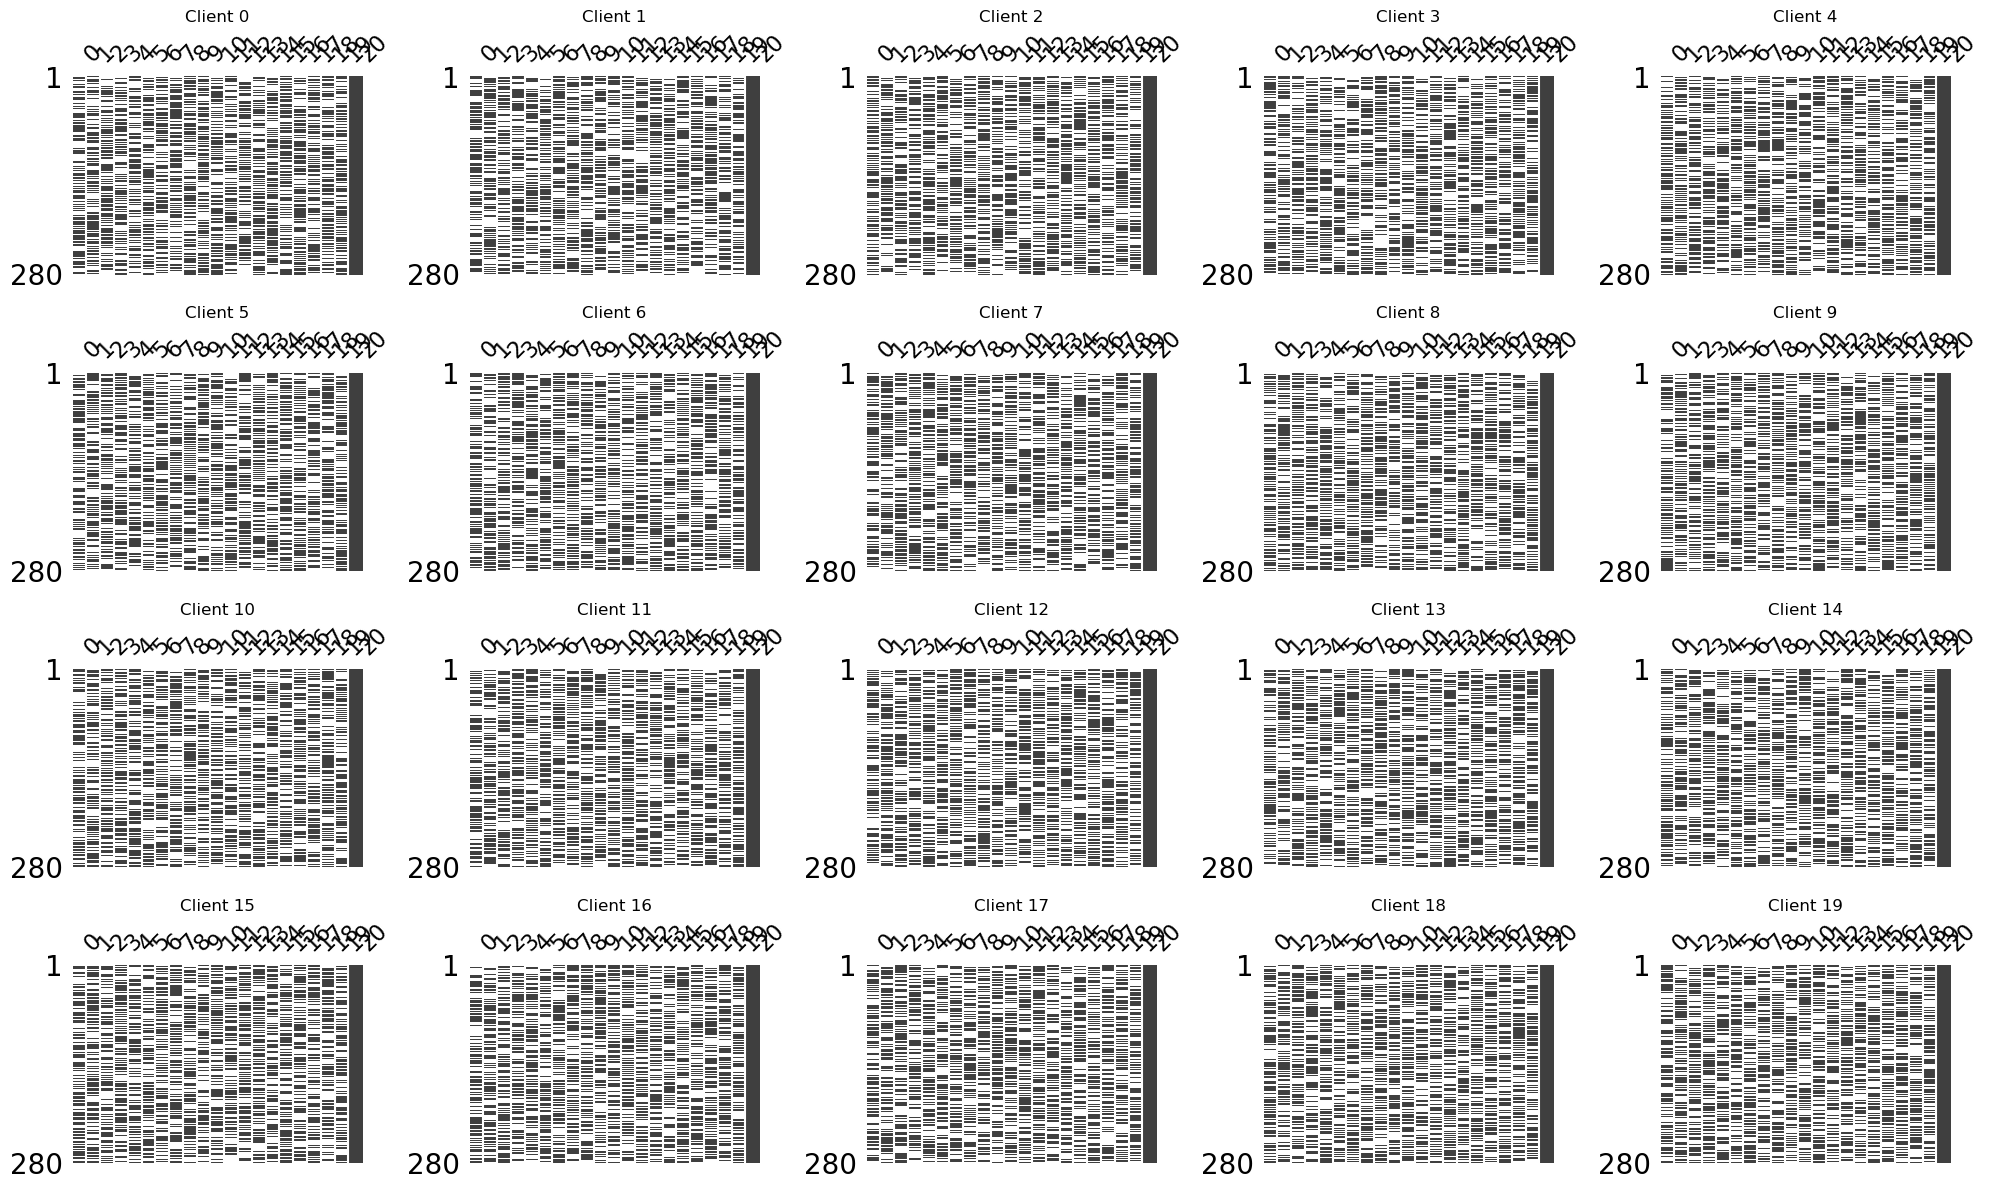

In [30]:
config2 = experiment_config_template.copy()
config2['data']['dataset_name'] = 'ijcnn_balanced_pca'
config2['num_clients'] = 20
config2['missing_simulate']['mr_strategy'] = 'fixed@mr=0.5'
config2['missing_simulate']['mf_strategy'] = 'all'
config2['missing_simulate']['mm_strategy'] = 'single@m=1'
config2['data_partition']['strategy'] = 'sample@p=280'
config2['agg_strategy_imp']['strategy'] = 'fedavg-s'

configuration = config2
num_clients = configuration['num_clients']
# set random seed
seed = configuration['experiment']['seed']
mtp = configuration['experiment']['mtp']
tune_params = configuration['tune_params']
random.seed(seed)  # seed for split data

# load data
dataset_params = configuration['data']
data, data_config = load_data(**dataset_params)
regression = data_config['task_type'] == 'regression'

n_rounds = configuration['experiment']['n_rounds']
test_size = configuration['experiment'].get('test_size', 0.1)
if n_rounds == 1:
    n_rounds_data = split_train_test(data, n_folds=2, seed=seed, test_size=test_size, regression=regression)
else:
    n_rounds_data = split_train_test(
        data, n_folds=n_rounds, seed=seed, test_size=test_size, regression=regression
        )

# n rounds average
train_data, test_data = n_rounds_data[0]

new_seed = (seed + 10087 * 0) % (2 ^ 23)
regression = data_config['task_type'] == 'regression'
data_partition_params = configuration['data_partition']
data_partitions = data_partition(
    **data_partition_params, data=train_data.values, n_clients=num_clients, seed=new_seed,
    regression=regression
)
missing_params = configuration['missing_simulate']
cols = np.arange(0, train_data.shape[1] - 1)
scenario = missing_params
data_ms_clients2 = add_missing(
    train_data_list=data_partitions, scenario=scenario, cols=cols, seed=new_seed
)

client_factory = ClientsFactory(debug=False)
clients = client_factory.generate_clients(
    num_clients, data_partitions, data_ms_clients2, test_data.values, data_config,
    configuration['imputation'], seed=new_seed
)

visualize_ms(data_ms_clients2)

2023-07-21 09:14:37.062 | INFO     | src.fed_imp.sub_modules.server.base_server:run:155 - FL finished in 111.09370570001192


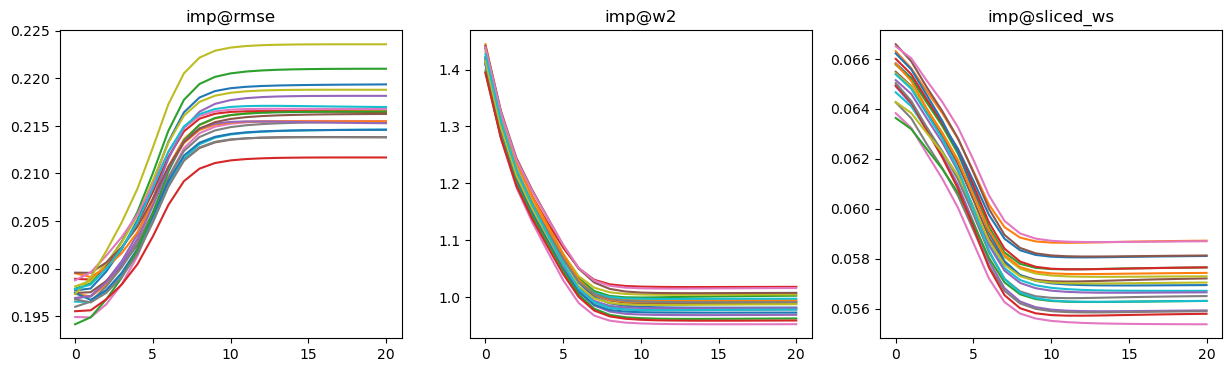

{'imp@rmse': 0.2165428085000487, 'imp@ws': 0.9864654210735513, 'imp@sliced_ws': 0.057006111234912844}
Accuracy imputed centralized MLP:0.8298 (0.015)
Accuracy imputed centralized LR:0.8556 (0.000)


In [31]:
configuration['agg_strategy_imp']['strategy'] = 'fedavg-s'
configuration['server_type'] = 'fedavg_pytorch'
configuration['prediction'] = False
configuration['save_state'] = True
configuration['track'] = True

# Create Imputation Strategy
imp_strategy = configuration['agg_strategy_imp']['strategy']
params = configuration['algo_params'][imp_strategy]

strategy_imp = StrategyImputation(strategy=imp_strategy, params=params)

# Create Server
server_type = configuration['server_type']
server_config = configuration['server']
server_config["n_cols"] = test_data.shape[1] - 1

pred_config = configuration['pred_model']
pred_config['model_params']['input_feature_dim'] = test_data.shape[1] - 1
pred_config['model_params']['output_classes_dim'] = len(np.unique(test_data.iloc[:, -1].values))

server = load_server(
    server_type,
    clients=clients,
    strategy_imp=strategy_imp,
    server_config=server_config,
    pred_config=pred_config,
    test_data=test_data.values,
    seed=new_seed,
    track=configuration['track'],
    run_prediction=configuration['prediction'],
    persist_data=configuration['save_state'],
)

# return server
ret5 = server.run()
trackers['mcar_simpleavg'] = server.stats_tracker
rets['mcar_simpleavg'] = ret5

vis_imp(ret5)
print(ret5['imp_result'])
sklearn_evaluation(ret5)

In [33]:
pred_ret5 = NN_evaluation(ret5, type='centralized')

2023-07-21 09:17:47.079 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:158 - Round: 0, test_accu: 0.5015, train_loss: 0.6938 val_accu: 0.5000 val_f1: 0.3333
2023-07-21 09:17:59.148 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:158 - Round: 100, test_accu: 0.8389, train_loss: 0.5325 val_accu: 0.7321 val_f1: 0.7313
2023-07-21 09:18:12.042 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:158 - Round: 200, test_accu: 0.8420, train_loss: 0.5211 val_accu: 0.7250 val_f1: 0.7247
2023-07-21 09:18:25.069 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:158 - Round: 300, test_accu: 0.8467, train_loss: 0.5165 val_accu: 0.7366 val_f1: 0.7349
2023-07-21 09:18:38.219 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:158 - Round: 400, test_accu: 0.8441, train_loss: 0.5114 val_accu: 0.7330 val_f1: 0.7330


0.8516876300787259


{'accu_mean': 0.8516876300787259,
 'f1_mean': 0.8514606405189091,
 'accu_std': 0.0,
 'f1_std': 0.0}

### Our Method

In [34]:
config2 = experiment_config_template.copy()
config2['data']['dataset_name'] = 'ijcnn_balanced_pca'
config2['num_clients'] = 20
config2['missing_simulate']['mr_strategy'] = 'fixed@mr=0.5'
config2['missing_simulate']['mf_strategy'] = 'all'
config2['missing_simulate']['mm_strategy'] = 'single@m=1'
config2['data_partition']['strategy'] = 'sample@p=280'
config2['agg_strategy_imp']['strategy'] = 'fedmechw'

configuration = config2
num_clients = configuration['num_clients']
# set random seed
seed = configuration['experiment']['seed']
mtp = configuration['experiment']['mtp']
tune_params = configuration['tune_params']
random.seed(seed)  # seed for split data

# load data
dataset_params = configuration['data']
data, data_config = load_data(**dataset_params)
regression = data_config['task_type'] == 'regression'

n_rounds = configuration['experiment']['n_rounds']
test_size = configuration['experiment'].get('test_size', 0.1)
if n_rounds == 1:
    n_rounds_data = split_train_test(data, n_folds=2, seed=seed, test_size=test_size, regression=regression)
else:
    n_rounds_data = split_train_test(
        data, n_folds=n_rounds, seed=seed, test_size=test_size, regression=regression
        )

# n rounds average
train_data, test_data = n_rounds_data[0]

new_seed = (seed + 10087 * 0) % (2 ^ 23)
regression = data_config['task_type'] == 'regression'
data_partition_params = configuration['data_partition']
data_partitions = data_partition(
    **data_partition_params, data=train_data.values, n_clients=num_clients, seed=new_seed,
    regression=regression
)
missing_params = configuration['missing_simulate']
cols = np.arange(0, train_data.shape[1] - 1)
scenario = missing_params
data_ms_clients2 = add_missing(
    train_data_list=data_partitions, scenario=scenario, cols=cols, seed=new_seed
)

client_factory = ClientsFactory(debug=False)
clients = client_factory.generate_clients(
    num_clients, data_partitions, data_ms_clients2, test_data.values, data_config,
    configuration['imputation'], seed=new_seed
)

sample {'p': '280'}
0.010859026565832848 25785
['mcar' 'mcar' 'mcar' 'mcar' 'mcar' 'mcar' 'mcar' 'mcar' 'mcar' 'mcar'
 'mcar' 'mcar' 'mcar' 'mcar' 'mcar' 'mcar' 'mcar' 'mcar' 'mcar' 'mcar']


2023-07-21 09:20:56.220 | INFO     | src.fed_imp.sub_modules.server.base_server:run:155 - FL finished in 112.51389529998414


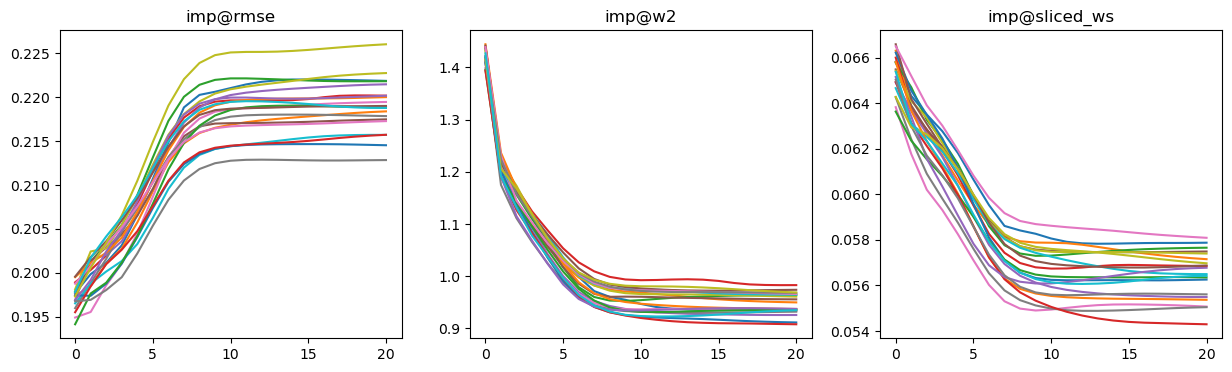

{'imp@rmse': 0.21894700725697158, 'imp@ws': 0.9477743778112893, 'imp@sliced_ws': 0.05649178734801344}
Accuracy imputed centralized MLP:0.8423 (0.007)
Accuracy imputed centralized LR:0.8543 (0.000)


In [35]:
configuration['agg_strategy_imp']['strategy'] = 'fedmechw'
configuration['server_type'] = 'fedavg_pytorch'
configuration['prediction'] = False
configuration['save_state'] = True
configuration['track'] = True
configuration['algo_params']["fedmechw"] = {
    "client_thres": 1.0,
    "alpha": 1.0,
    "beta": 0
}
configuration['algo_params']["scale_factor"] = 4

# Create Imputation Strategy
imp_strategy = configuration['agg_strategy_imp']['strategy']
params = configuration['algo_params'][imp_strategy]

strategy_imp = StrategyImputation(strategy=imp_strategy, params=params)

# Create Server
server_type = configuration['server_type']
server_config = configuration['server']
server_config["n_cols"] = test_data.shape[1] - 1

pred_config = configuration['pred_model']
pred_config['model_params']['input_feature_dim'] = test_data.shape[1] - 1
pred_config['model_params']['output_classes_dim'] = len(np.unique(test_data.iloc[:, -1].values))

server = load_server(
    server_type,
    clients=clients,
    strategy_imp=strategy_imp,
    server_config=server_config,
    pred_config=pred_config,
    test_data=test_data.values,
    seed=new_seed,
    track=configuration['track'],
    run_prediction=configuration['prediction'],
    persist_data=configuration['save_state'],
)

# return server
ret10 = server.run()
trackers['mcar_fedmechw'] = copy.deepcopy(server.stats_tracker)
rets['mcar_fedmechw'] = ret10

vis_imp(ret10)
print(ret10['imp_result'])
sklearn_evaluation(ret10)

In [36]:
NN_evaluation(ret10, type='centralized')

2023-07-21 09:21:13.229 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:158 - Round: 0, test_accu: 0.5002, train_loss: 0.6938 val_accu: 0.5000 val_f1: 0.3333
2023-07-21 09:21:26.195 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:158 - Round: 100, test_accu: 0.8324, train_loss: 0.5428 val_accu: 0.7152 val_f1: 0.7118
2023-07-21 09:21:39.412 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:158 - Round: 200, test_accu: 0.8361, train_loss: 0.5321 val_accu: 0.7170 val_f1: 0.7161
2023-07-21 09:21:52.540 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:158 - Round: 300, test_accu: 0.8491, train_loss: 0.5303 val_accu: 0.7259 val_f1: 0.7251
2023-07-21 09:22:05.124 | INFO     | src.fed_imp.sub_modules.server.pred_server_central_pytorch:prediction:158 - Round: 400, test_accu: 0.8506, train_loss: 0.5223 val_accu: 0.7241 val_f1: 0.7241


0.857026513437698


{'accu_mean': 0.857026513437698,
 'f1_mean': 0.8567528750531457,
 'accu_std': 0.0,
 'f1_std': 0.0}

## Missing Data Evaluation MARY VS MCAR

In [46]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import RidgeCV
import warnings
warnings.filterwarnings('ignore')

In [43]:
seeds = [seed + i*10087 for i in range(1)]
def ms_evaluation_imp(mm, missing_ratios, seeds, cols, X_train, y_train, X_test, y_test, missing_mask):
    results = {}
    for missing_ratio in missing_ratios:
        imp_ret, pred_ret = [], []
        imp_data = []
        for seed in seeds:
            # simulate missing
            X_train_ms = simulate_nan_new(X_train, y_train, cols,  missing_ratio, mm, seed=seed)
            # imputation
            imp = IterativeImputer(max_iter=20, random_state=seed, estimator=RidgeCV(alphas=[0.1, 1.0, 10.0]))
            X_train_imp = imp.fit_transform(X_train_ms)

            imp_rmse = rmse(X_train_imp, X_train, missing_mask)
            imp_w2 = ws_cols(X_train_imp, X_train)
            imp_sliced_ws = sliced_ws(X_train_imp, X_train)
            imp_ret.append([imp_rmse, imp_w2, imp_sliced_ws])
            print("missing ratio {:.1f} imp rmse {:.4f} imp w2 {:.4f} imp sliced w2 {:.4f}".format(
                missing_ratio, imp_rmse, imp_w2, imp_sliced_ws
            ))

            imp_data.append(X_train_imp)
        
        results[missing_ratio] = {
            'imp': imp_ret,
            'pred': pred_ret,
            'X_train_imp': imp_data,
        }
    return results

def ms_evaluation_pred(mm, missing_ratios, seeds, cols, X_train, y_train, X_test, y_test, missing_mask):
    results = {}
    for missing_ratio in missing_ratios:
        pred_ret = []
        for seed in seeds:
            # simulate missing
            X_train_ms = simulate_nan_new(X_train, y_train, cols,  missing_ratio, mm, seed=seed)
            # imputation
            imp = IterativeImputer(max_iter=20, random_state=seed, estimator=RidgeCV(alphas=[0.1, 1.0, 10.0]))
            X_train_imp = imp.fit_transform(X_train_ms)

            # classification
            mlp_accu, mlp_std = run_pred('MLP', X_train_imp, y_train, X_test, y_test)
            lr_accu, lr_std = run_pred('LR', X_train_imp, y_train, X_test, y_test)
            pred_ret.append([mlp_accu, mlp_std, lr_accu, lr_std])
        
        pred_ret = np.array(pred_ret)
        print(
            "missing ratio {:.1f} lr {:.4f} ({:.3f}) mlp {:.4f} ({:.3f})".format(
                missing_ratio, pred_ret[:, 2].mean(), pred_ret[:, 3].mean(), pred_ret[:, 0].mean(),
                pred_ret[:, 1].mean()
        ))

        results[missing_ratio] = {
            'pred': pred_ret
        }
    return results 

### MCAR

In [67]:
origin_data_centralized = rets['mcar_simpleavg']['data']['origin_data'].reshape(-1, 21)
X_train, y_train = origin_data_centralized[:, :-1], origin_data_centralized[:, -1]
test_data = rets['mcar_simpleavg']['data']['test_data']
X_test, y_test = test_data[:, :-1], test_data[:, -1]
missing_mask = rets['mcar_simpleavg']['data']['missing_mask'].reshape(-1, 20)
X_train_mcar = X_train.copy()

In [68]:
missing_ratios = [0.5]
seeds = [seed + i*10087 for i in range(10)]
result_mcar = ms_evaluation_imp('mcar', missing_ratios, seeds, cols, X_train, y_train, X_test, y_test, missing_mask)

missing ratio 0.5 imp rmse 0.1618 imp w2 0.7398 imp sliced w2 0.0466
missing ratio 0.5 imp rmse 0.1619 imp w2 0.7252 imp sliced w2 0.0464
missing ratio 0.5 imp rmse 0.1596 imp w2 0.7515 imp sliced w2 0.0477
missing ratio 0.5 imp rmse 0.1646 imp w2 0.7116 imp sliced w2 0.0475
missing ratio 0.5 imp rmse 0.1603 imp w2 0.7615 imp sliced w2 0.0477
missing ratio 0.5 imp rmse 0.1625 imp w2 0.7269 imp sliced w2 0.0467
missing ratio 0.5 imp rmse 0.1595 imp w2 0.7686 imp sliced w2 0.0493
missing ratio 0.5 imp rmse 0.1580 imp w2 0.8127 imp sliced w2 0.0496
missing ratio 0.5 imp rmse 0.1579 imp w2 0.7994 imp sliced w2 0.0489
missing ratio 0.5 imp rmse 0.1594 imp w2 0.7593 imp sliced w2 0.0488


In [60]:
ms_evaluation_pred('mcar', missing_ratios, seeds, cols, X_train, y_train, X_test, y_test, missing_mask)

missing ratio 0.5 lr 0.7219 (0.000) mlp 0.7957 (0.037)


{0.5: {'pred': array([[0.79574699, 0.03650548, 0.72192562, 0.        ]])}}

### MARY Left

In [73]:
origin_data_centralized = rets['mary_left_local']['data']['origin_data'].reshape(-1, 21)
X_train, y_train = origin_data_centralized[:, :-1], origin_data_centralized[:, -1]
test_data = rets['mary_left_local']['data']['test_data']
X_test, y_test = test_data[:, :-1], test_data[:, -1]
missing_mask = rets['mary_left_local']['data']['missing_mask'].reshape(-1, 20)
X_train_maryleft = X_train.copy()
missing_ratios = [0.5]
seeds = [seed + i*10087 for i in range(10)]
result_mary_left = ms_evaluation_imp('mary_sigmoid_left', missing_ratios, seeds, cols, X_train, y_train, X_test, y_test, missing_mask)

missing ratio 0.5 imp rmse 0.1413 imp w2 0.9596 imp sliced w2 0.0546
missing ratio 0.5 imp rmse 0.1357 imp w2 1.0099 imp sliced w2 0.0576
missing ratio 0.5 imp rmse 0.1383 imp w2 0.9887 imp sliced w2 0.0568
missing ratio 0.5 imp rmse 0.1396 imp w2 0.9934 imp sliced w2 0.0562
missing ratio 0.5 imp rmse 0.1386 imp w2 1.0036 imp sliced w2 0.0574
missing ratio 0.5 imp rmse 0.1348 imp w2 1.0252 imp sliced w2 0.0581
missing ratio 0.5 imp rmse 0.1372 imp w2 1.0108 imp sliced w2 0.0569
missing ratio 0.5 imp rmse 0.1400 imp w2 0.9869 imp sliced w2 0.0560
missing ratio 0.5 imp rmse 0.1386 imp w2 0.9933 imp sliced w2 0.0565
missing ratio 0.5 imp rmse 0.1370 imp w2 1.0299 imp sliced w2 0.0577


In [59]:
result_mary_left_pred = ms_evaluation_pred('mary_sigmoid_left', missing_ratios, seeds, cols, X_train, y_train, X_test, y_test, missing_mask)

missing ratio 0.5 lr 0.6665 (0.000) mlp 0.5097 (0.004)


In [70]:
X_train_imp_mcar = result_mcar[0.5]['X_train_imp']
X_train_imp_mary_left = result_mary_left[0.5]['X_train_imp']
print(ws_cols(X_train_imp_mcar[0], X_train_imp_mary_left[0]))
print(sliced_ws(X_train_imp_mcar[0], X_train_imp_mary_left[0]))
print(ws_cols(X_train_mcar, X_train_maryleft))
print(sliced_ws(X_train_mcar, X_train_maryleft))

0.3256084162008859
0.02234697118122583
0.0
0.0


### MARY Right

In [72]:
origin_data_centralized = rets['mary_left_local']['data']['origin_data'].reshape(-1, 21)
X_train, y_train = origin_data_centralized[:, :-1], origin_data_centralized[:, -1]
test_data = rets['mary_left_local']['data']['test_data']
X_test, y_test = test_data[:, :-1], test_data[:, -1]
missing_mask = rets['mary_left_local']['data']['missing_mask'].reshape(-1, 20)
X_train_maryright = X_train.copy()
missing_ratios = [0.5]
seeds = [seed + i*10087 for i in range(10)]
result_mary_right = ms_evaluation_imp('mary_sigmoid_right', missing_ratios, seeds, cols, X_train, y_train, X_test, y_test, missing_mask)

missing ratio 0.5 imp rmse 0.1618 imp w2 1.0657 imp sliced w2 0.0578
missing ratio 0.5 imp rmse 0.1591 imp w2 1.0972 imp sliced w2 0.0597
missing ratio 0.5 imp rmse 0.1607 imp w2 1.0908 imp sliced w2 0.0595
missing ratio 0.5 imp rmse 0.1621 imp w2 1.0397 imp sliced w2 0.0569
missing ratio 0.5 imp rmse 0.1597 imp w2 1.0878 imp sliced w2 0.0588
missing ratio 0.5 imp rmse 0.1534 imp w2 1.2755 imp sliced w2 0.0638
missing ratio 0.5 imp rmse 0.1606 imp w2 1.0772 imp sliced w2 0.0586
missing ratio 0.5 imp rmse 0.1548 imp w2 1.2439 imp sliced w2 0.0636
missing ratio 0.5 imp rmse 0.1551 imp w2 1.1997 imp sliced w2 0.0625
missing ratio 0.5 imp rmse 0.1610 imp w2 1.0259 imp sliced w2 0.0567


In [75]:
X_train_imp_mary_right = result_mary_right[0.5]['X_train_imp']
X_train_imp_mary_left = result_mary_left[0.5]['X_train_imp']
print(ws_cols(X_train_imp_mary_right[0], X_train_imp_mary_left[0]))
print(sliced_ws(X_train_imp_mary_right[0], X_train_imp_mary_left[0]))
print(ws_cols(X_train_maryleft, X_train_maryright))
print(sliced_ws(X_train_maryleft, X_train_maryright))

0.30776603495261196
0.02064675327067659
0.0
0.0


In [51]:
result_mary_right_pred = ms_evaluation_pred('mary_sigmoid_right', missing_ratios, seeds, cols, X_train, y_train, X_test, y_test, missing_mask)

missing ratio 0.1 lr 0.8654 (0.000) mlp 0.9058 (0.011)
missing ratio 0.2 lr 0.8573 (0.000) mlp 0.7247 (0.035)
missing ratio 0.3 lr 0.8520 (0.000) mlp 0.6279 (0.027)
missing ratio 0.4 lr 0.8378 (0.000) mlp 0.5467 (0.015)
missing ratio 0.5 lr 0.8044 (0.000) mlp 0.5223 (0.012)
missing ratio 0.6 lr 0.6973 (0.000) mlp 0.5186 (0.008)
missing ratio 0.7 lr 0.6505 (0.000) mlp 0.5069 (0.007)


## Exploration of Training Process

In [78]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances

In [106]:
def vis_local_model_sim_lr(tracker1, tracker2, iteration, model = 'local', metric = 'mm'):
    n_cols = 4
    n_rows = 5

    ret1, ret2 = [], []
    for feature_idx in range(n_rows * n_cols):
        clients_records1 = [item for item in tracker1.records if item.iteration == iteration and item.feature_idx == feature_idx]
        clients_records2 = [item for item in tracker2.records if item.iteration == iteration and item.feature_idx == feature_idx]

        if model == 'local':
            X1 = clients_records1[0].local_imp_model_params
            X2 = clients_records2[0].local_imp_model_params
            ret1.append(X1)
            ret2.append(X2)
        elif model == 'mm':
            X1 = clients_records1[0].local_mm_model_params
            X2 = clients_records2[0].local_mm_model_params
            ret1.append(X1)
            ret2.append(X2)
        else:
            raise NotImplementedError
    
    ret1 = np.array(ret1)
    ret2 = np.array(ret2)

    for client_idx in range(n_rows * n_cols):
        print("========================================================")
        X1 = ret1[:, client_idx, :]
        X2 = ret2[:, client_idx, :]
        avg = []
        for feature_idx in range(X1.shape[0]):
            x1 = X1[feature_idx]
            x2 = X2[feature_idx]
            cos_sim = cosine_similarity(x1.reshape(1, -1), x2.reshape(1, -1))[0][0]
            print(
                "client {} feature {} - cos_sim between mary left and right local model {:4f}".
                format(client_idx, feature_idx, cos_sim)
            )
            avg.append(cos_sim)
        print("Avg cos sim all features local imputation model {:.4f}".format(np.mean(avg)))

In [79]:
def vis_local_model_sim(tracker, iteration, model = 'local', metric = 'cos'):
    n_cols = 5
    n_rows = 4
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 3, n_rows * 2.5))

    for feature_idx in range(n_rows * n_cols):
        clients_records = [item for item in tracker.records if item.iteration == iteration and item.feature_idx == feature_idx]
        if model == 'local':
            X = clients_records[0].local_imp_model_params
        elif model == 'mm':
            X = clients_records[0].local_mm_model_params
        # tsne = TSNE(n_components=2, verbose=0, perplexity=4, n_iter=500)
        # decomp_results = tsne.fit_transform(X)
        ax = axes[feature_idx // n_cols, feature_idx % n_cols]
        if metric == 'cos':
            cosine_sim = 1 - (cosine_similarity(X) + 1)/2
            sns.heatmap(cosine_sim, annot=False, cmap="crest", ax = ax, vmin = 0, vmax =1)
        elif metric == 'l2':
            cosine_sim = euclidean_distances(X)
            sns.heatmap(cosine_sim, annot=False, cmap="crest", ax = ax)
        else:
            raise NotImplementedError
        ax.title.set_text("feature {}".format(feature_idx))
    
    fig.suptitle("{}".format(model))
    plt.tight_layout()
    plt.show()

def vis_local_model_sim_t(tracker, iteration, model = 'local'):
    n_cols = 5
    n_rows = 4
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 3, n_rows * 2.5))

    for feature_idx in range(n_rows * n_cols):
        clients_records = [item for item in tracker.records if item.iteration == iteration and item.feature_idx == feature_idx]
        if model == 'local':
            X = clients_records[0].local_imp_model_params
        elif model == 'mm':
            X = clients_records[0].local_mm_model_params
        # tsne = TSNE(n_components=2, verbose=0, perplexity=4, n_iter=500)
        # decomp_results = tsne.fit_transform(X)
        ax = axes[feature_idx // n_cols, feature_idx % n_cols]
        cosine_sim = 1 - (cosine_similarity(X) + 1)/2
        cosine_sim = np.where(cosine_sim > 0.4, 1, 0)
        sns.heatmap(cosine_sim, annot=False, cmap="crest", ax = ax, vmin = 0, vmax =1)
        ax.title.set_text("feature {}".format(feature_idx))
    
    fig.suptitle("{}".format(model))
    plt.tight_layout()
    plt.show()

def vis_local_model(tracker, iteration, model = 'local', decomp = 'PCA'):
    n_cols = 5
    n_rows = 4
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 3, n_rows * 2))

    for feature_idx in range(n_rows * n_cols):
        clients_records = [item for item in tracker.records if item.iteration == iteration and item.feature_idx == feature_idx]
        if model == 'local':
            X = clients_records[0].local_imp_model_params
        elif model == 'mm':
            X = clients_records[0].local_mm_model_params
        # tsne = TSNE(n_components=2, verbose=0, perplexity=4, n_iter=500)
        # decomp_results = tsne.fit_transform(X)
        if decomp == 'PCA':
            pca = PCA(n_components=2)
            decomp_results = pca.fit_transform(X)
        else:
            raise NotImplementedError
        ax = axes[feature_idx // n_cols, feature_idx % n_cols]
        sns.scatterplot(
            x=decomp_results[:,0], y=decomp_results[:,1],
            palette=sns.color_palette("hls", 10),
            legend="full",
            ax=ax
        )
        ax.title.set_text("feature {}".format(feature_idx))
    
    fig.suptitle("{}".format(model))
    plt.tight_layout()
    plt.show()

def calculate_dis(iteration, tracker1, tracker2, what = 'data_imp'):
    n = 20
    if what == 'data_imp':
        for i in range(n):
            print(np.linalg.norm(tracker1.client_infos[i].data_imp[iteration] - tracker2.client_infos[i].data_imp[iteration]))
    elif what == 'local_model':
        for feature_idx in range(20):
            record1 = [item for item in tracker1.records if item.iteration == iteration and item.feature_idx == feature_idx][0]
            record2 = [item for item in tracker2.records if item.iteration == iteration and item.feature_idx == feature_idx][0]
            print(np.linalg.norm(record1.local_imp_model_params - record2.local_imp_model_params))

### MNAR LR

In [107]:
tracker0 = trackers['mary_left_local']
tracker1 = trackers['mary_right_local']
tracker3 = trackers['mcar_local']

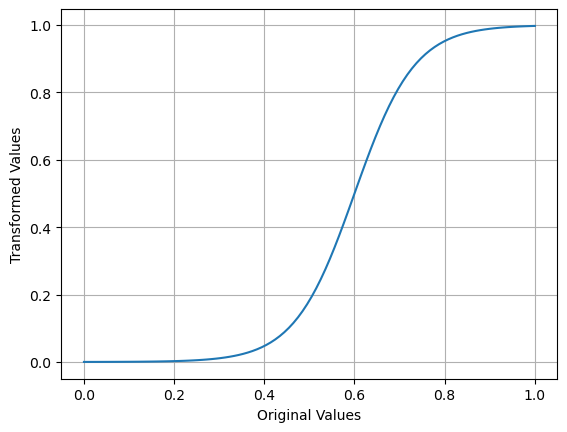

In [116]:
import numpy as np
import matplotlib.pyplot as plt

def transform_values(values):
    return 1 - 1 / (1 + np.exp(15 * (values - 0.6)))

# Generate a sequence of values between 0 and 1
values = np.linspace(0, 1, 100)

# Apply the transformation function
transformed_values = transform_values(values)

# Plot the transformation
plt.plot(values, transformed_values)
plt.xlabel('Original Values')
plt.ylabel('Transformed Values')
plt.grid(True)
plt.show()

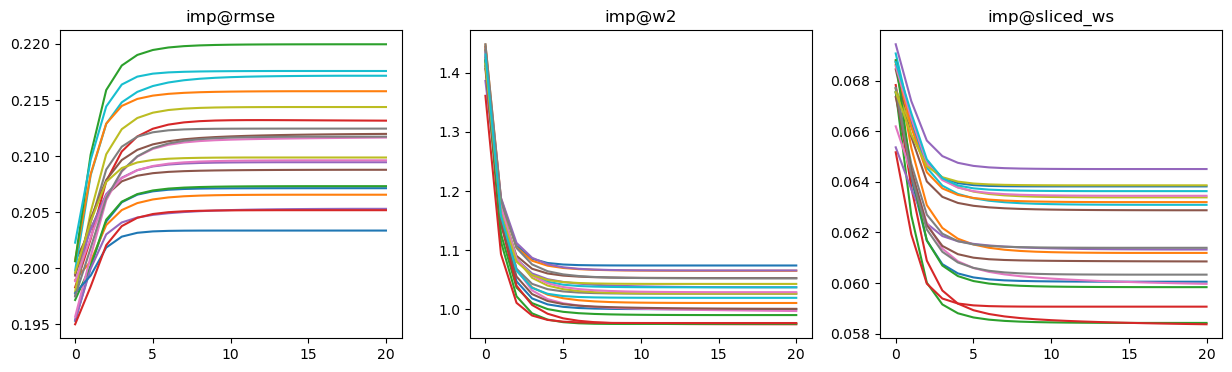

{'imp@rmse': 0.2109149942727615, 'imp@ws': 1.0226367154866451, 'imp@sliced_ws': 0.061636247155269955}
Accuracy imputed centralized MLP:0.5690 (0.009)
Accuracy imputed centralized LR:0.8452 (0.000)


In [ ]:
vis_imp(ret101)
print(ret101['imp_result'])
sklearn_evaluation(ret101)

In [108]:
vis_local_model_sim_lr(tracker0, tracker1, iteration = 1)

client 0 feature 0 - cos_sim between mary left and right local model 0.615036
client 0 feature 1 - cos_sim between mary left and right local model 0.712370
client 0 feature 2 - cos_sim between mary left and right local model 0.759527
client 0 feature 3 - cos_sim between mary left and right local model 0.525078
client 0 feature 4 - cos_sim between mary left and right local model 0.525728
client 0 feature 5 - cos_sim between mary left and right local model 0.745607
client 0 feature 6 - cos_sim between mary left and right local model 0.674075
client 0 feature 7 - cos_sim between mary left and right local model -0.504901
client 0 feature 8 - cos_sim between mary left and right local model 0.302579
client 0 feature 9 - cos_sim between mary left and right local model 0.256061
client 0 feature 10 - cos_sim between mary left and right local model 0.662537
client 0 feature 11 - cos_sim between mary left and right local model 0.924026
client 0 feature 12 - cos_sim between mary left and right loc

#### Local Model

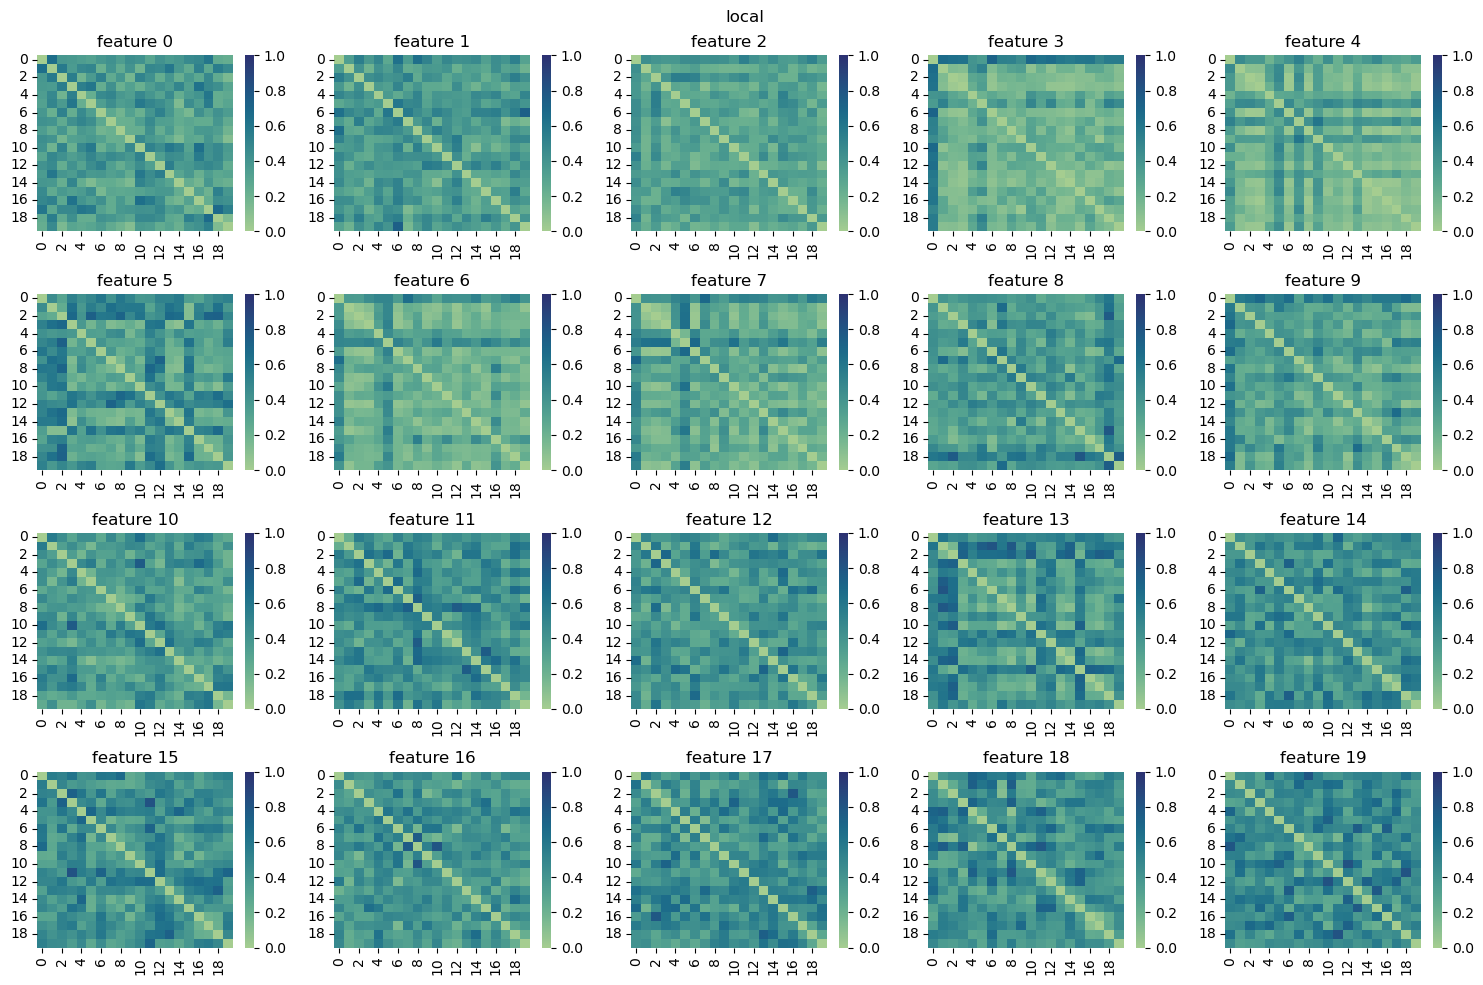

In [801]:
vis_local_model_sim(tracker0, iteration = 20, model='local')

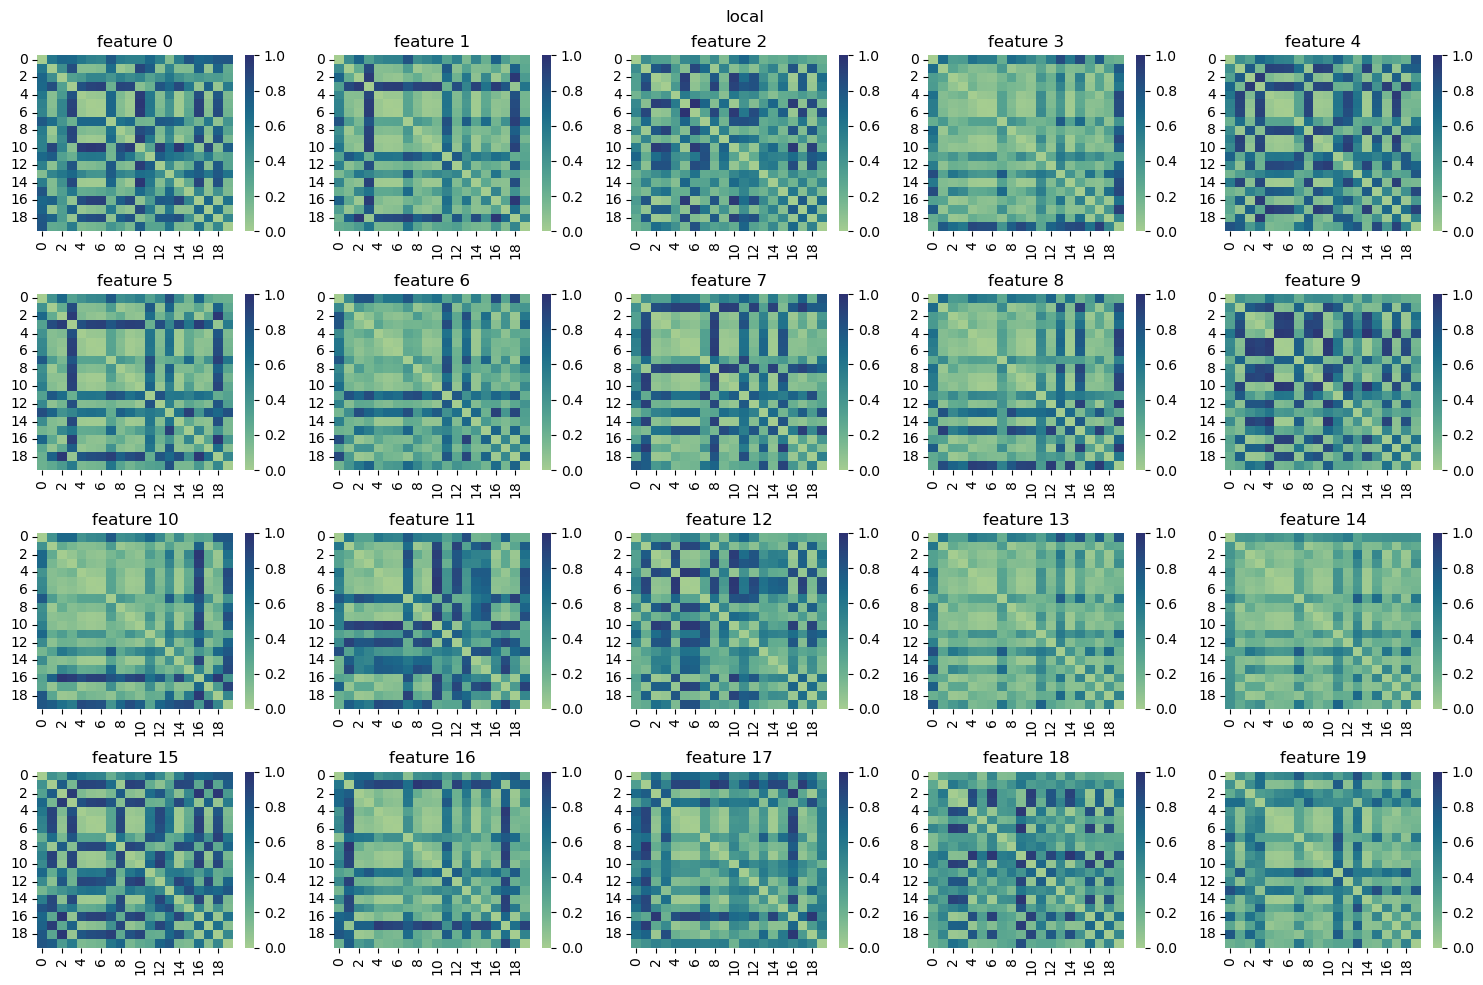

In [715]:
vis_local_model_sim(tracker4, iteration = 20, model='local', metric = 'cos')

In [601]:
coeff = [item for item in tracker4.records if item.feature_idx == 4 and item.iteration == 20][0]
coeff.local_imp_model_params.shape

(20, 20)

In [602]:
modela = coeff.local_imp_model_params[14]
modelb = coeff.local_imp_model_params[19]
print(np.dot(modela, modelb)/(np.linalg.norm(modela)*np.linalg.norm(modelb)))
1 - (np.dot(modela, modelb)/(np.linalg.norm(modela)*np.linalg.norm(modelb)) + 1)/2

-0.7665629970868363


0.8832814985434181

In [603]:
data_t = rets['mnar_lr_local2']['data']['imputed_data']
data_t1 = rets['mnar_lr_local2']['data']['origin_data']
msk_t = rets['mnar_lr_local2']['data']['missing_mask']
data_t = rets['mnar_lr_local2']['data']['imputed_data']
data_t1 = rets['mnar_lr_local2']['data']['origin_data']
msk_t = rets['mnar_lr_local2']['data']['missing_mask']
x14 = data_t[14, :, 4]
x14t = data_t1[14, :, 4]
m14 = msk_t[14, :, 4]
x19 = data_t[19, :, 4]
x19t = data_t1[19, :, 4]
m19 = msk_t[19, :, 4]

In [615]:
np.quantile(x14t, q = 0.5)

0.508101510837643

In [634]:
total_missing = int(missing_ratio * x14t.shape[0])
total_missing

645

In [631]:
end_indices = np.where(x14t == q)[0]
add_up_indices = np.random.choice(
					end_indices, size=total_missing - len(indices), replace=False
				)
na_indices = np.concatenate((indices, add_up_indices))

In [635]:
from src.fed_imp.sub_modules.missing_simulate.ms_simulate.mnar_simulate import simulate_nan_mnar_quantile

In [642]:
X = data_t1[14]
X_imp = simulate_nan_mnar_quantile(X, [4], 0.5, 'right', seed = 1)

In [646]:
msk = np.isnan(X_imp)
x14t = X[:, 4]

<Axes: ylabel='Count'>

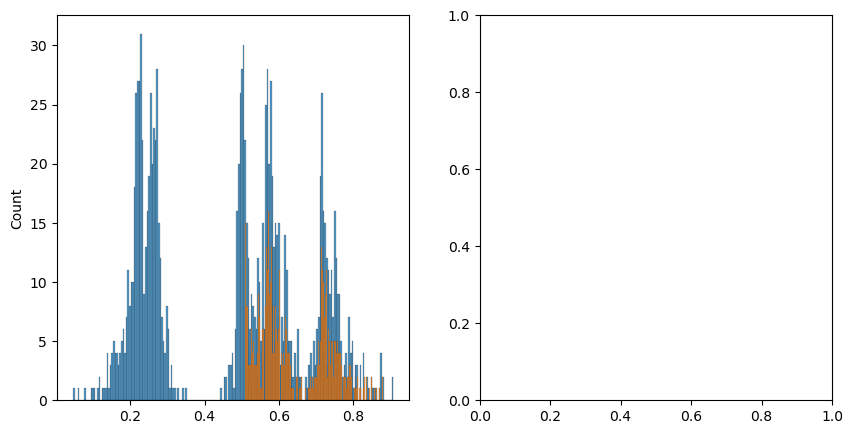

In [649]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
sns.histplot(x = x14t, bins = 200, ax = ax[0])
sns.histplot(x = x14t[msk[:, 4]], bins = 200, ax = ax[0])

<Axes: ylabel='Count'>

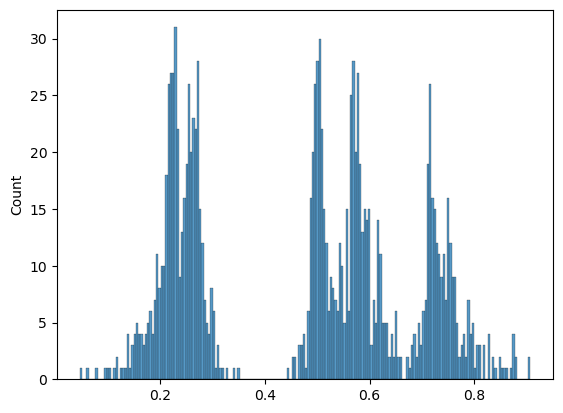

In [606]:
sns.histplot(x = x19t, bins = 200)

In [574]:
data14 = data_t[14]
x = data14[:, :-1]
print(x.shape)
x_ = np.delete(x, 4, axis=1)
x_ = x_[m14 == 1]
print(x_.shape)
x_ = np.concatenate([x_, np.ones(x_.shape[0]).reshape(-1,1)], axis=1)
print(x_.shape)
imputed14 = x_@modela
imputed14_ = x_@modelb
print(imputed14.shape)
print(imputed14_.shape)

(1290, 20)
(650, 19)
(650, 20)
(650,)
(650,)


In [577]:
print(np.mean(abs(imputed14 - x14[m14])))
print(np.mean(abs(imputed14_ - x14[m14])))

0.0009407086610696447
0.27718427230024695


In [559]:
data19 = data_t[19]
x1 = data19[:, :-1]
print(x1.shape)
x1_ = np.delete(x1, 4, axis=1)
print(x1_.shape)
x1_ = np.concatenate([x1_, np.ones(x1_.shape[0]).reshape(-1,1)], axis=1)
print(x1_.shape)
imputed19 = x1_@modelb
imputed19_ = x1_@modela
print(imputed19.shape)

(1290, 20)
(1290, 19)
(1290, 20)
(1290,)


In [553]:
data_t = rets['mnar_lr_local2']['data']['imputed_data']
data_t1 = rets['mnar_lr_local2']['data']['origin_data']
msk_t = rets['mnar_lr_local2']['data']['missing_mask']
x14 = data_t[14, :, 4]
x14t = data_t1[14, :, 4]
m14 = msk_t[14, :, 4]
x19 = data_t[19, :, 4]
x19t = data_t1[19, :, 4]
m19 = msk_t[19, :, 4]

In [587]:
print(np.mean(imputed14 - x14[m14]))
print(np.mean(imputed14_ - x14[m14]))
# print(np.mean(imputed19_[m19] - x19[m19]))
# print(np.mean(imputed14 - x14t))
# print(np.mean(imputed14_ - x14t))
# print(np.mean(imputed19 - x19t))
abs(x14 - x19)[m14&m19][0:10]

-7.997146616176172e-05
0.011285173673500577


array([0.19332482, 0.14889582, 0.23502049, 0.2244214 , 0.14421803,
       0.14190096, 0.15927668, 0.12195078, 0.09475234, 0.08357951])

In [571]:
print(x_[m14][0:10]@modela)
print(x_[m14][0:10]@modelb)

[0.22733894 0.34543996 0.48686648 0.50337852 0.66328734 0.32248817
 0.46773045 0.22217764 0.36629912 0.43619056]
[-0.03119907  0.96108286 -0.01190617  0.17546759  0.32601026  0.49384357
  0.71598779  0.04918428  0.98419777  0.46419465]


In [506]:
np.mean(x19[(m19==1)&(m14==1)] - x14[(m19==1)&(m14==1)])

-0.009311017329282724

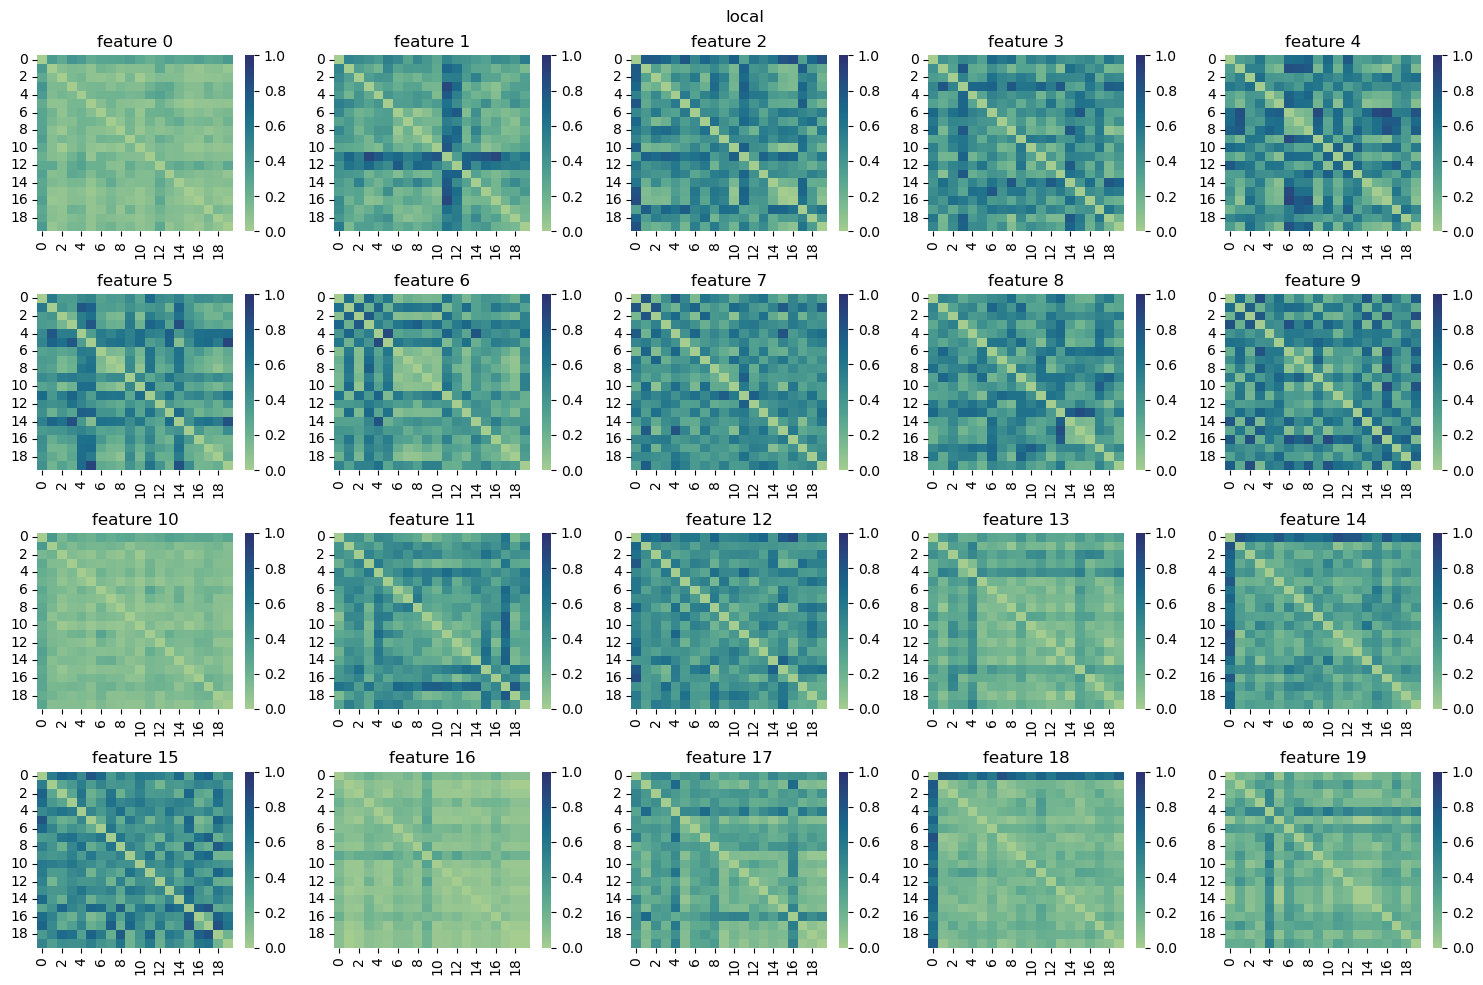

In [303]:
vis_local_model_sim(tracker0, iteration = 4, model='local')

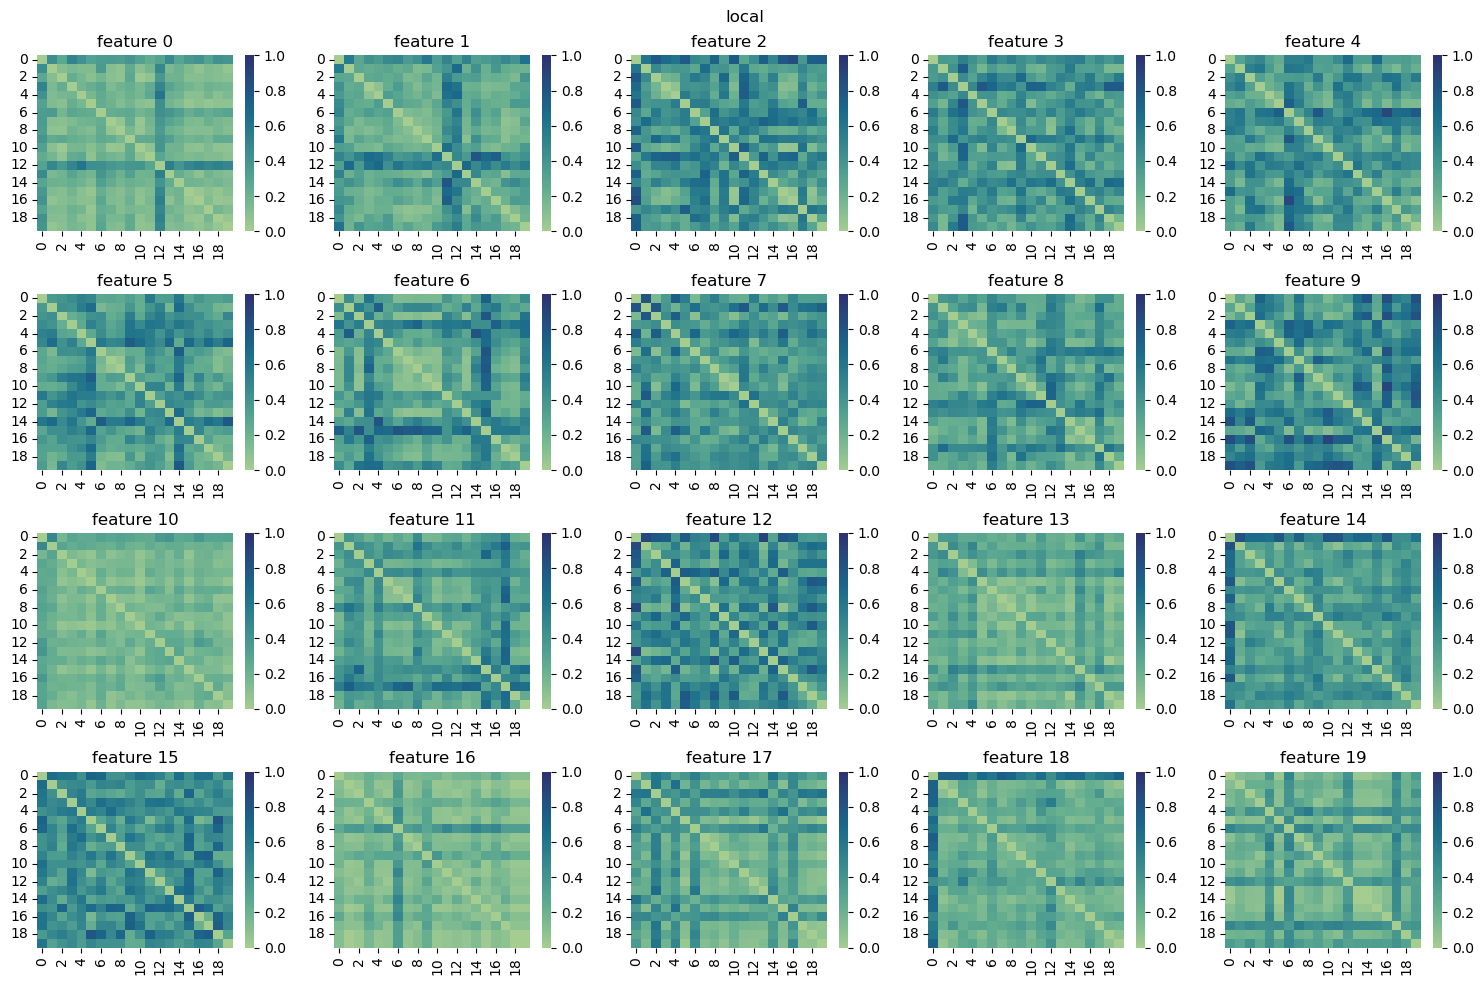

In [304]:
vis_local_model_sim(tracker0, iteration = 20, model='local')

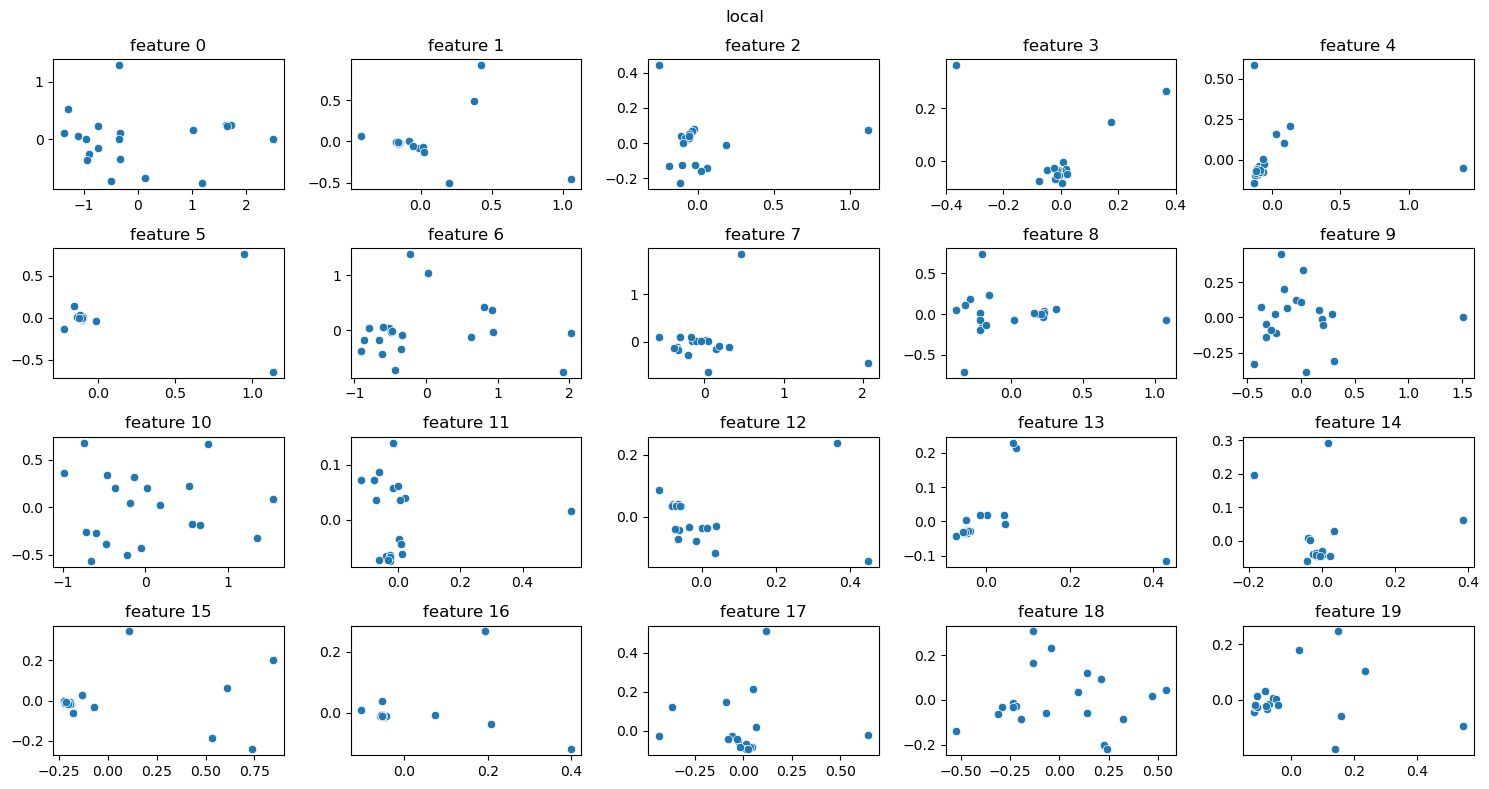

In [187]:
vis_local_model(tracker, iteration = 1, model = 'local', decomp = 'PCA')

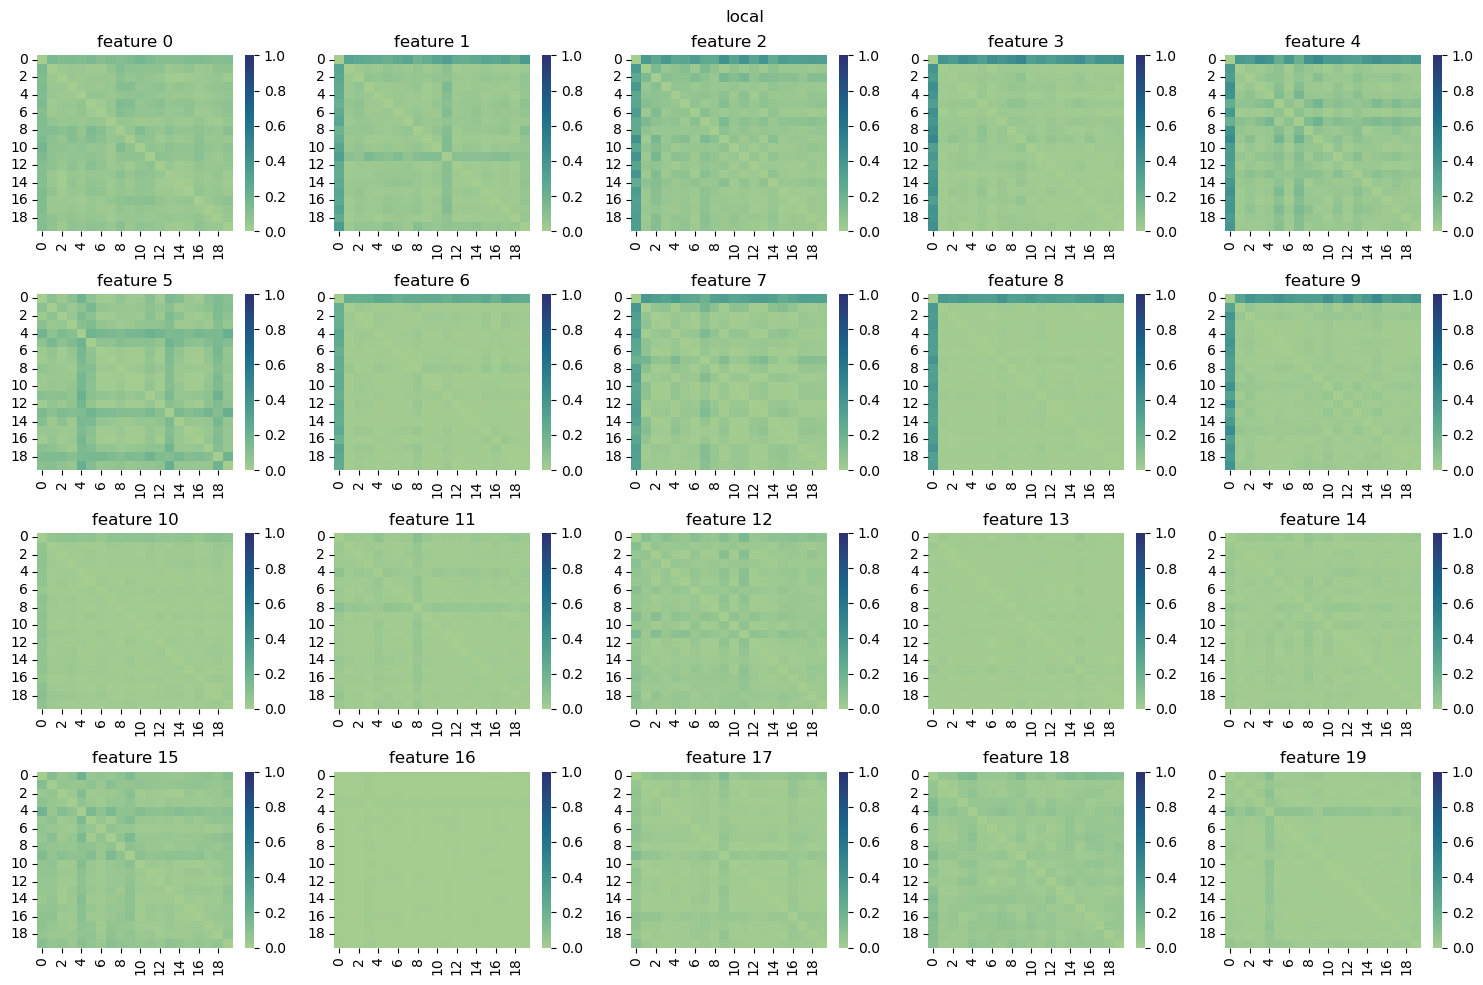

In [802]:
vis_local_model_sim(tracker, iteration = 1, model = 'local')

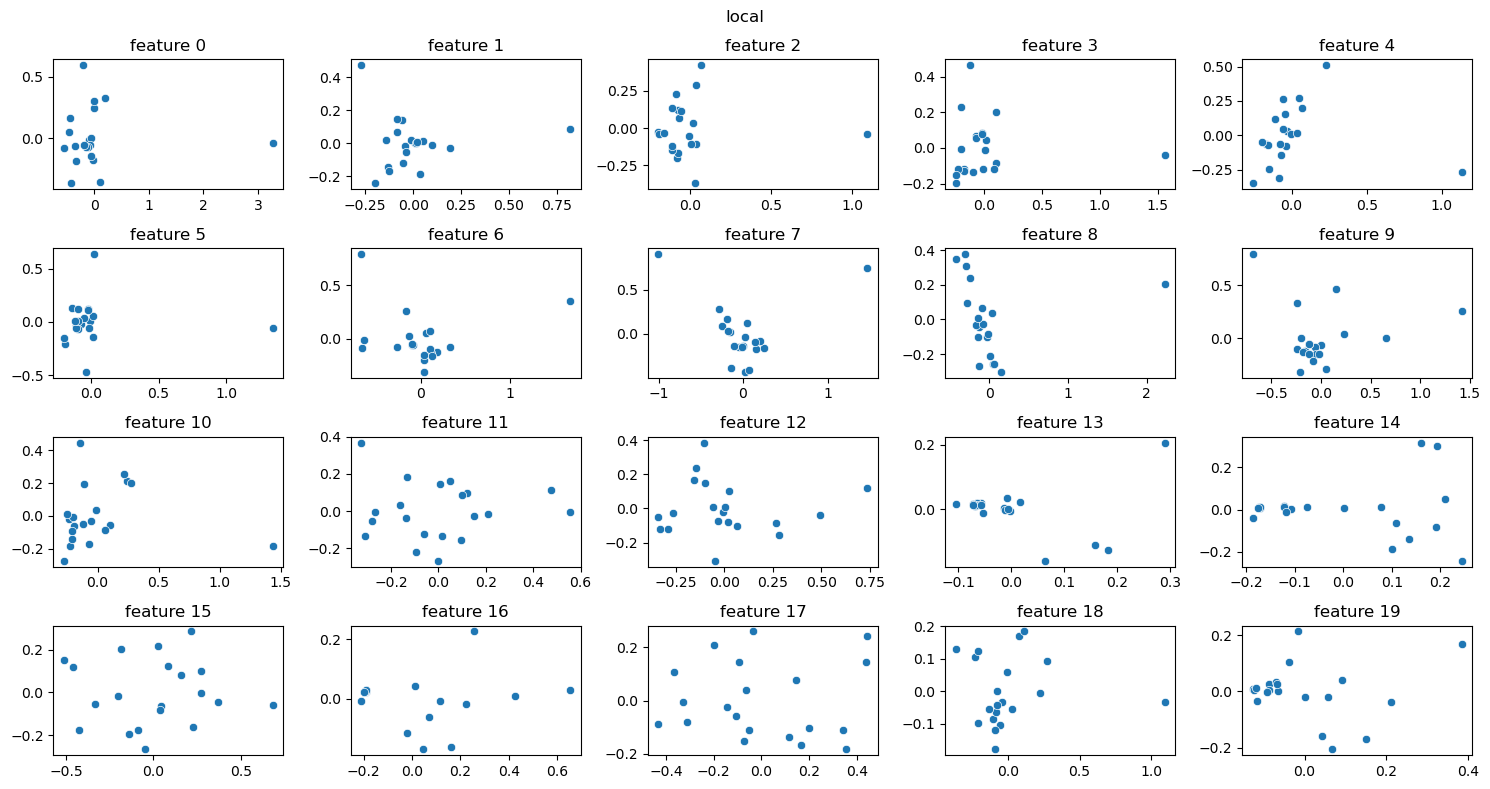

In [190]:
vis_local_model(tracker, iteration = 20, model = 'local', decomp = 'PCA')

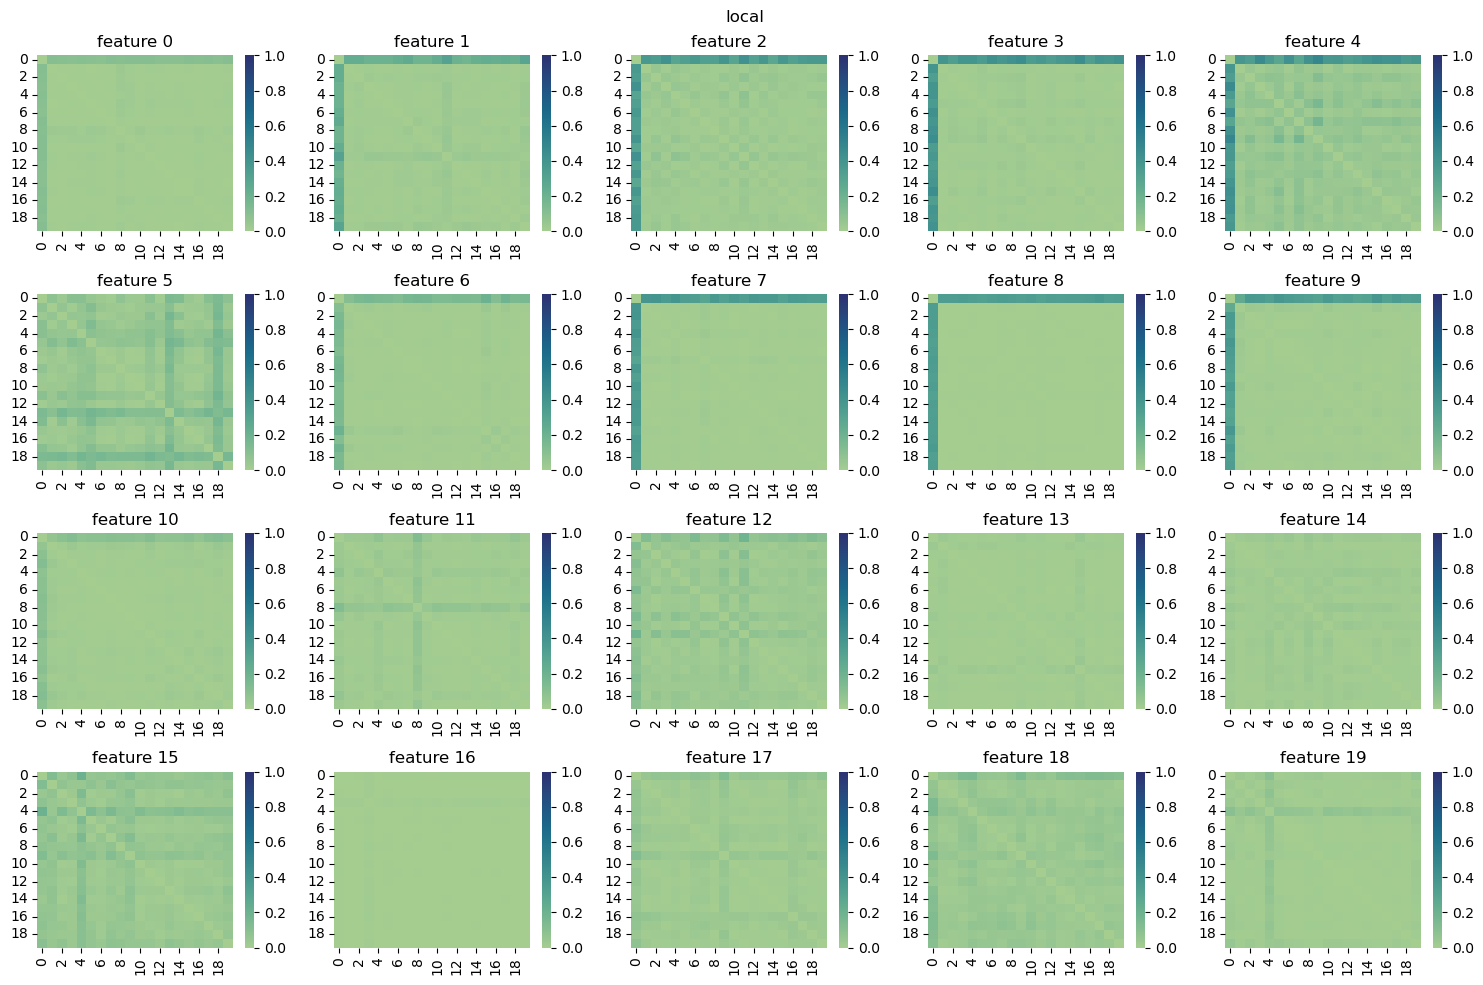

In [803]:
vis_local_model_sim(tracker, iteration = 20, model = 'local')

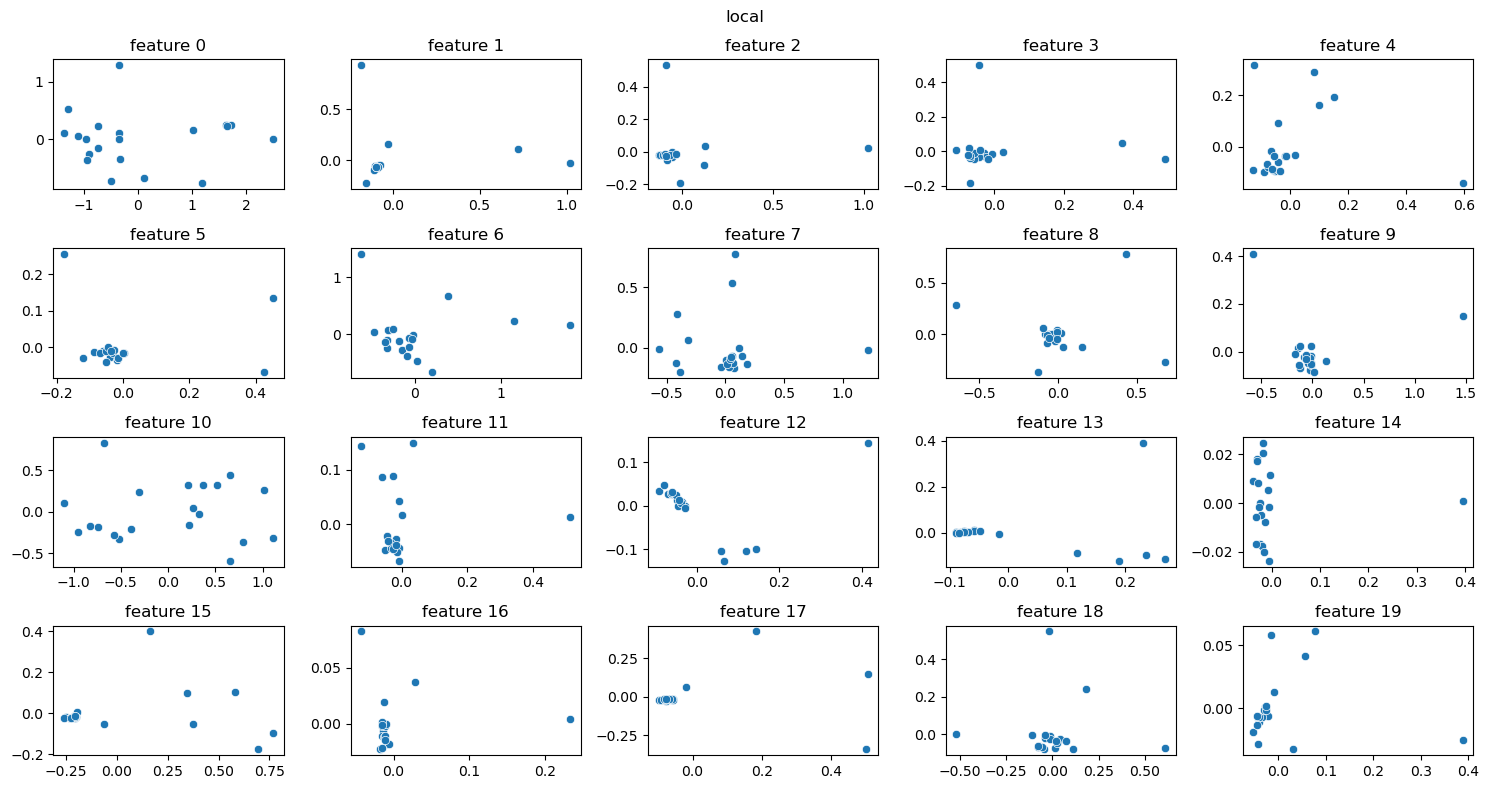

In [232]:
vis_local_model(tracker2, iteration = 1, model = 'local', decomp = 'PCA')

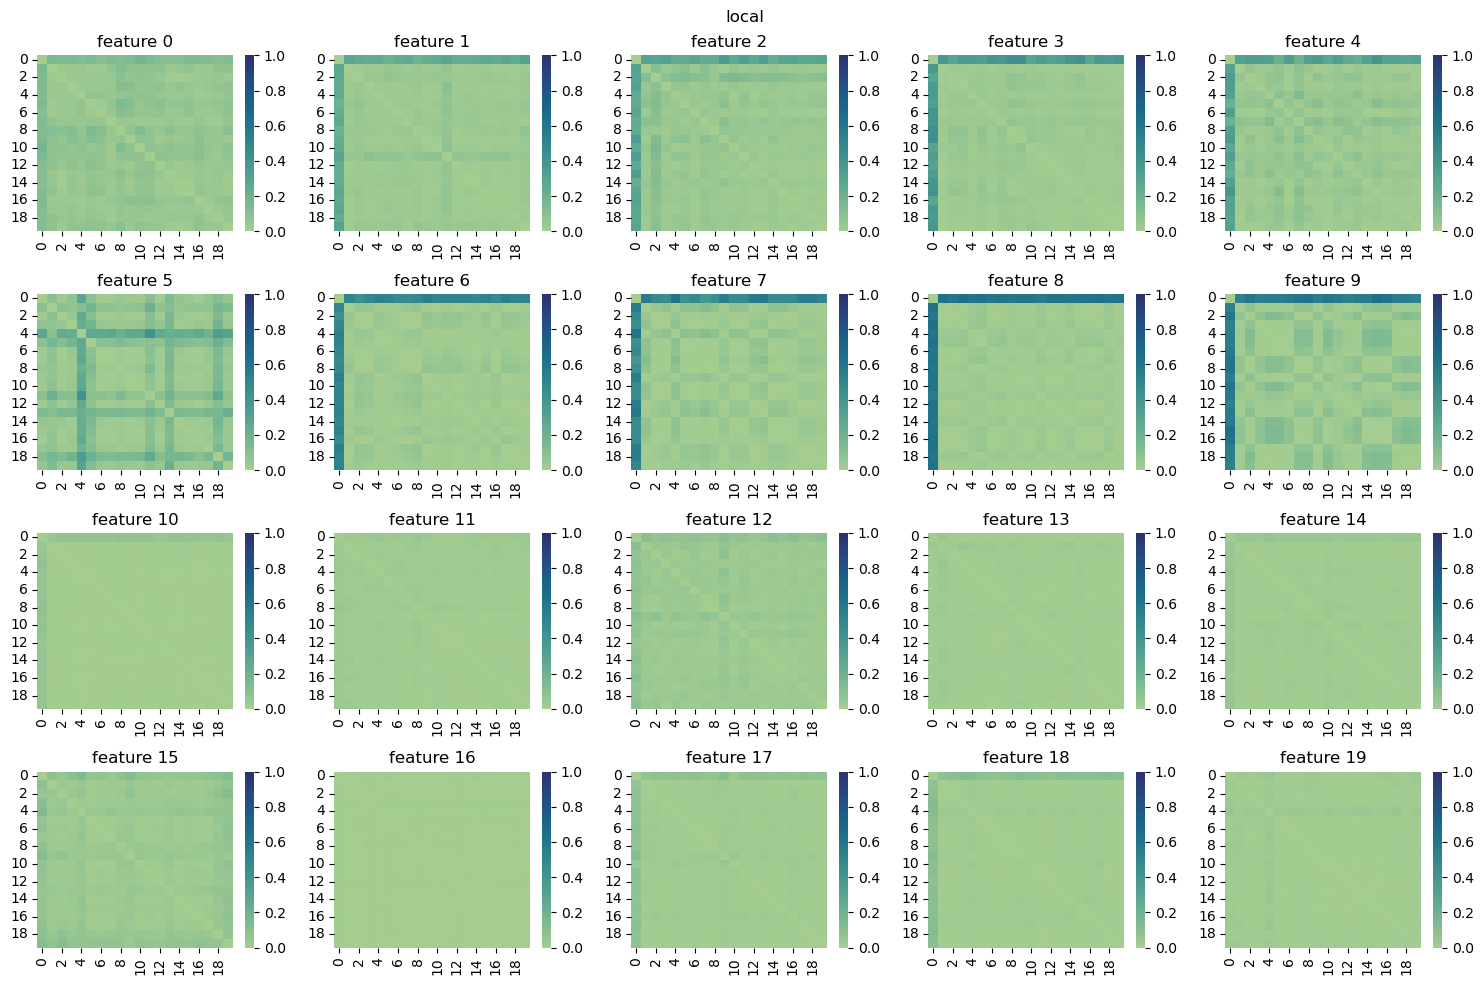

In [804]:
vis_local_model_sim(tracker2, iteration = 1, model = 'local')

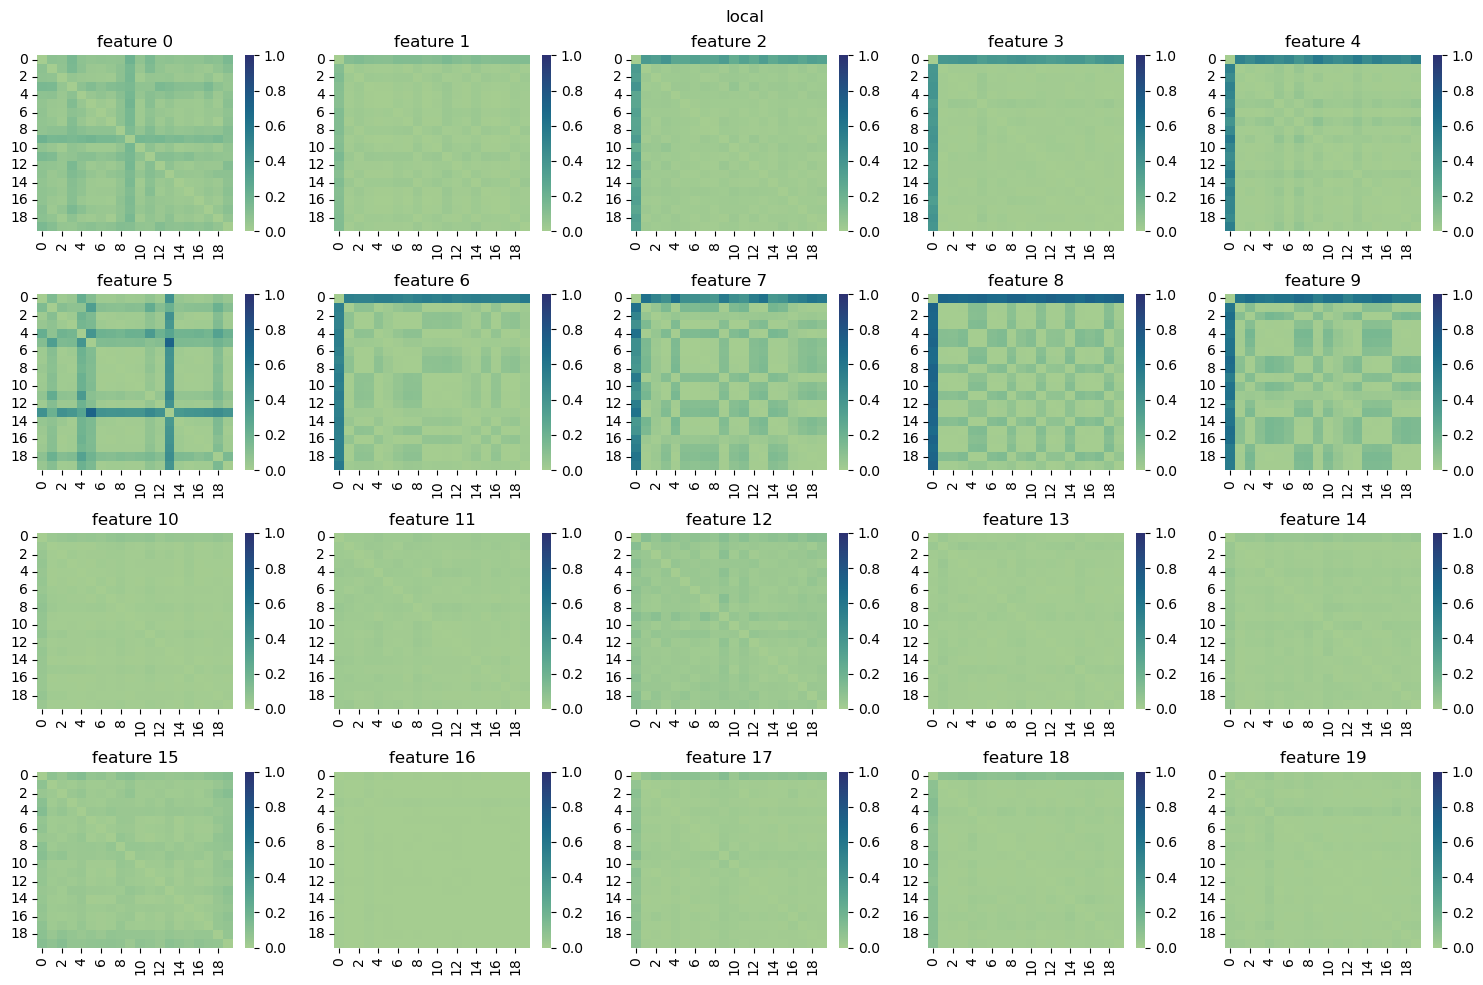

In [805]:
vis_local_model_sim(tracker2, iteration = 5, model = 'local')

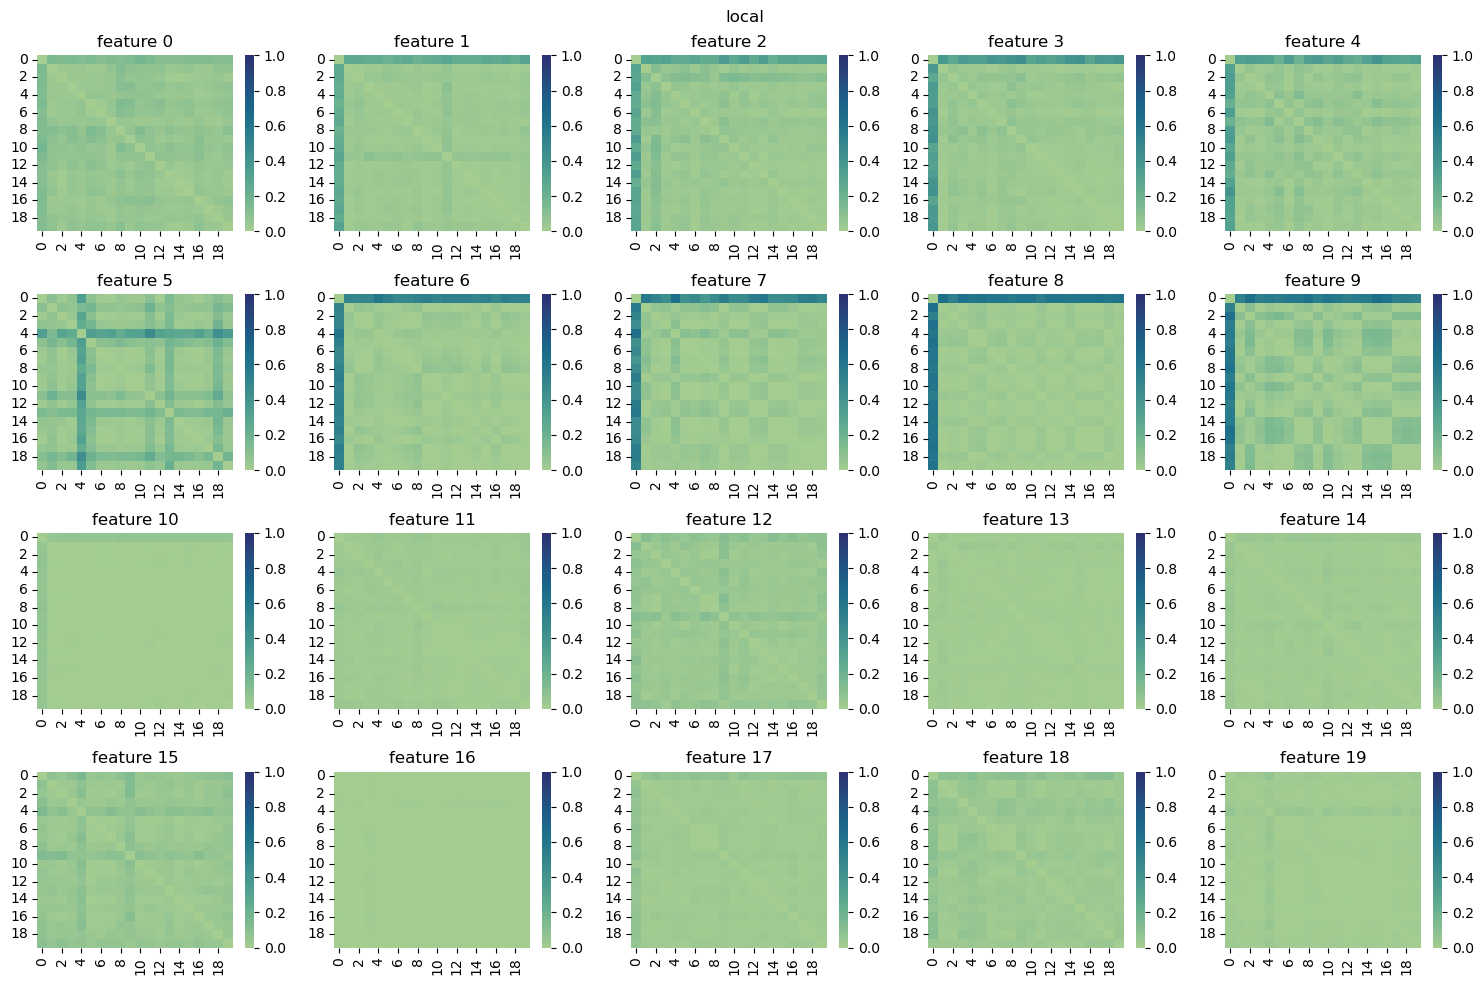

In [806]:
vis_local_model_sim(tracker3, iteration = 1, model='local')

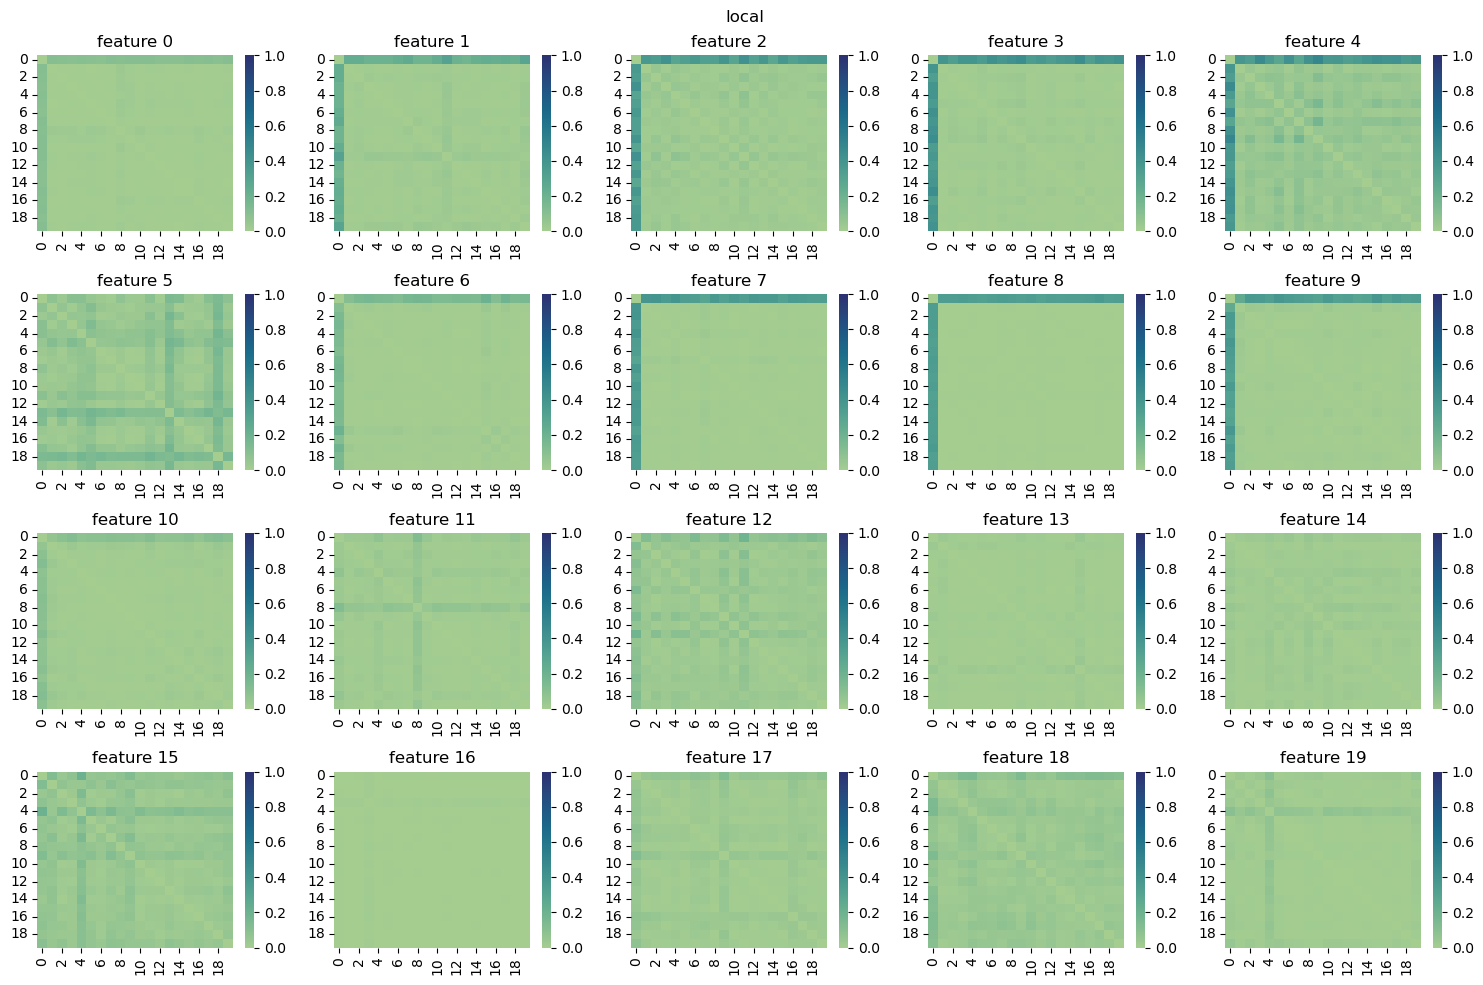

In [807]:
vis_local_model_sim(tracker, iteration = 20, model = 'local')

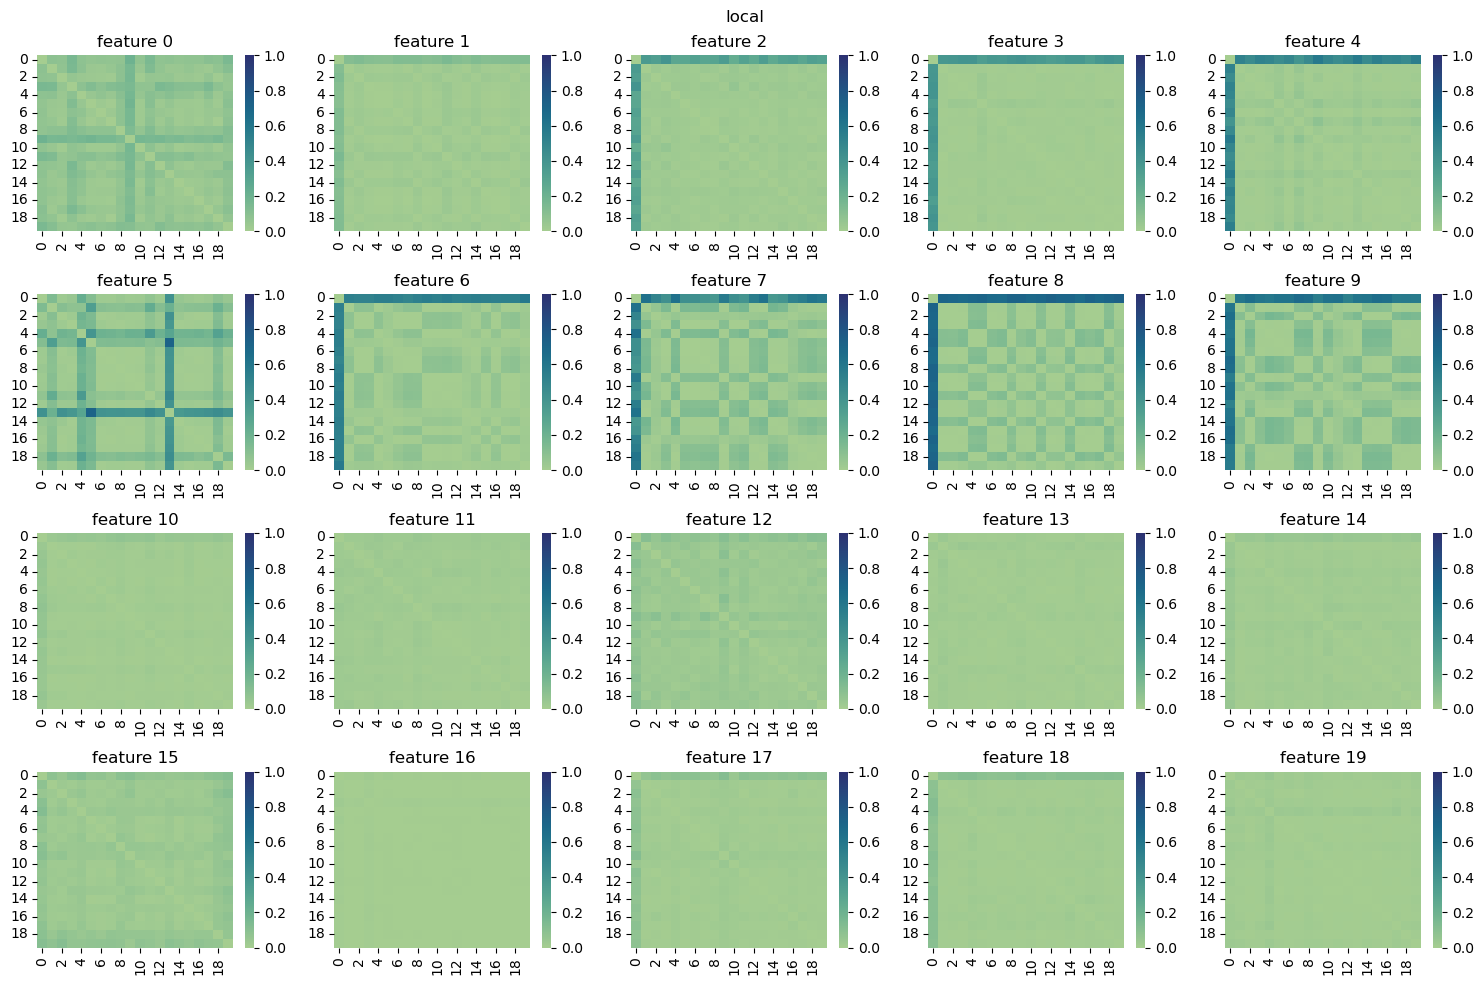

In [808]:
vis_local_model_sim(tracker2, iteration = 20, model = 'local')

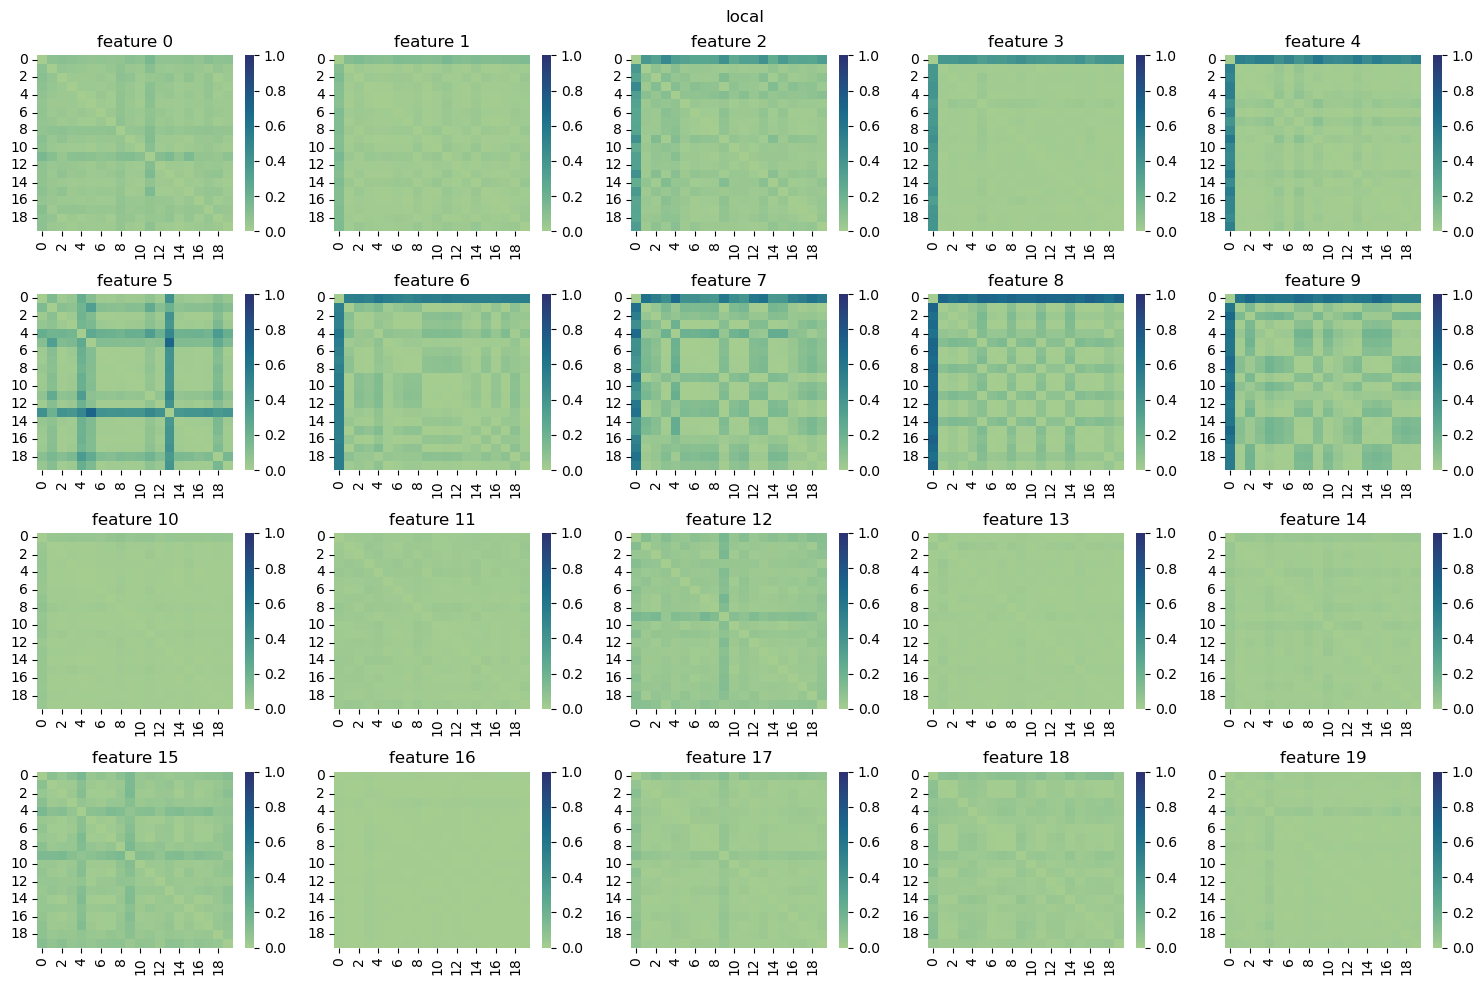

In [809]:
vis_local_model_sim(tracker3, iteration = 20, model = 'local')

#### Debug

In [221]:
def calculate_dis(iteration, tracker1, tracker2, what = 'data_imp'):
    n = 20
    if what == 'data_imp':
        for i in range(n):
            print(np.linalg.norm(tracker1.client_infos[i].data_imp[iteration] - tracker2.client_infos[i].data_imp[iteration]))
    elif what == 'local_model':
        for feature_idx in range(20):
            record1 = [item for item in tracker1.records if item.iteration == iteration and item.feature_idx == feature_idx][0]
            record2 = [item for item in tracker2.records if item.iteration == iteration and item.feature_idx == feature_idx][0]
            print(np.linalg.norm(record1.local_imp_model_params - record2.local_imp_model_params))

In [218]:
calculate_dis(0, tracker, tracker2)

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


In [224]:
calculate_dis(1, tracker, tracker2, what = 'local_model')

0.0
1.6337764897152576
1.5702846497335994
0.5004458163916409
1.3448007010580283
1.9703069642747753
7.092822298471598
4.107754167615582
2.3113705599253667
2.6584593576326214
3.5720236606869196
0.6173539228937241
0.8044787428567401
0.5814388400454863
0.5877724712278766
1.1204952547227718
0.7345322421861542
1.1153722099686756
2.1486559810471793
0.793473354314416


#### Mechanism Model

##### Local

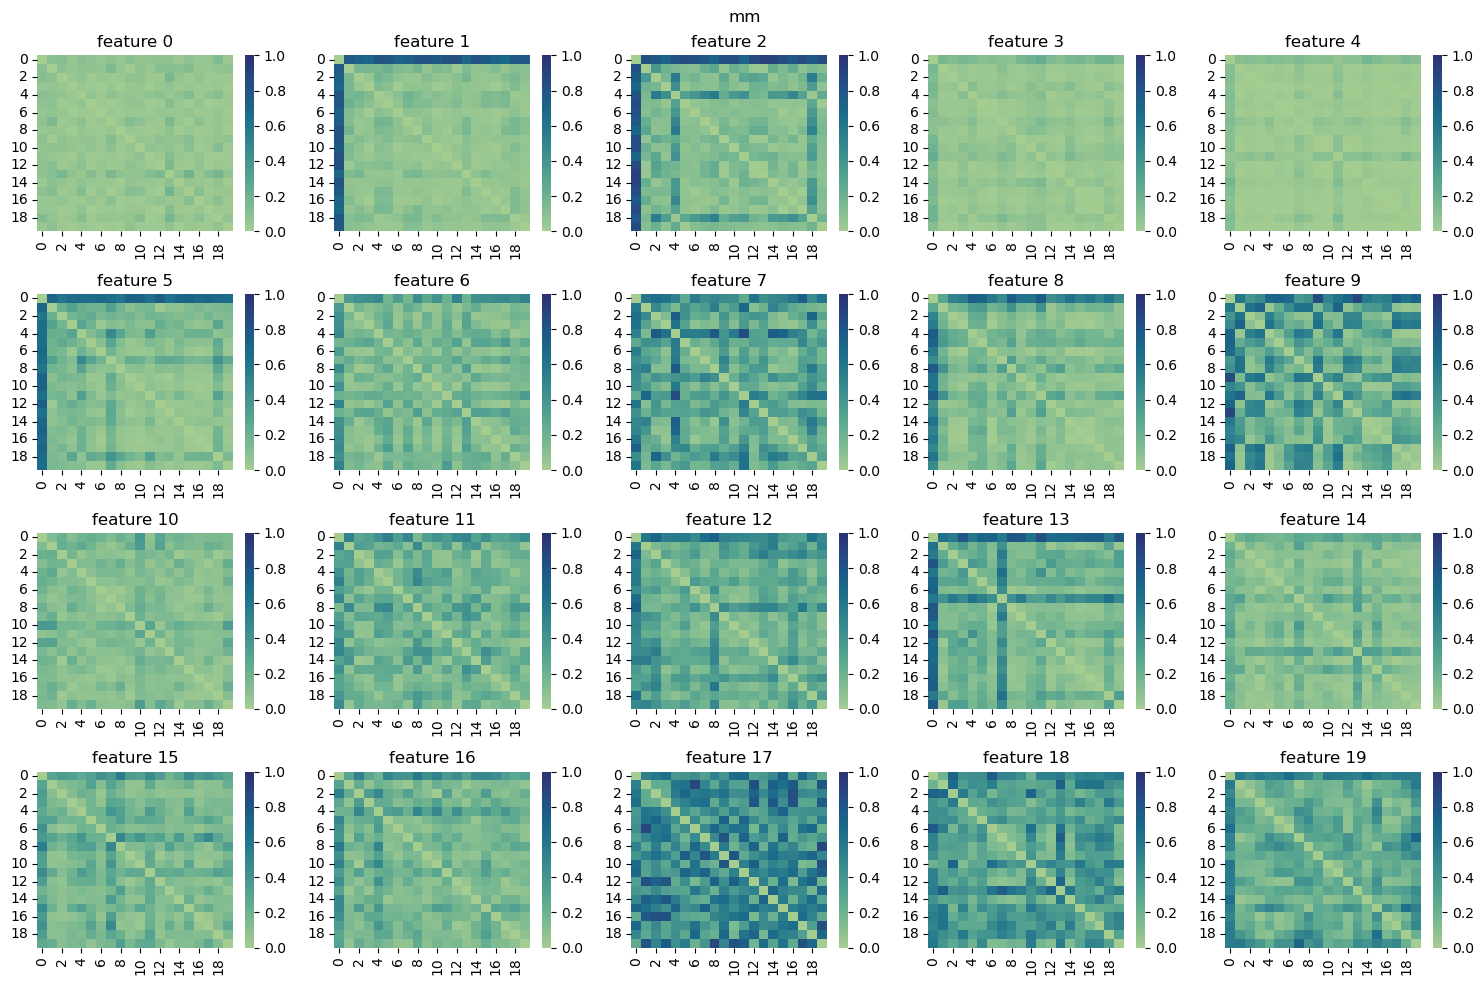

In [810]:
vis_local_model_sim(tracker0, iteration = 1, model = 'mm')

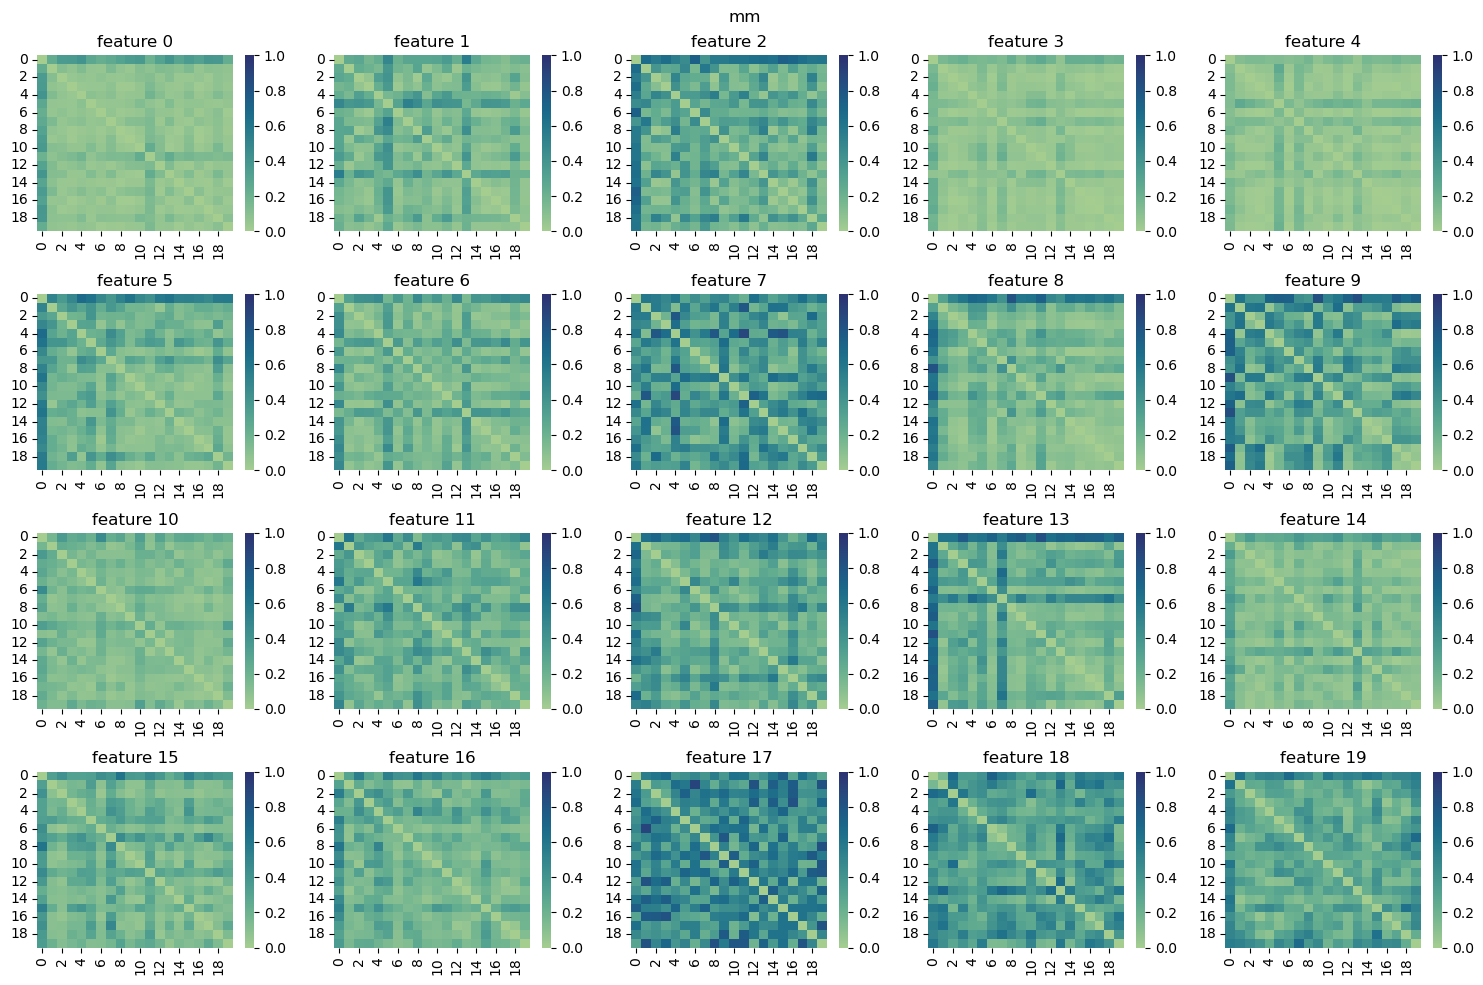

In [811]:
vis_local_model_sim(tracker0, iteration = 4, model = 'mm')

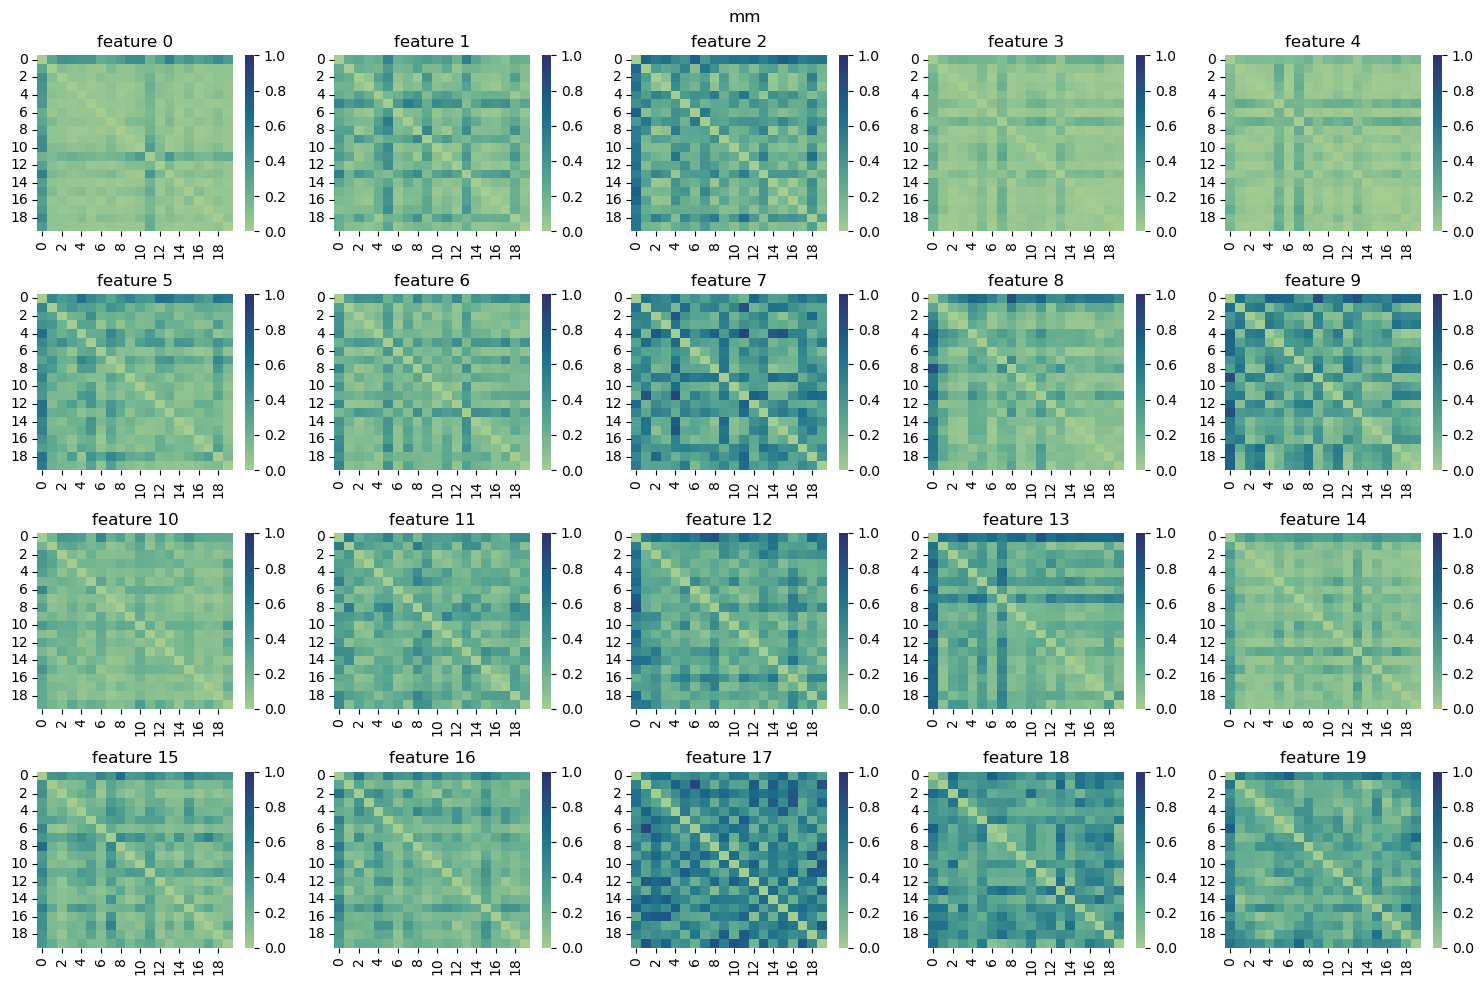

In [812]:
vis_local_model_sim(tracker0, iteration = 20, model='mm')

##### SimpleAVG

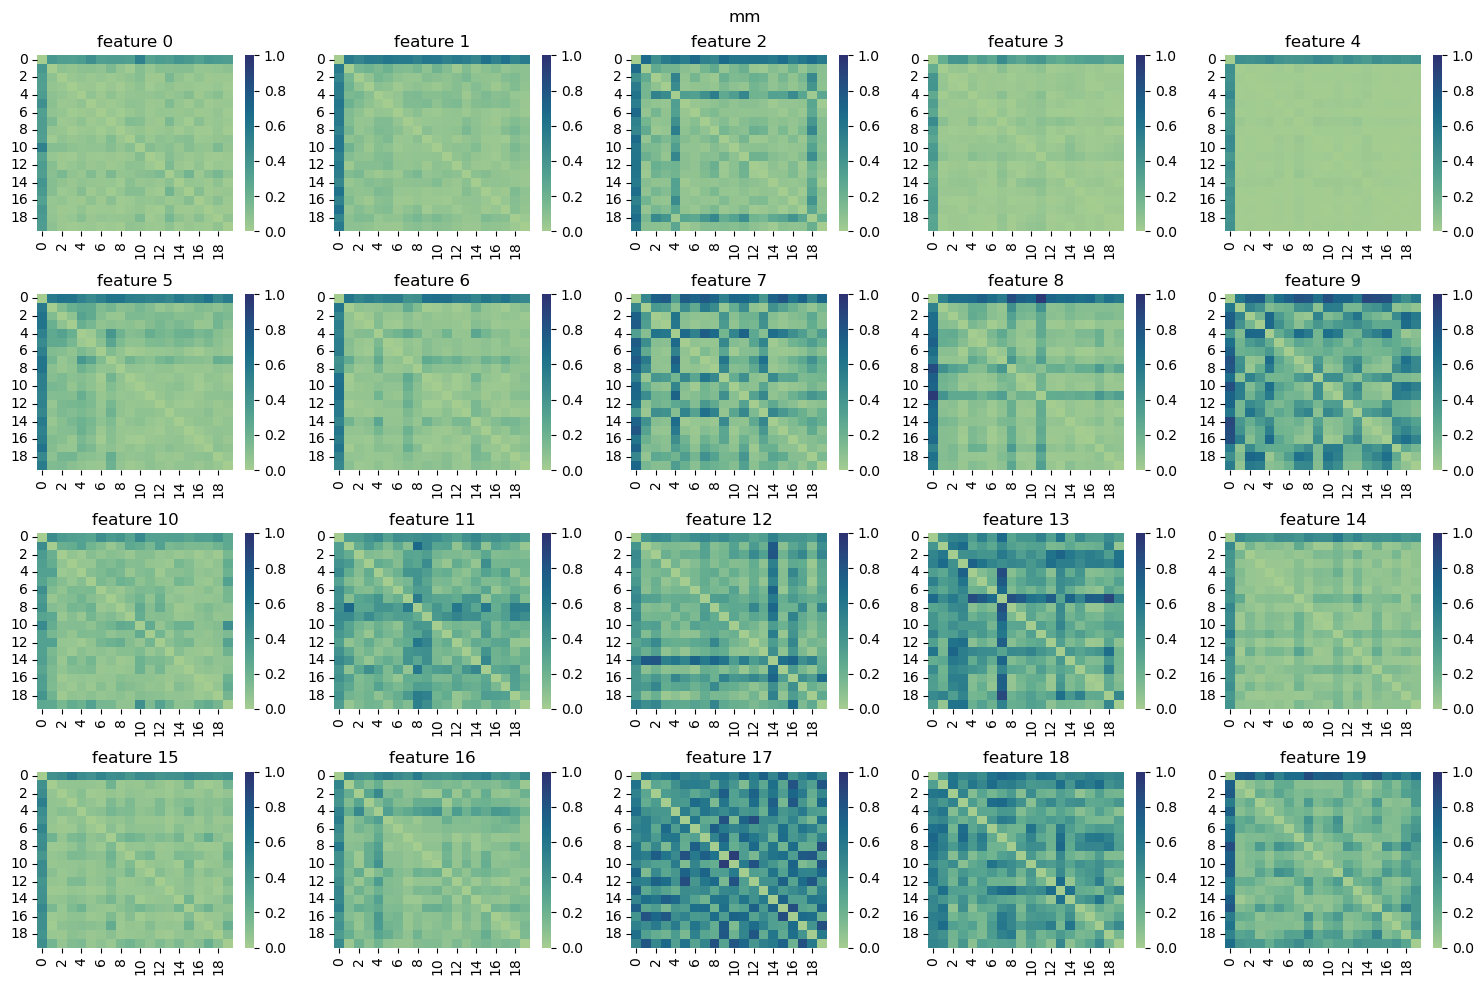

In [813]:
vis_local_model_sim(tracker, iteration = 1, model='mm')

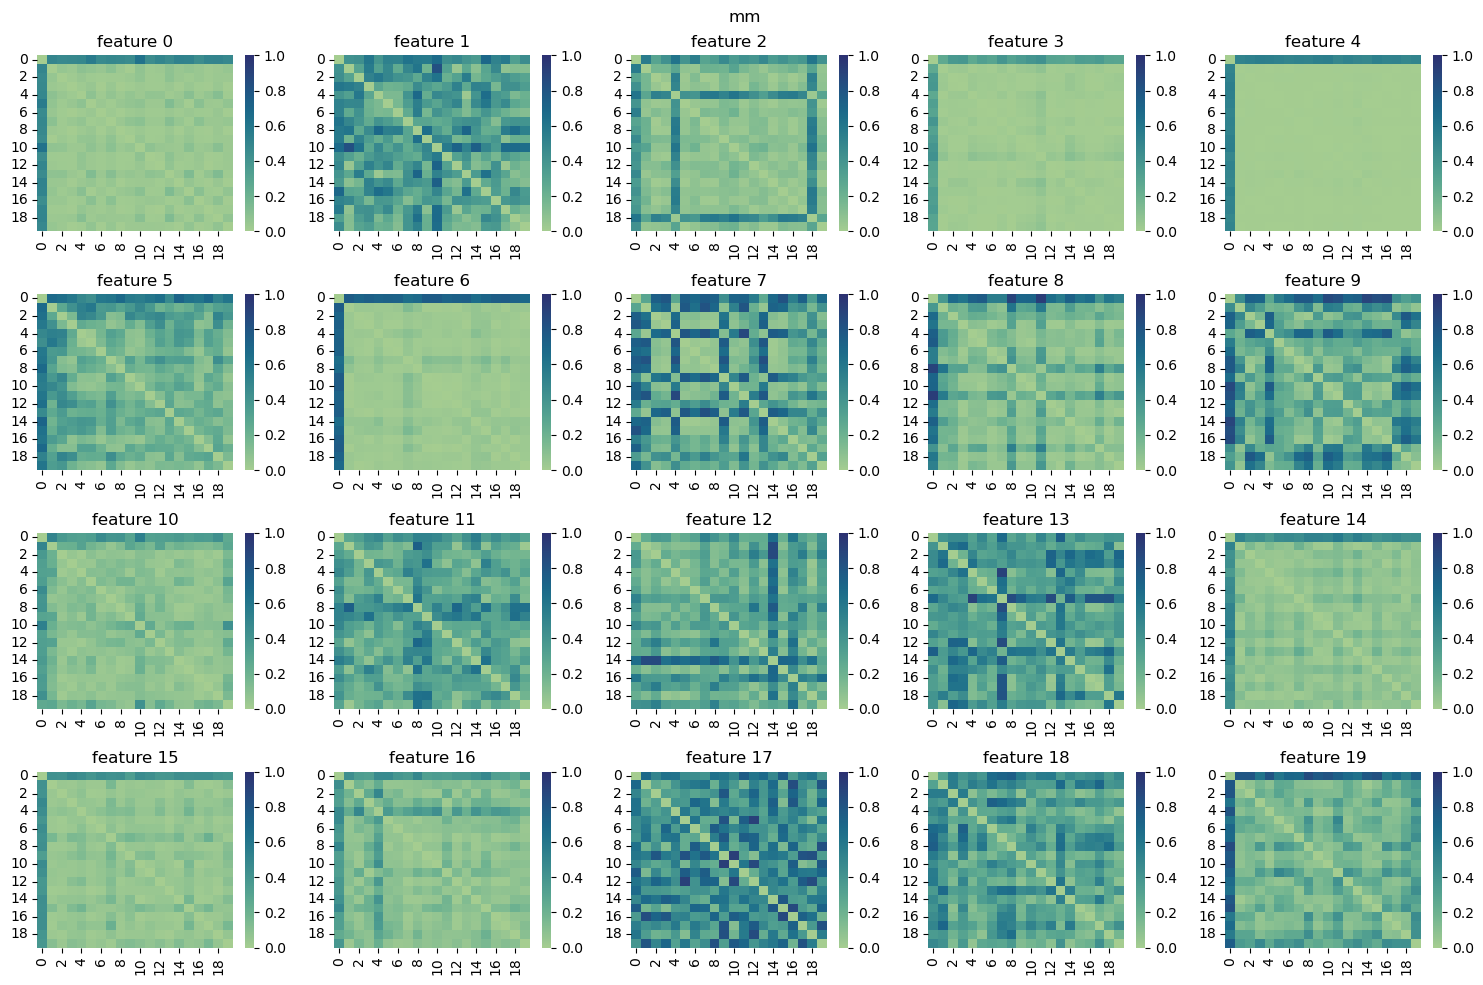

In [814]:
vis_local_model_sim(tracker, iteration = 3, model='mm')

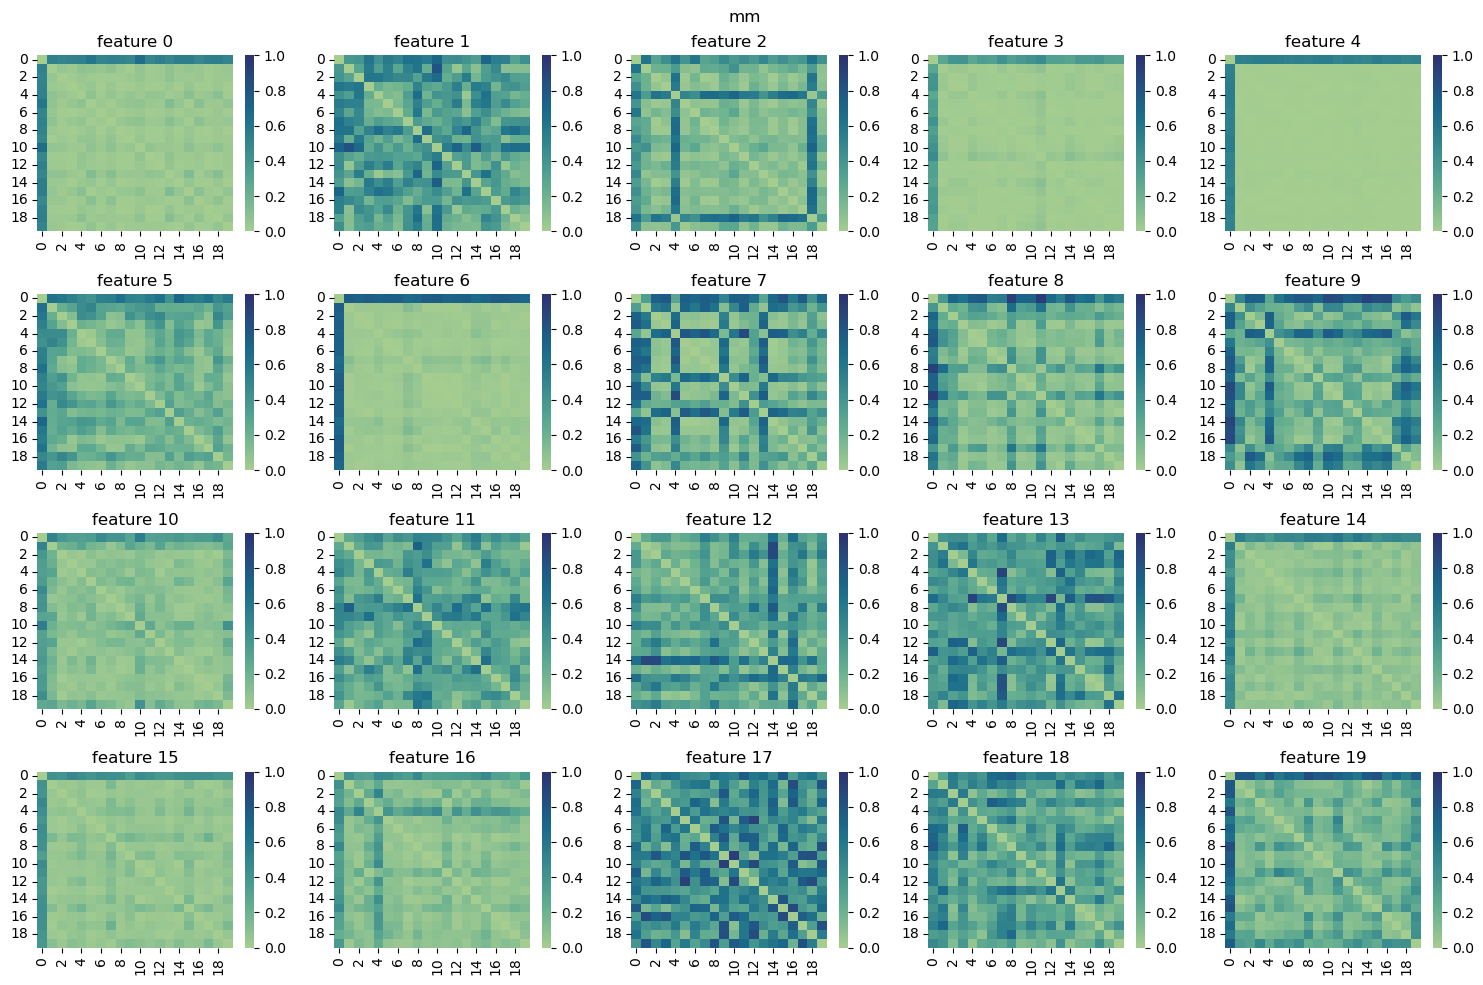

In [815]:
vis_local_model_sim(tracker, iteration = 5, model='mm')

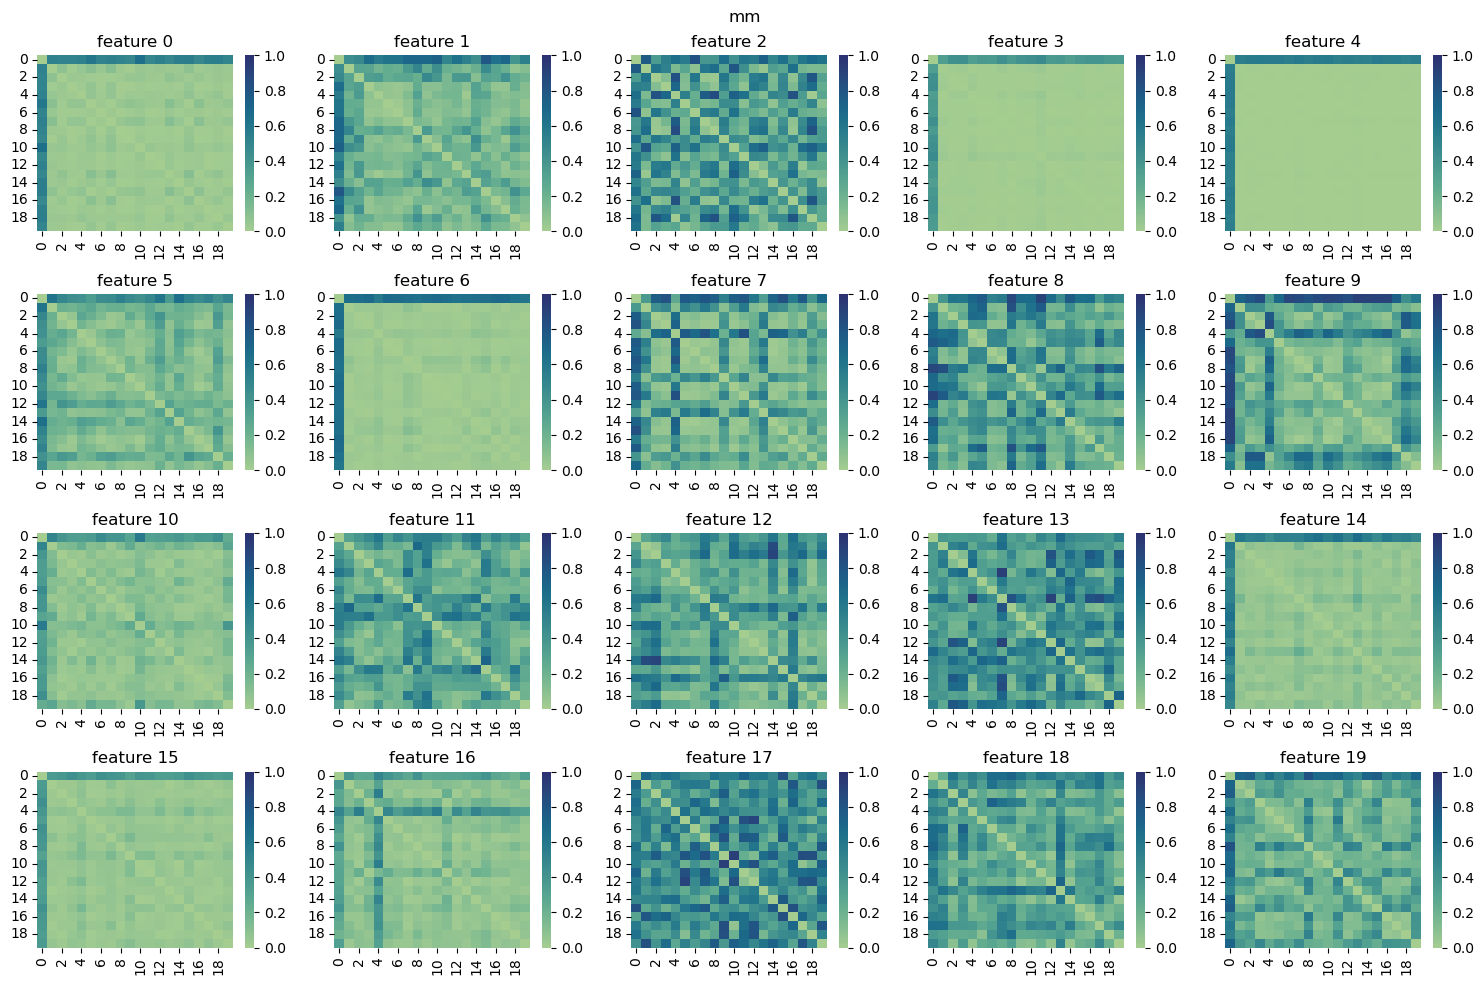

In [816]:
vis_local_model_sim(tracker, iteration = 20, model='mm')

##### Complementary

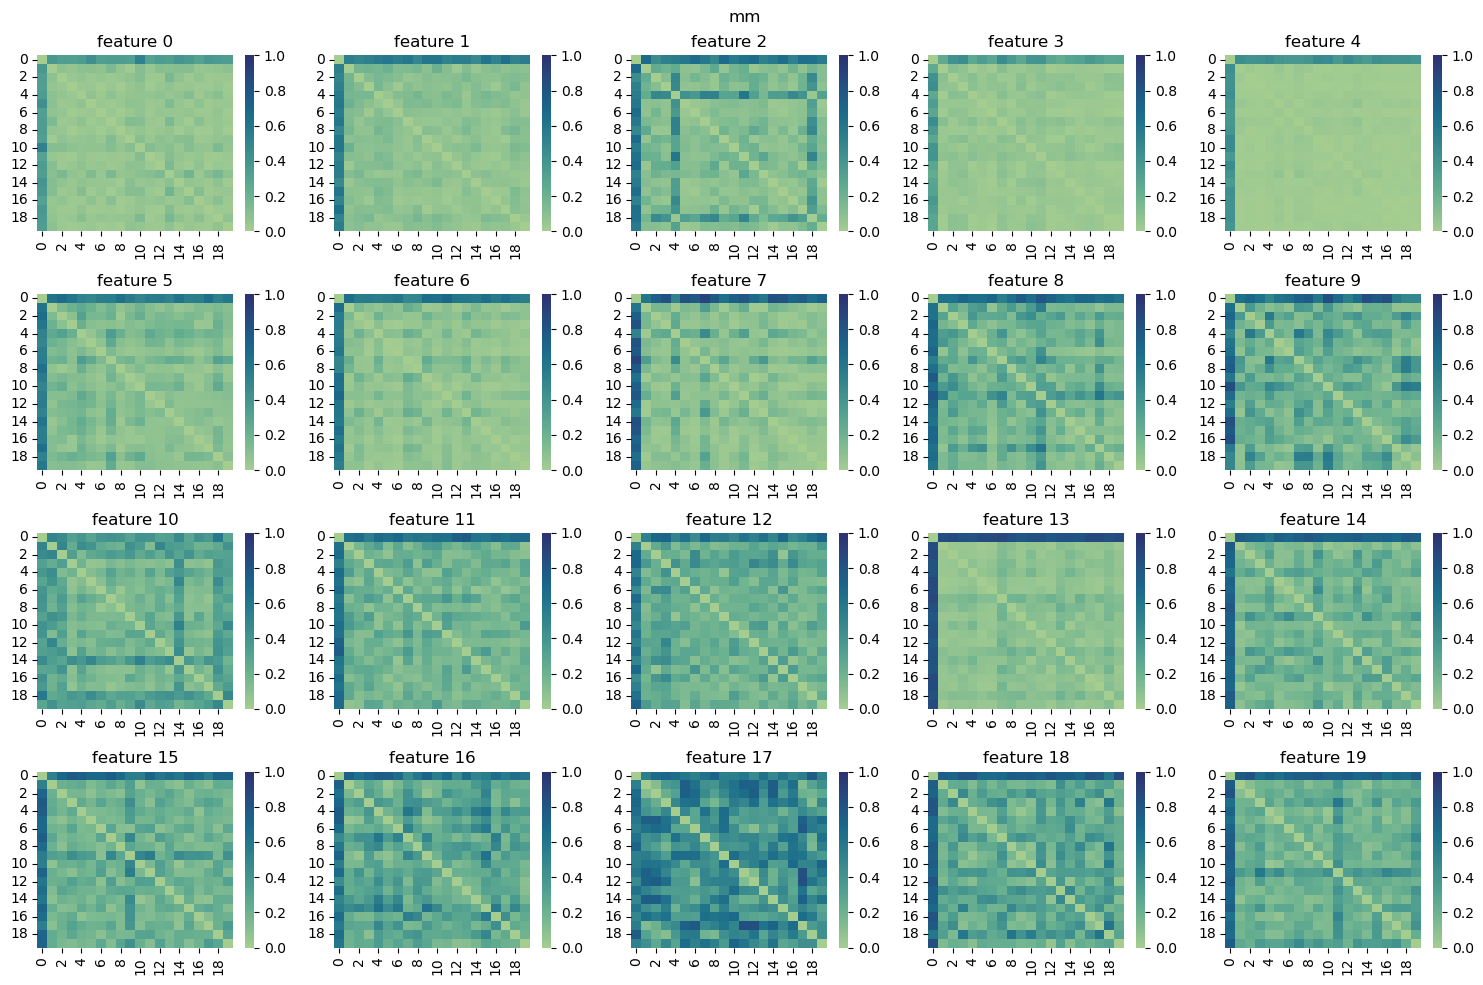

In [817]:
vis_local_model_sim(tracker2, iteration = 1, model='mm')

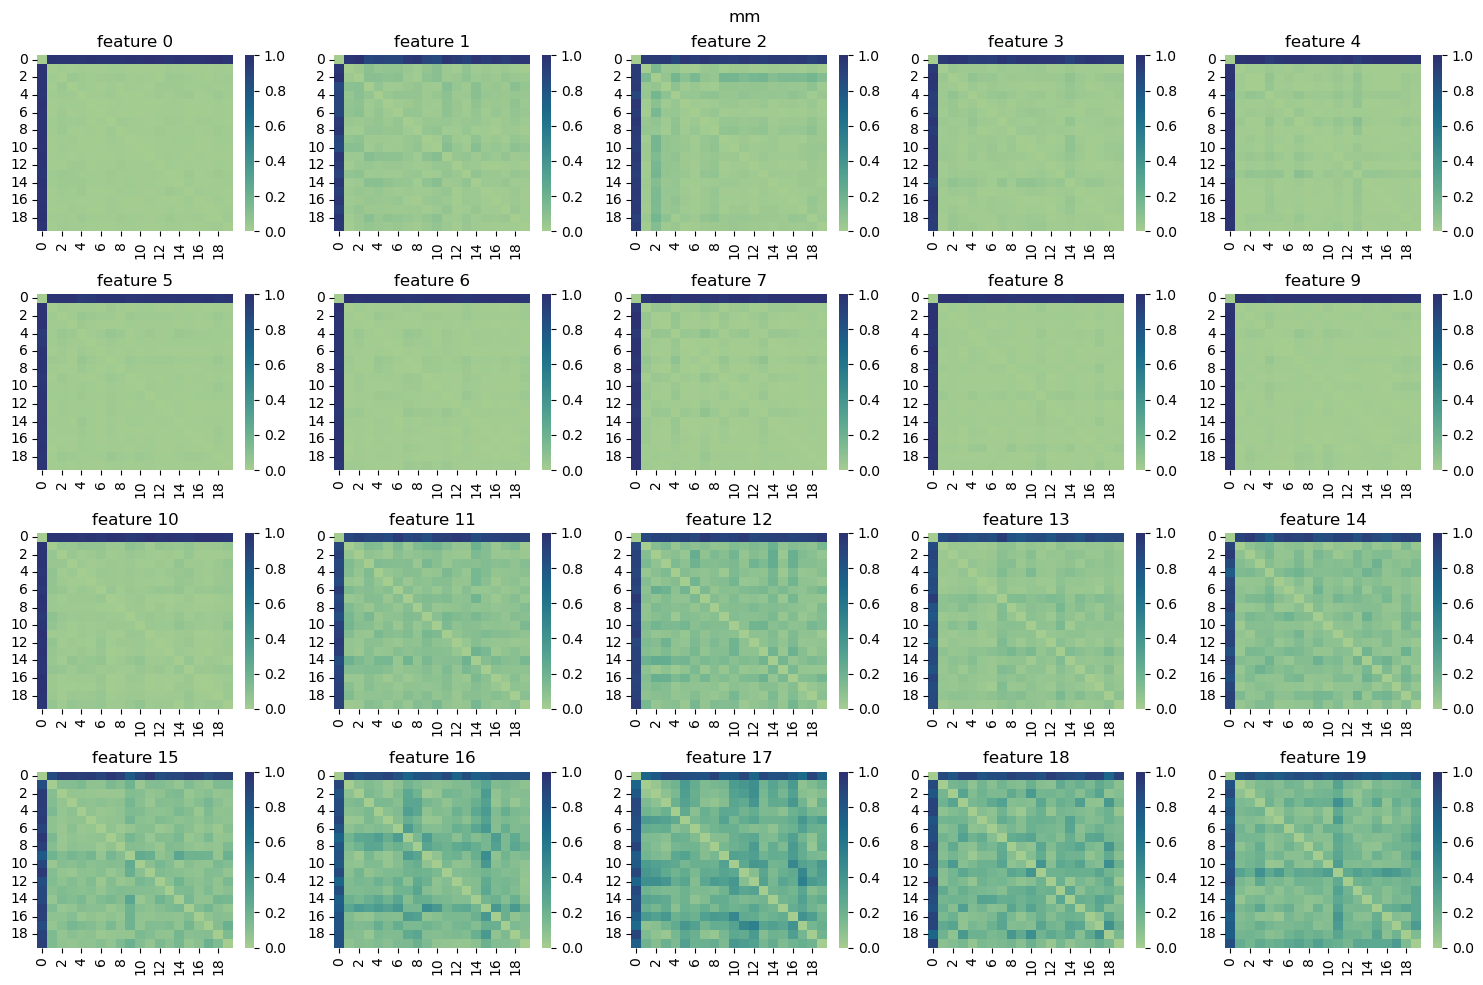

In [818]:
vis_local_model_sim(tracker2, iteration = 5, model='mm')

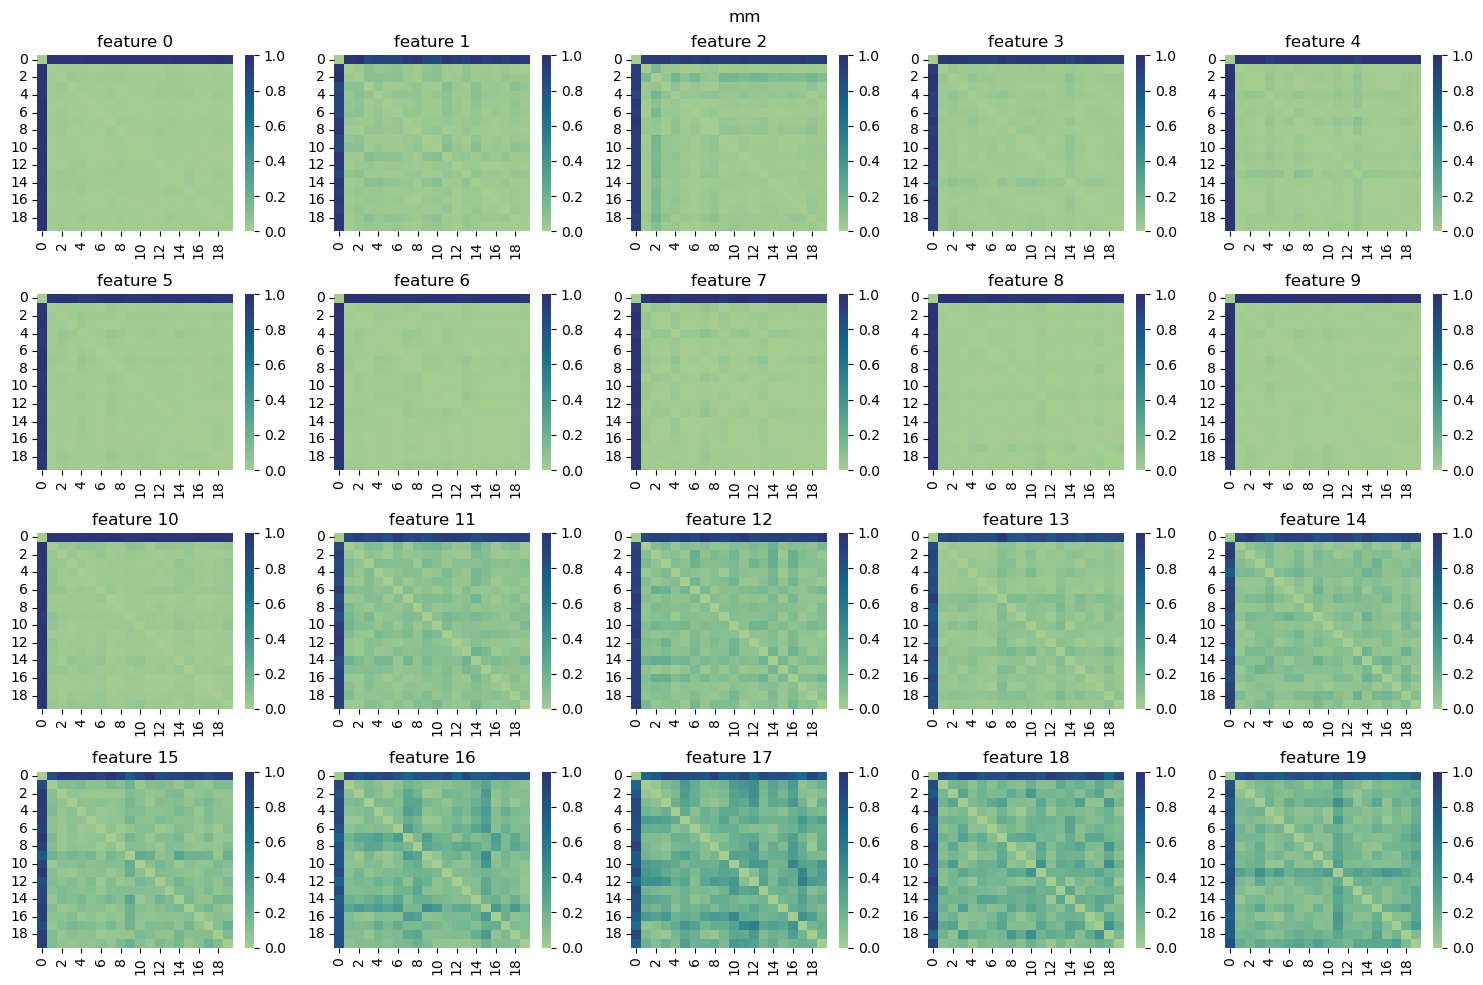

In [819]:
vis_local_model_sim(tracker2, iteration = 20, model='mm')

##### Ours

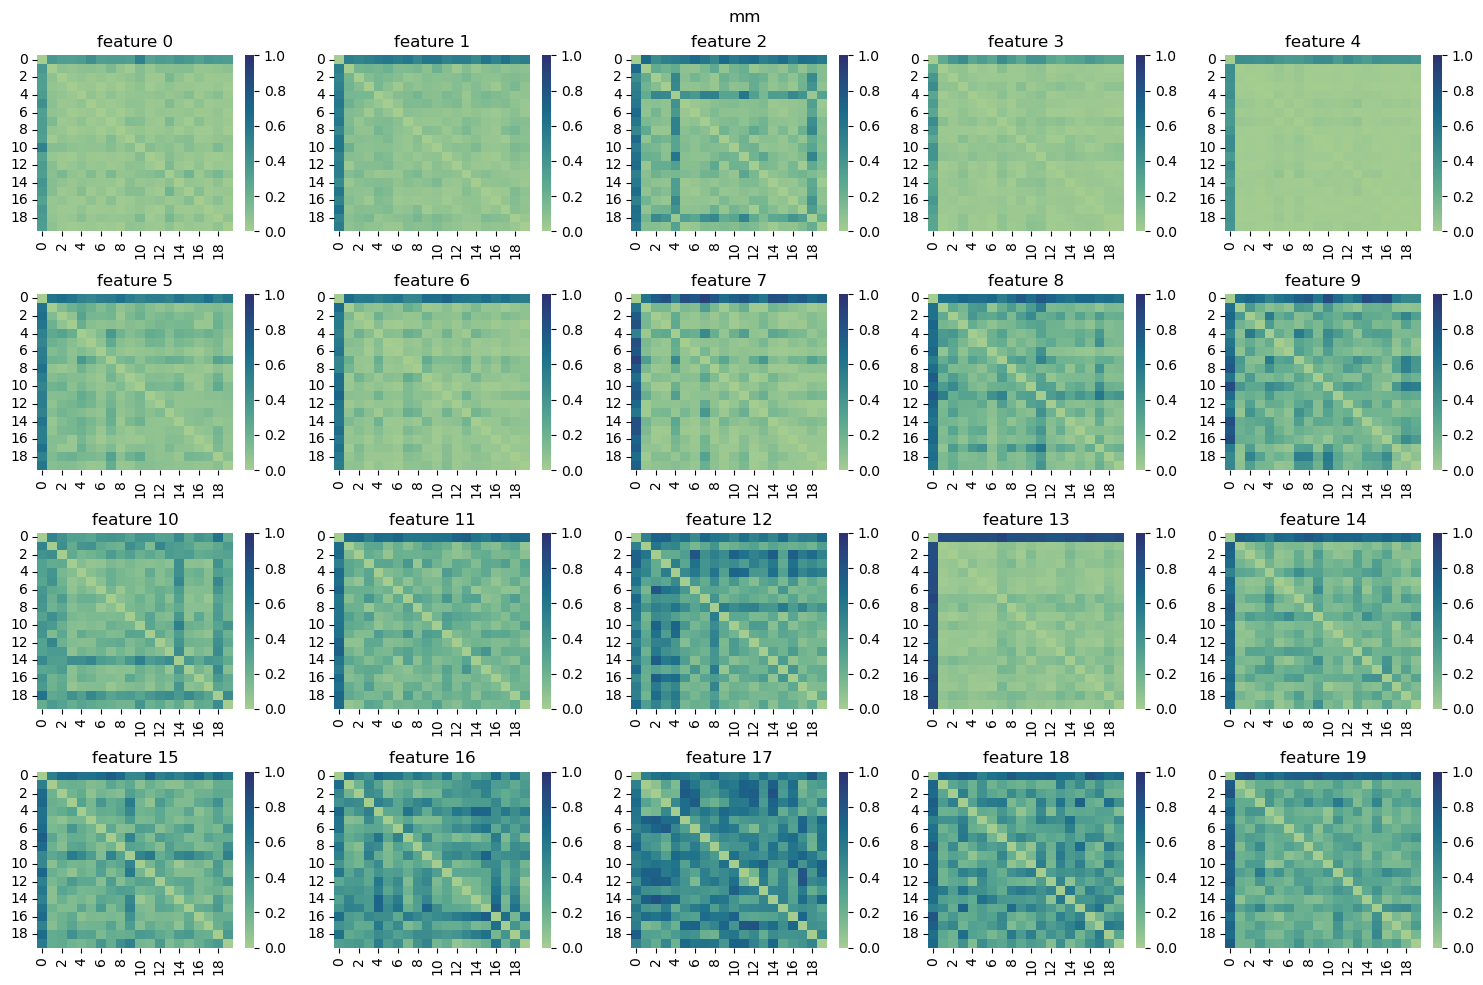

In [820]:
vis_local_model_sim(tracker3, iteration = 1, model='mm')

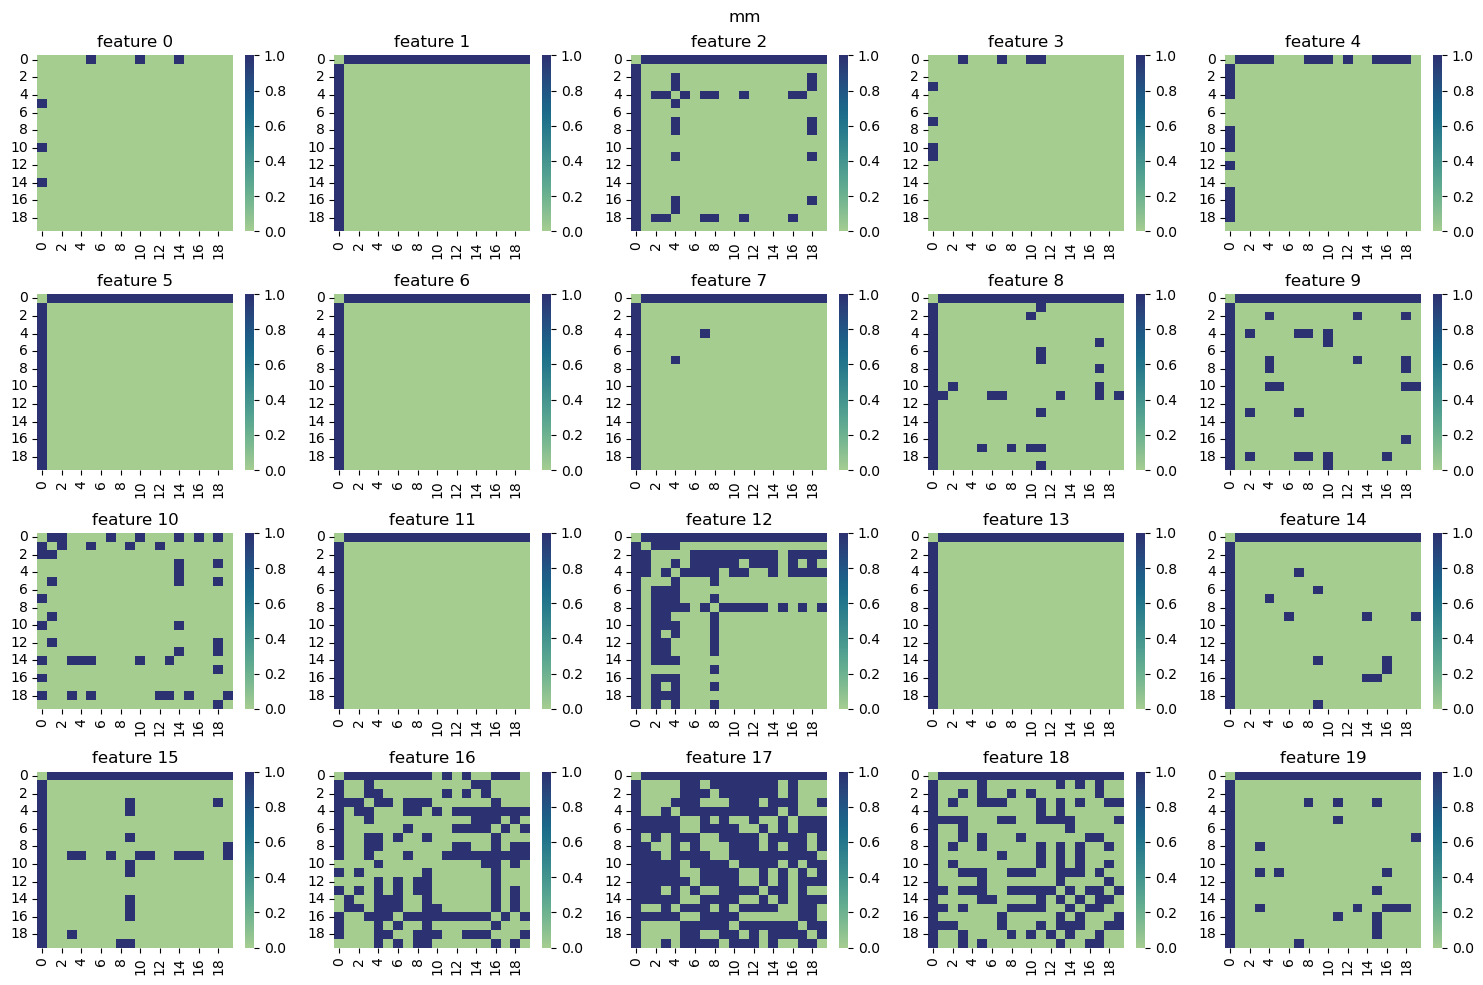

In [821]:
vis_local_model_sim_t(tracker3, iteration = 1, model='mm')

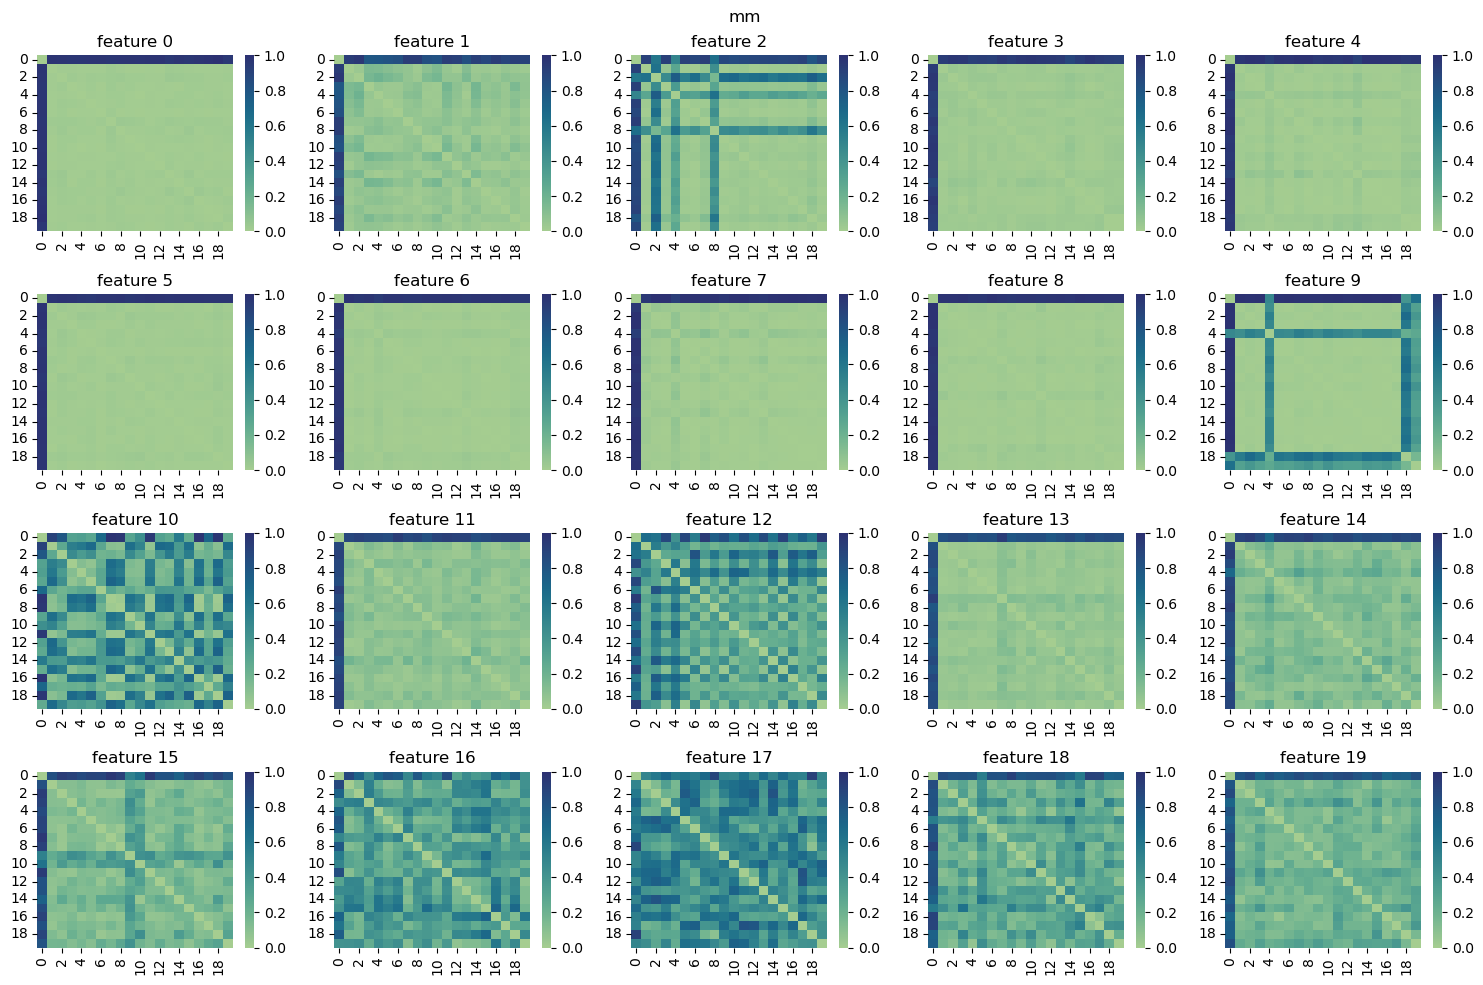

In [822]:
vis_local_model_sim(tracker3, iteration = 2, model='mm')

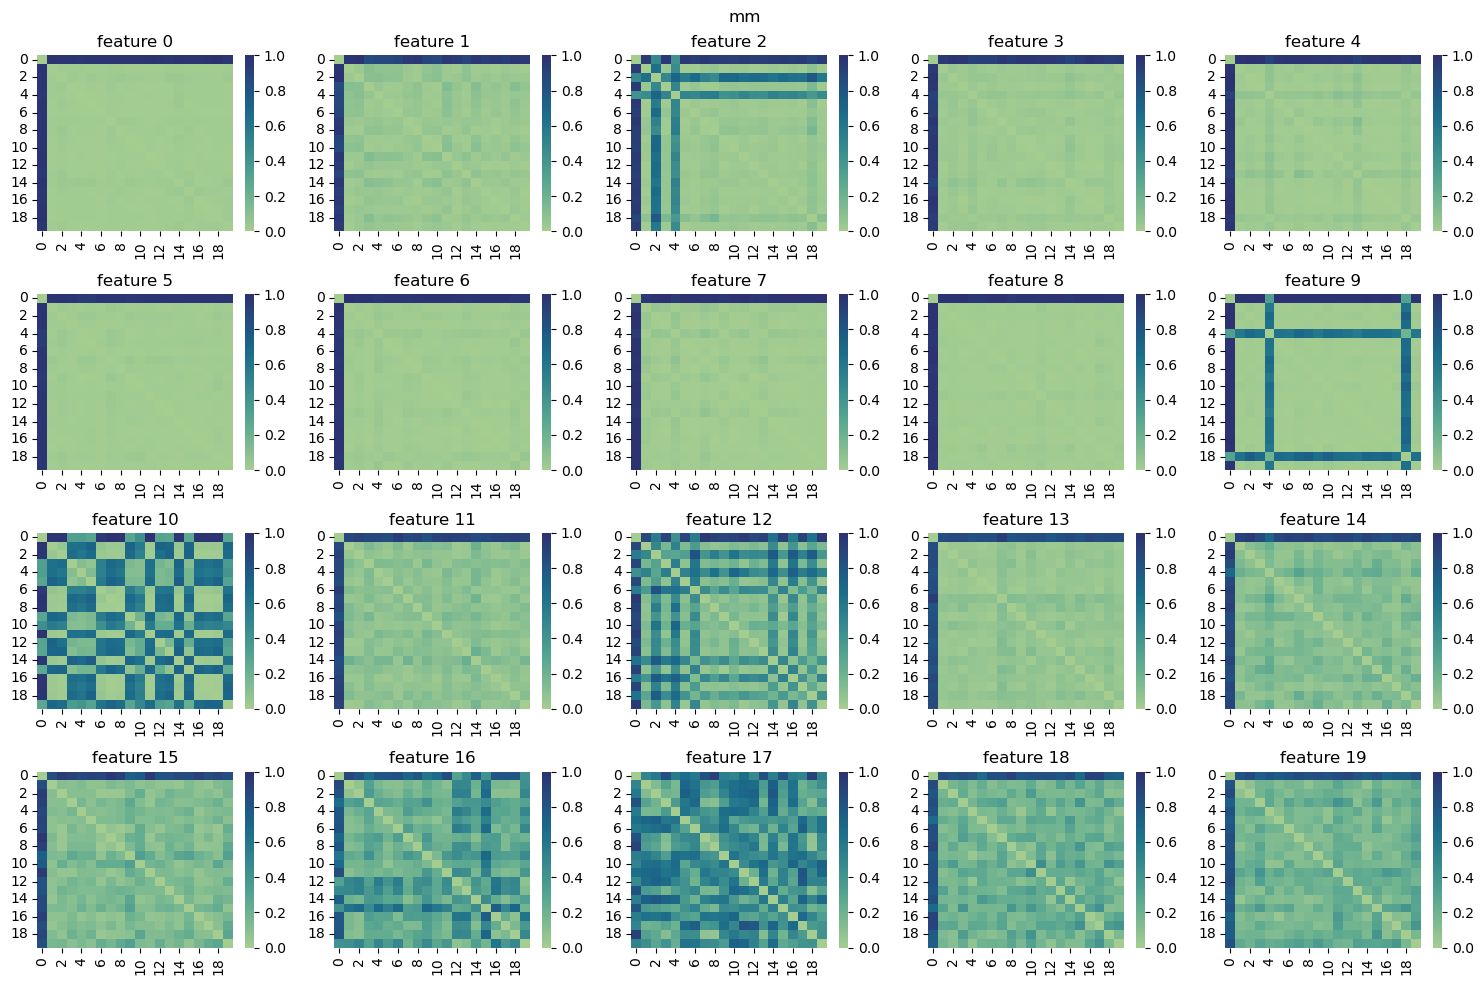

In [823]:
vis_local_model_sim(tracker3, iteration = 20, model='mm')

### MARY

In [824]:
trackery0 = trackers['mary_sigmoid_lr_local']
trackery1 = trackers['mary_sigmoid_lr_simpleavg']
trackery2 = trackers['mary_sigmoid_lr_complementary']
trackery3 = trackers['mary_sigmoid_lr_fedmechw']

#### Local

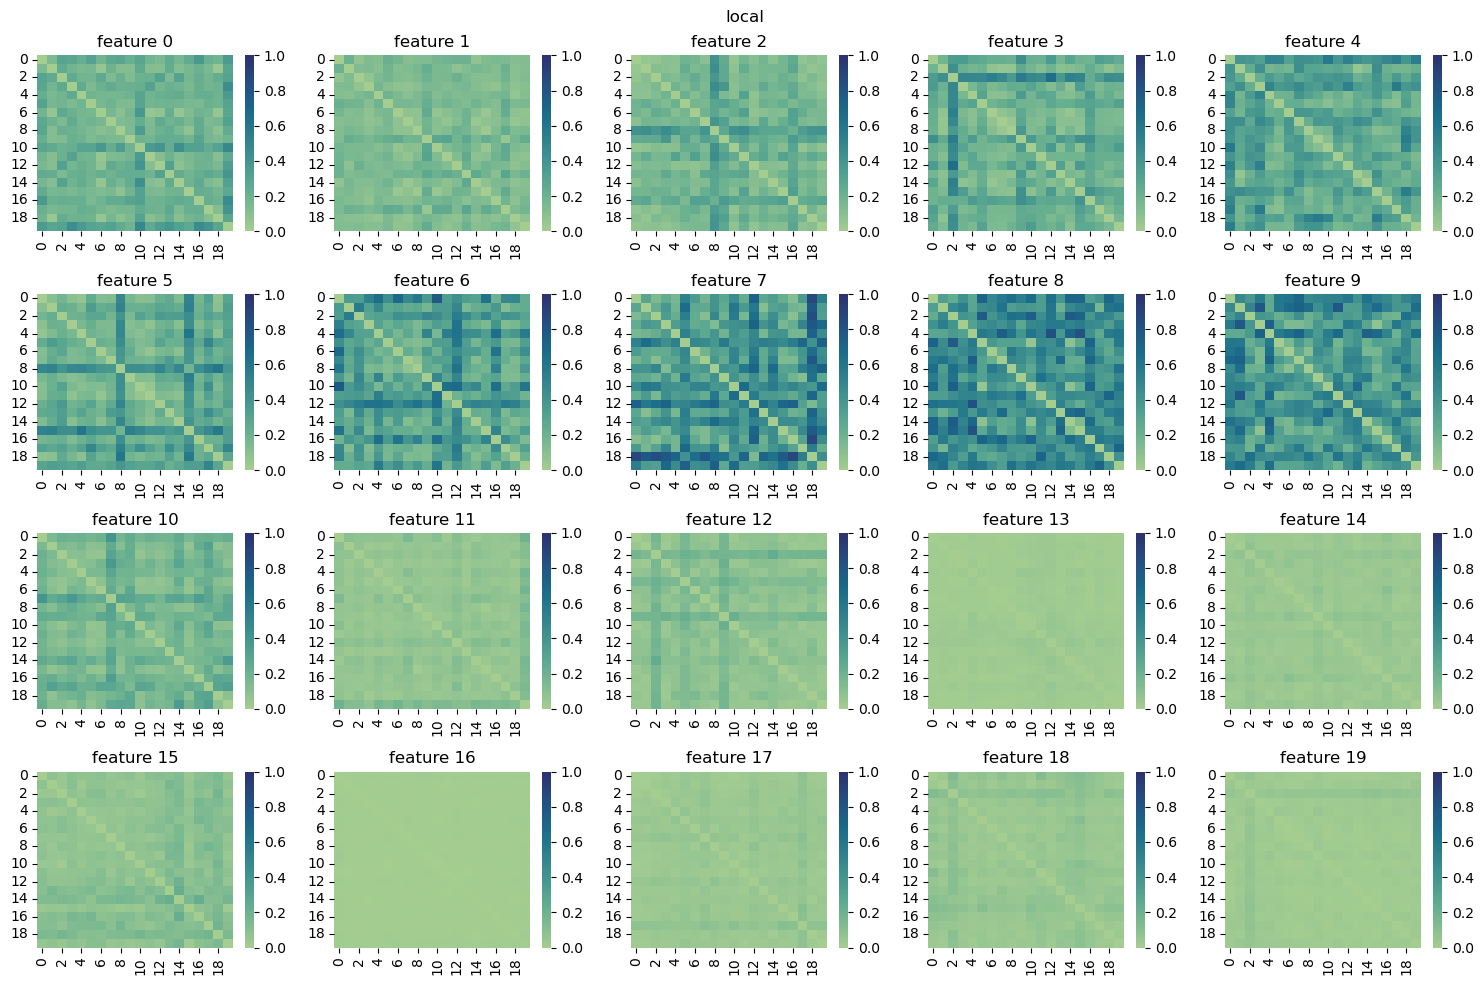

In [825]:
vis_local_model_sim(trackery0, iteration = 1, model='local')

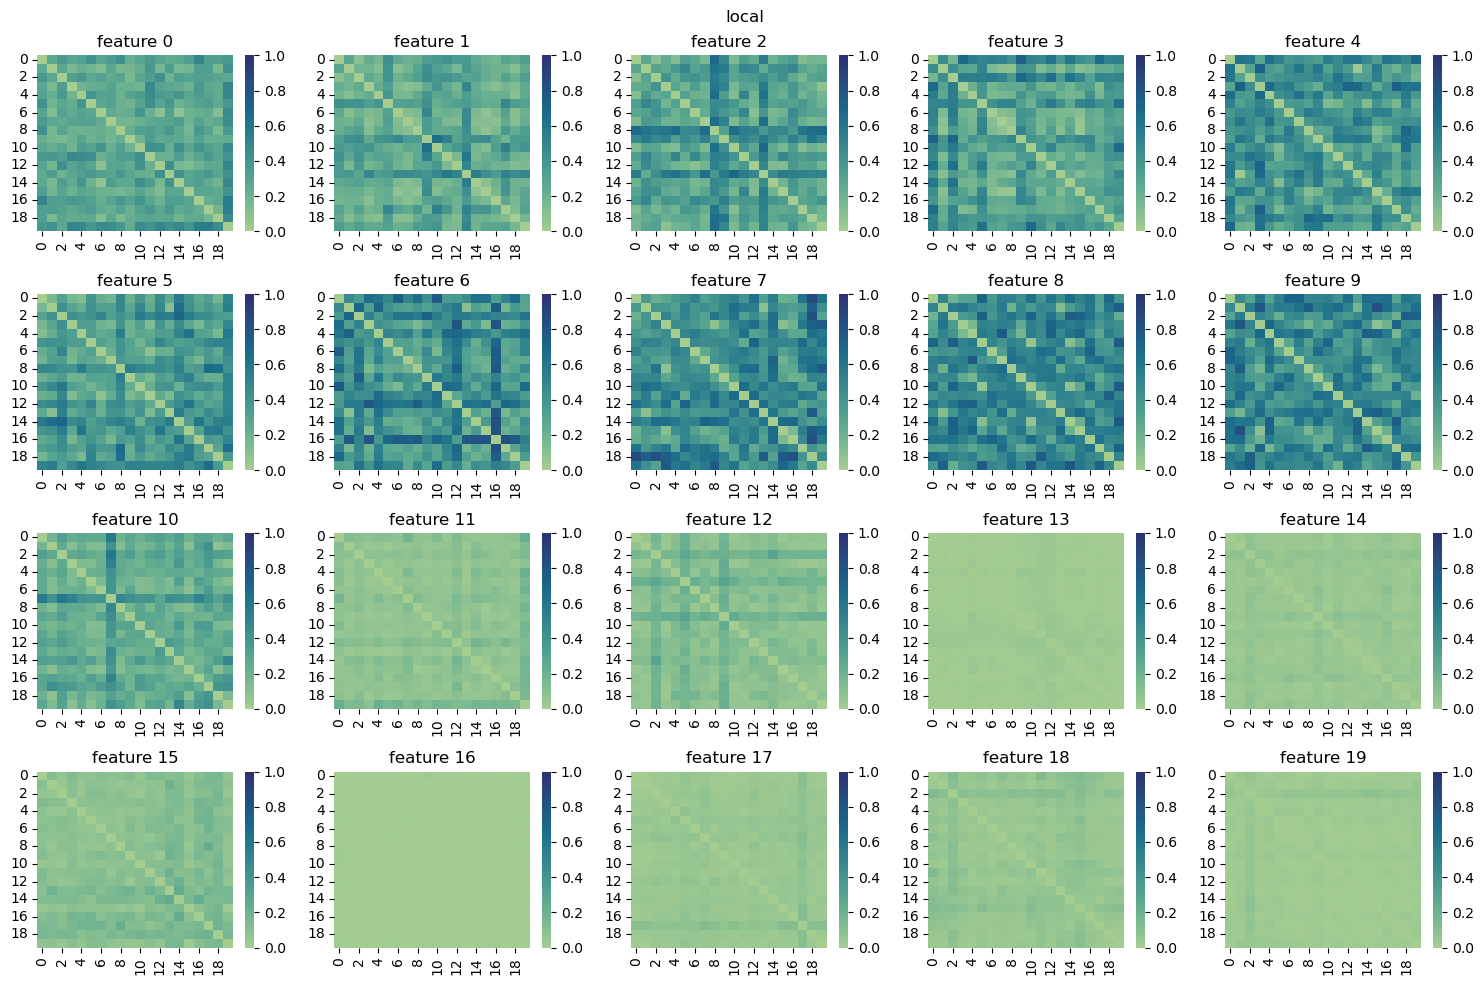

In [826]:
vis_local_model_sim(trackery0, iteration = 20, model='local')

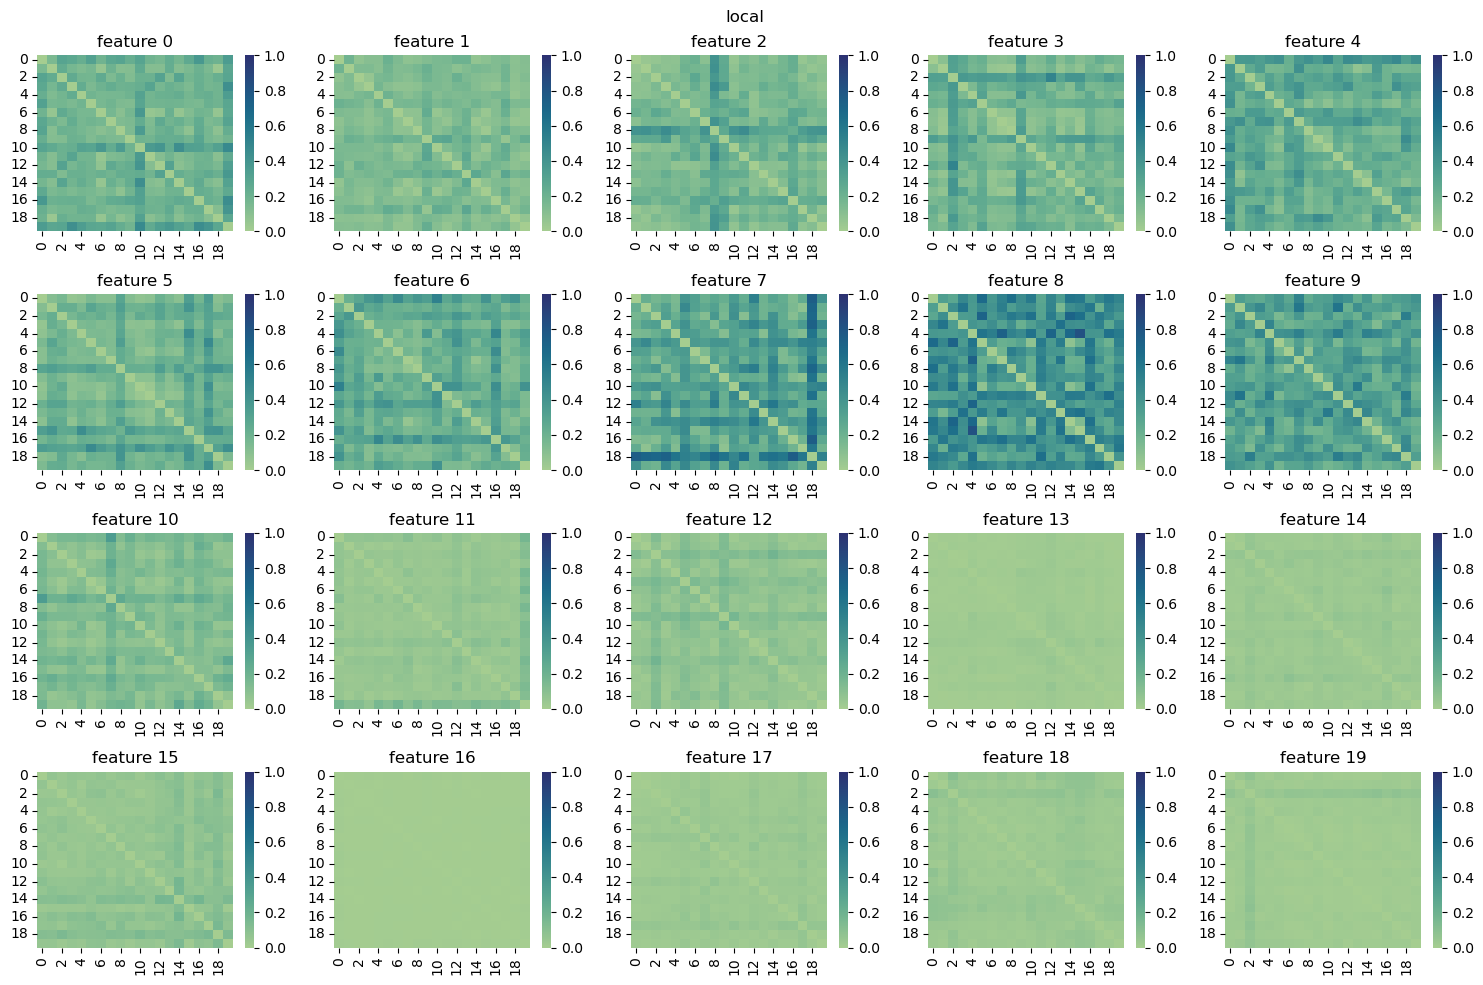

In [827]:
vis_local_model_sim(trackery1, iteration = 1, model='local')

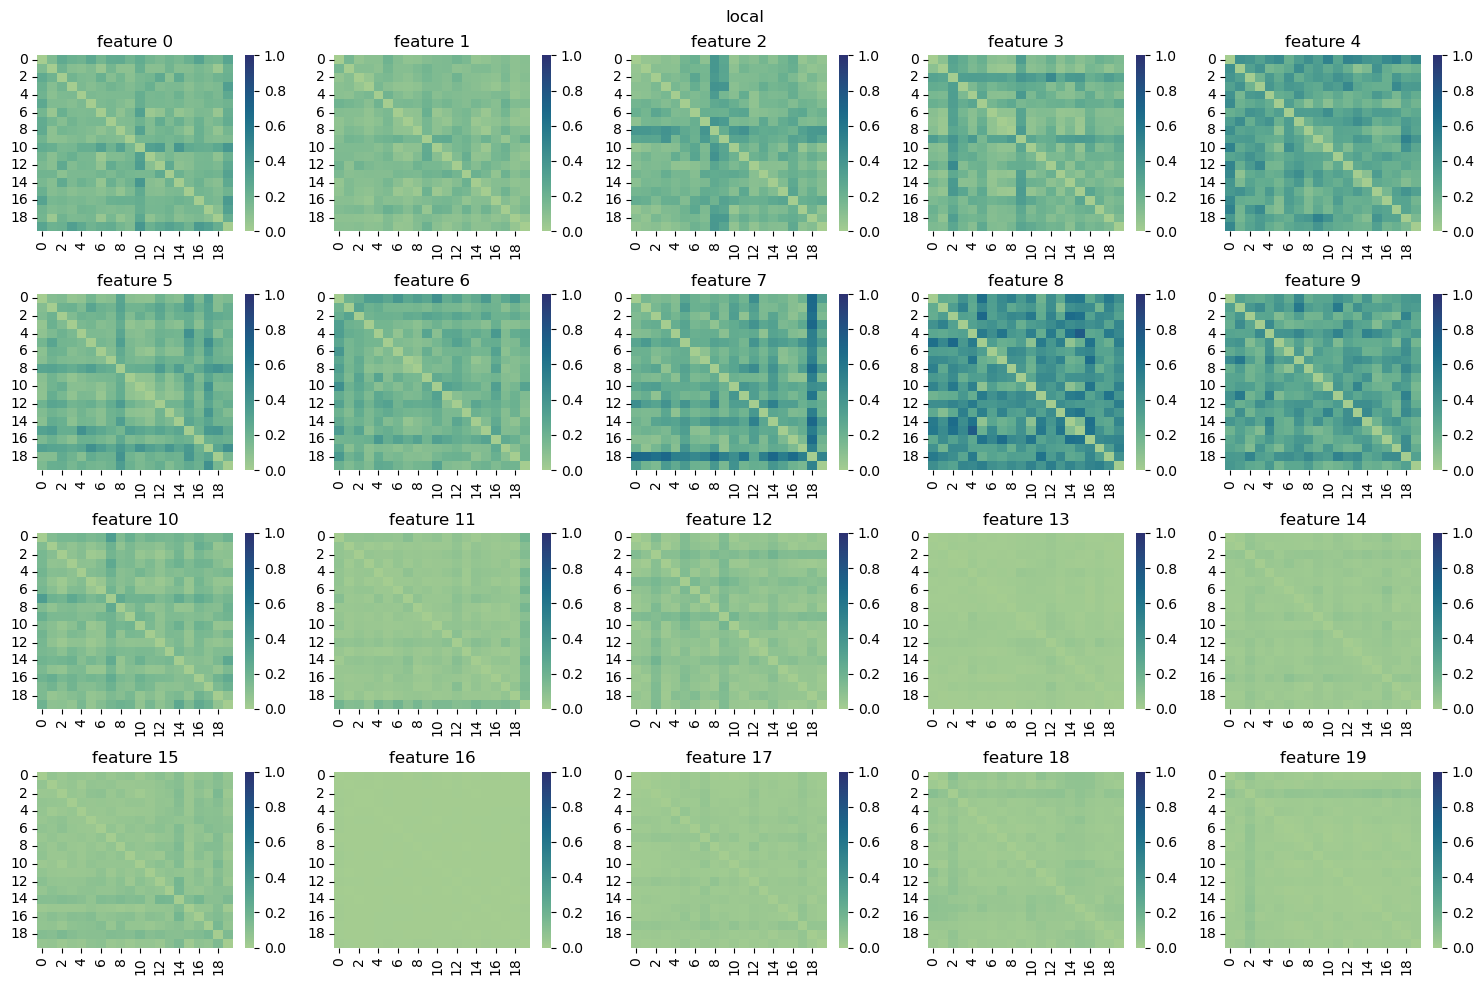

In [828]:
vis_local_model_sim(trackery1, iteration = 20, model='local')

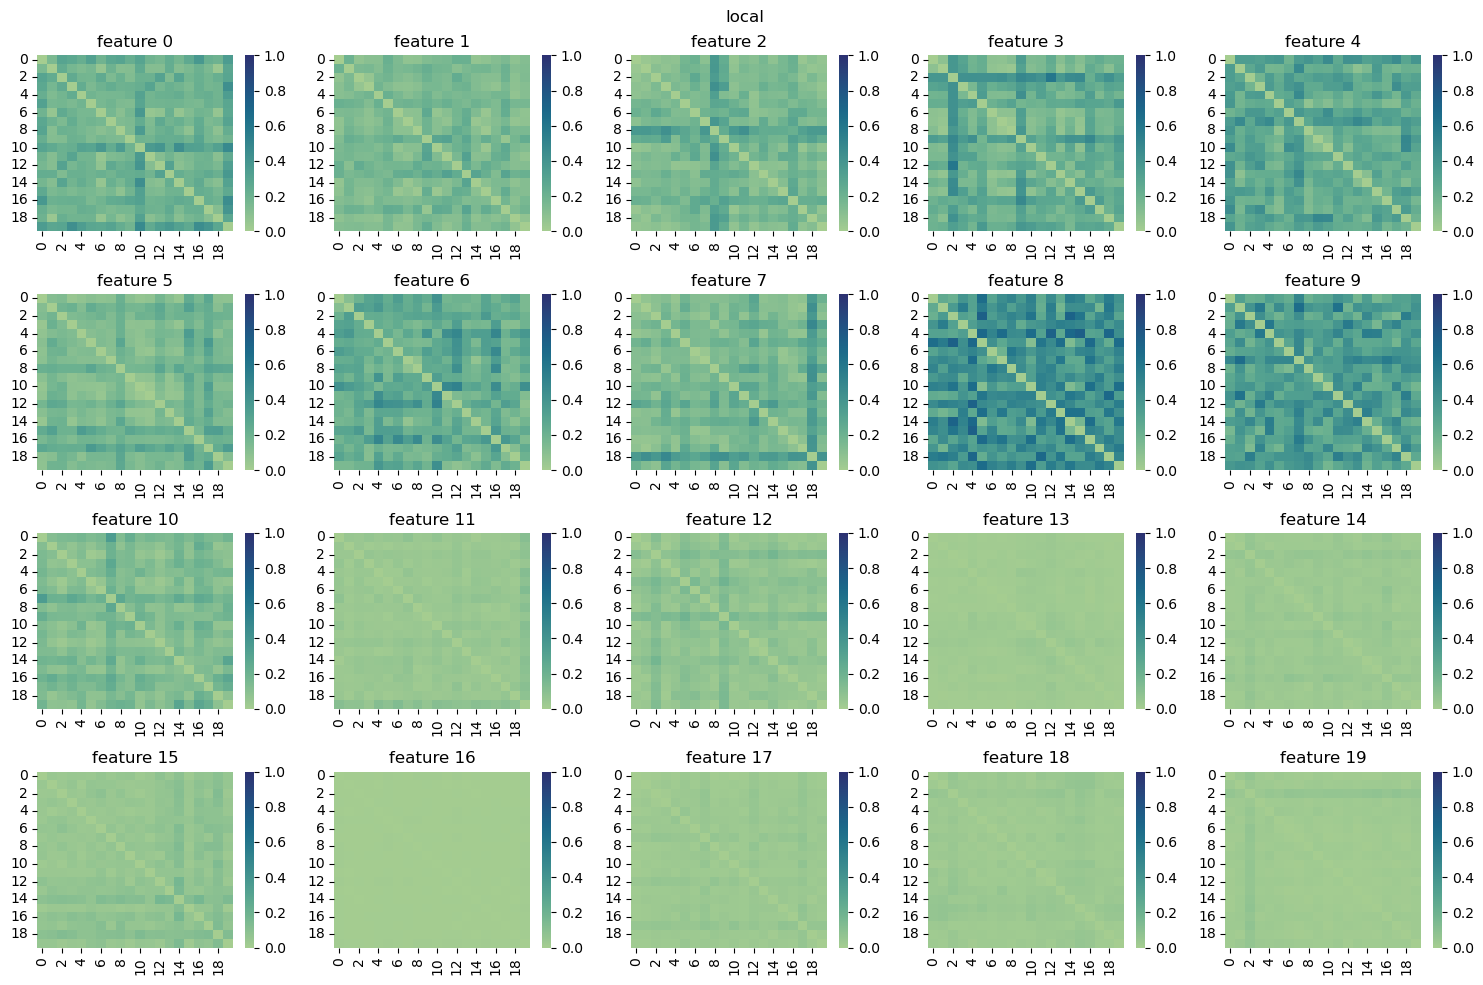

In [829]:
vis_local_model_sim(trackery2, iteration = 1, model='local')

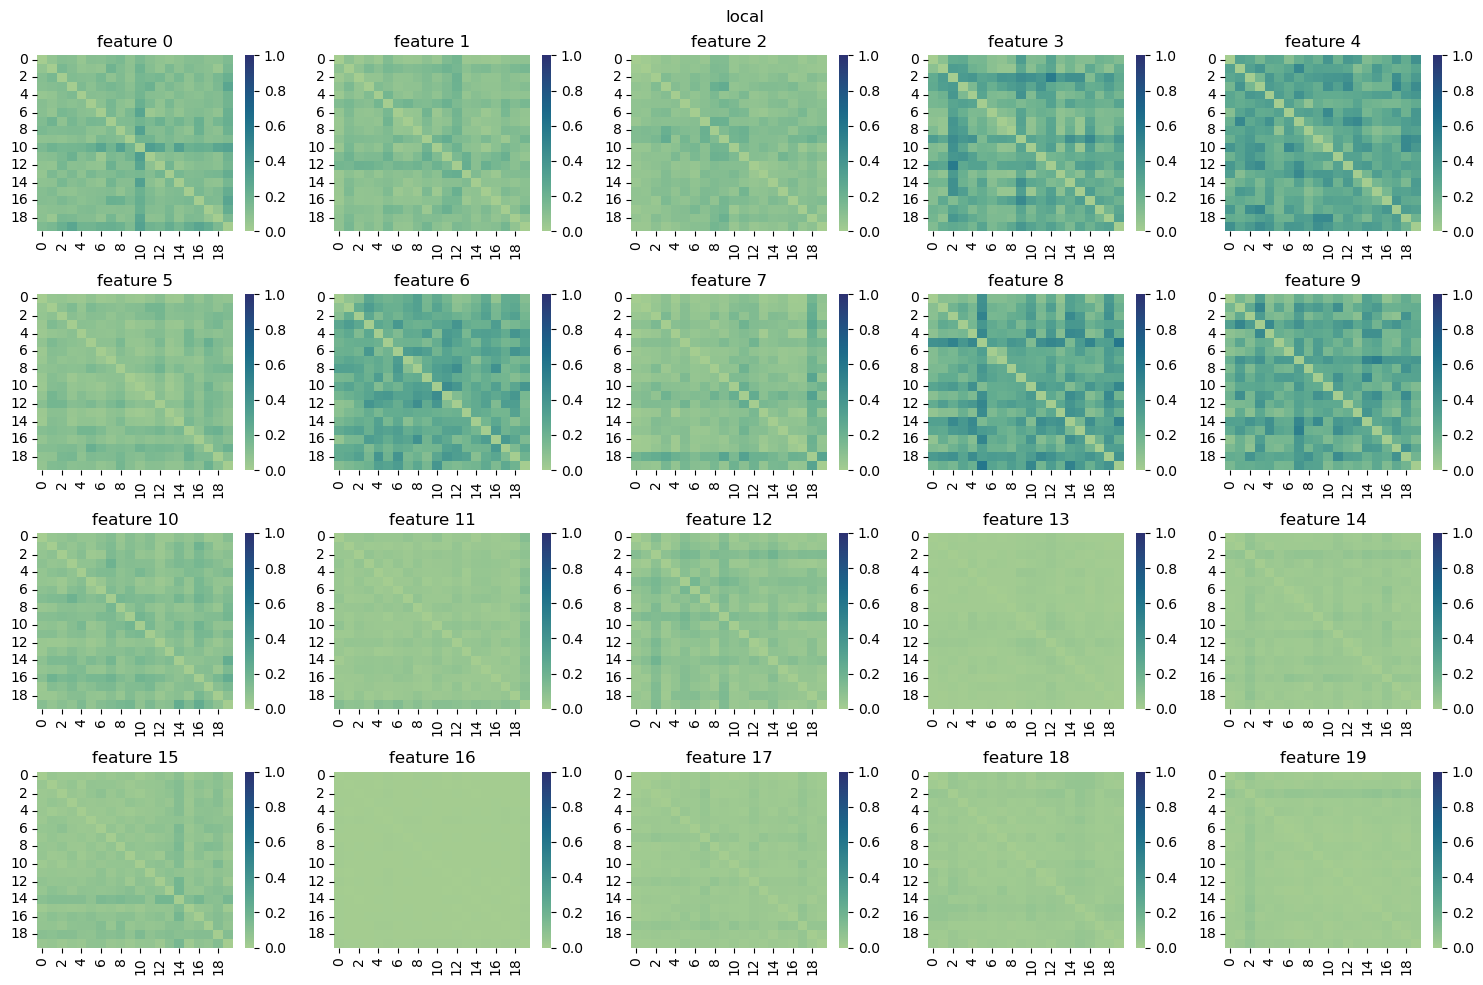

In [830]:
vis_local_model_sim(trackery2, iteration = 20, model='local')

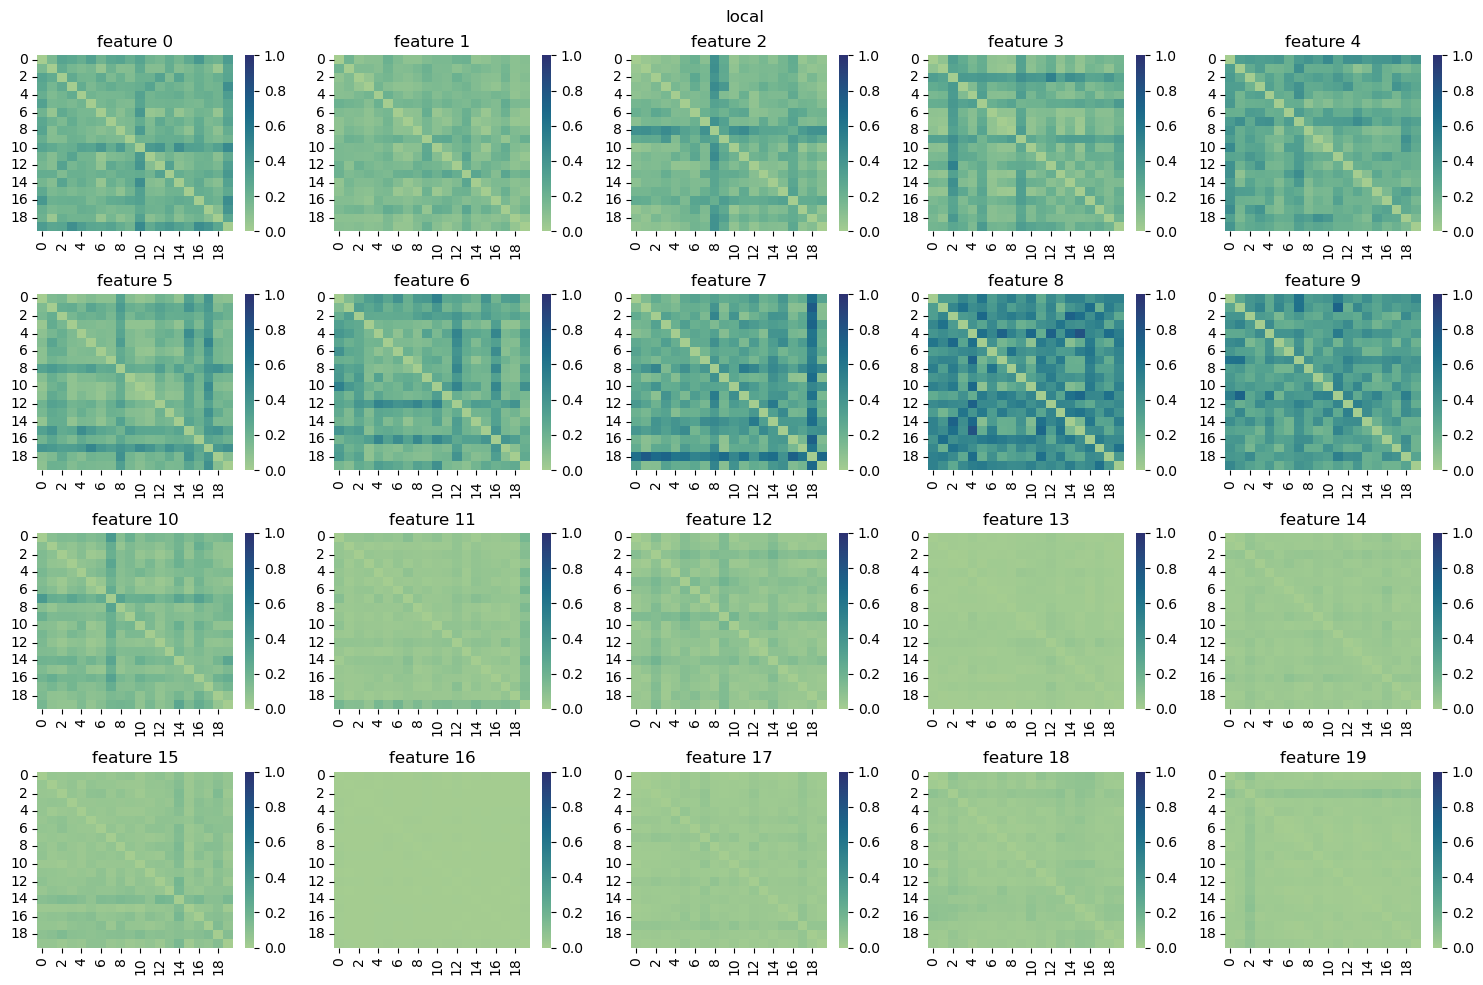

In [831]:
vis_local_model_sim(trackery3, iteration = 1, model='local')

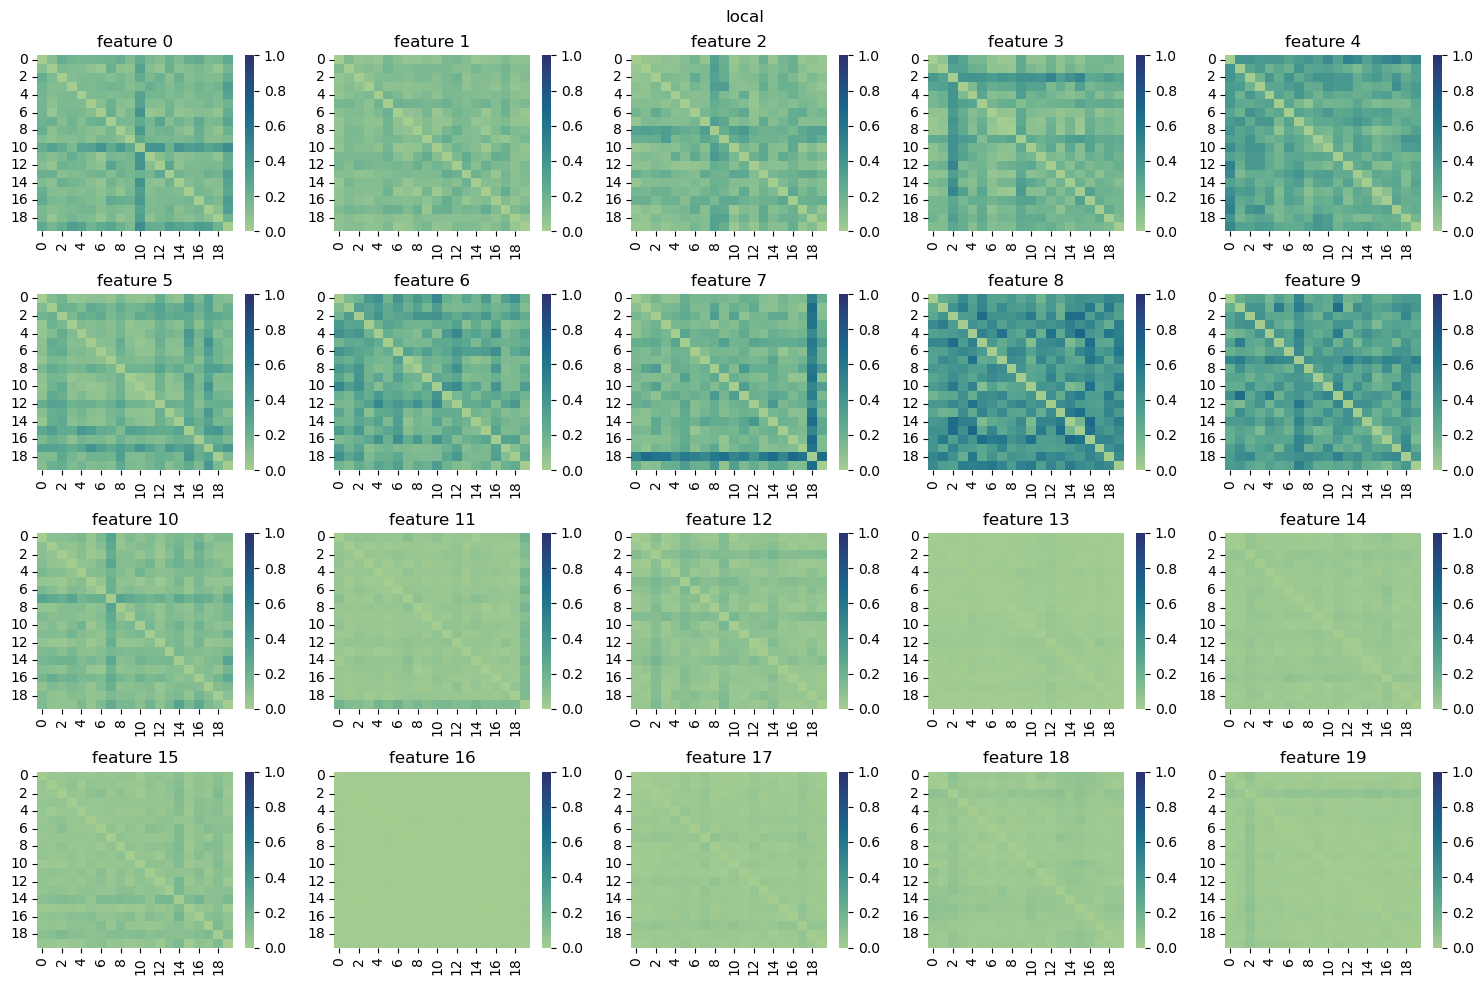

In [832]:
vis_local_model_sim(trackery3, iteration = 20, model='local')

#### Mechanism

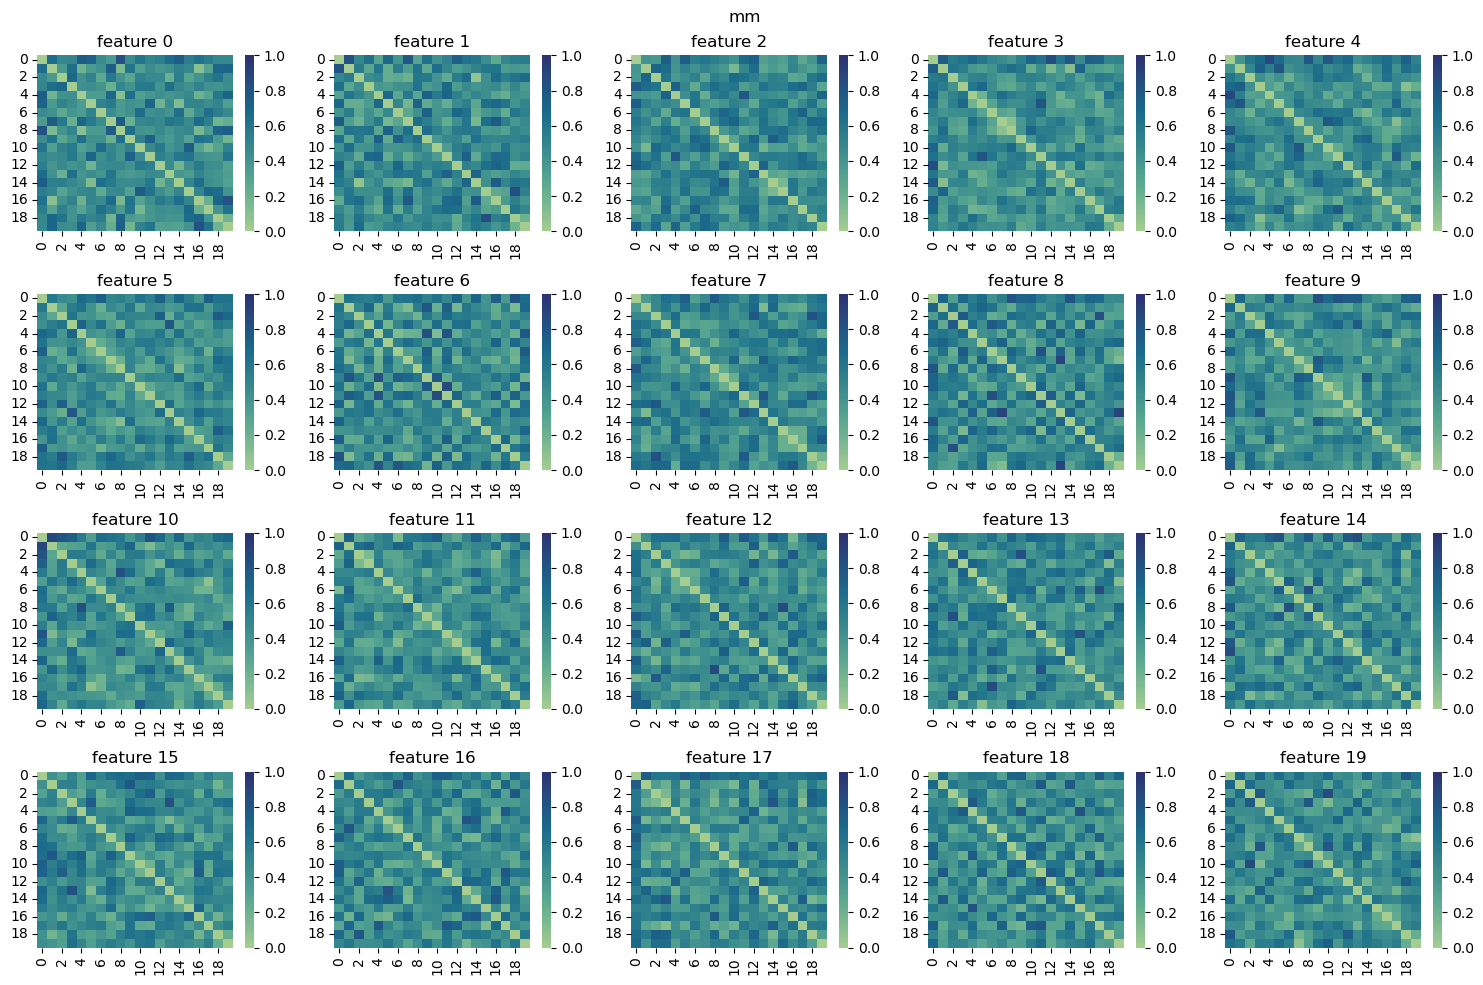

In [833]:
vis_local_model_sim(trackery1, iteration = 1, model='mm')

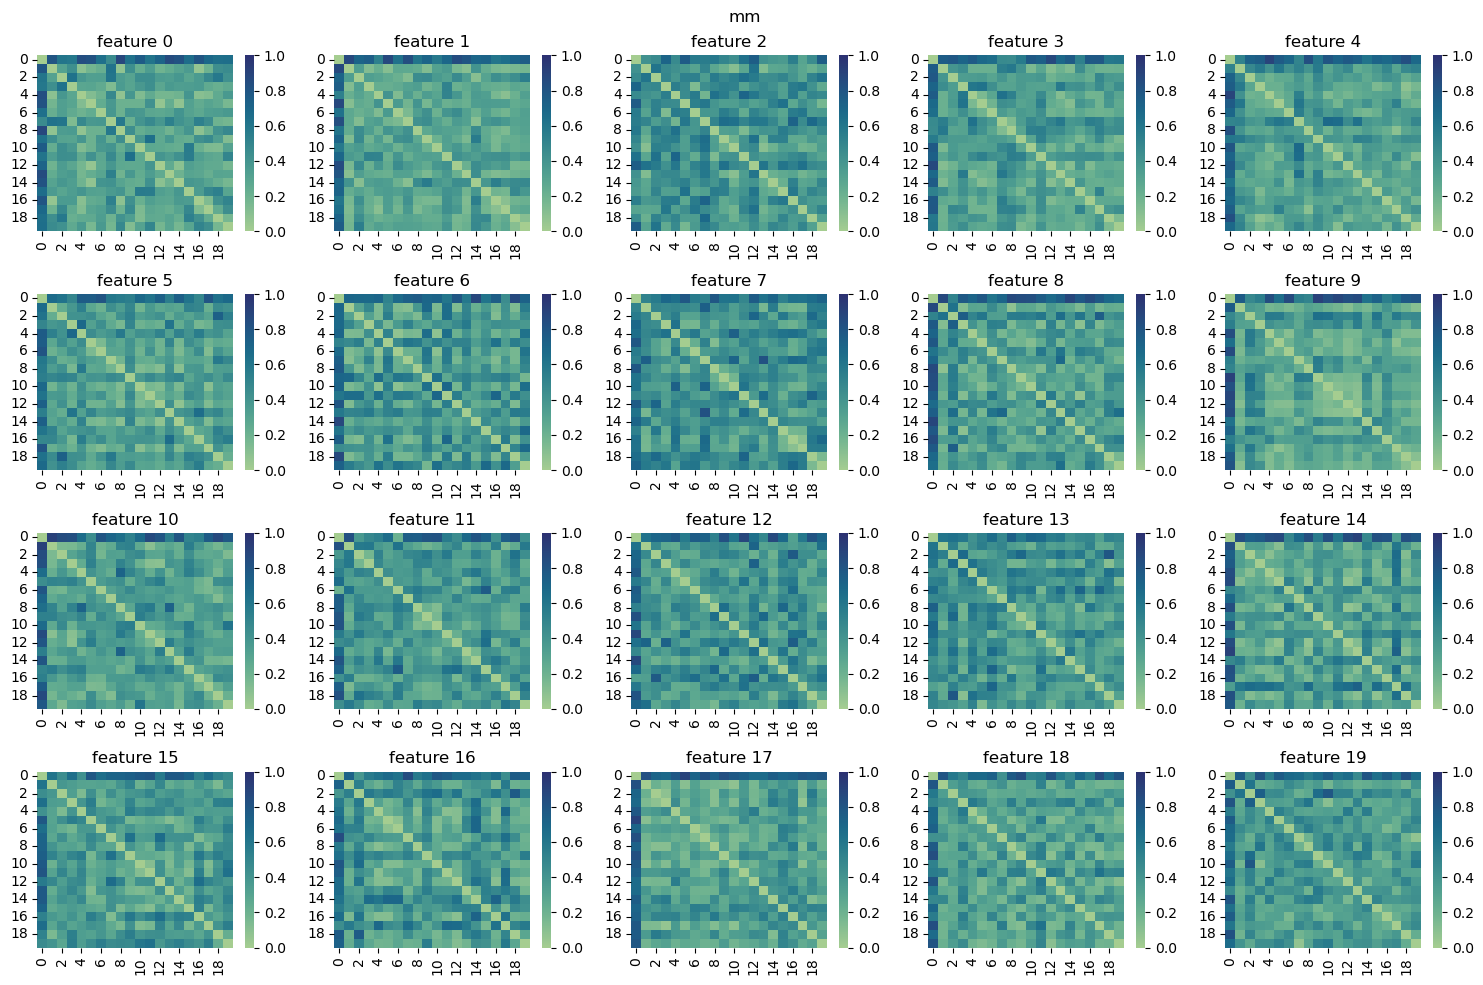

In [835]:
vis_local_model_sim(trackery2, iteration = 20, model='mm')

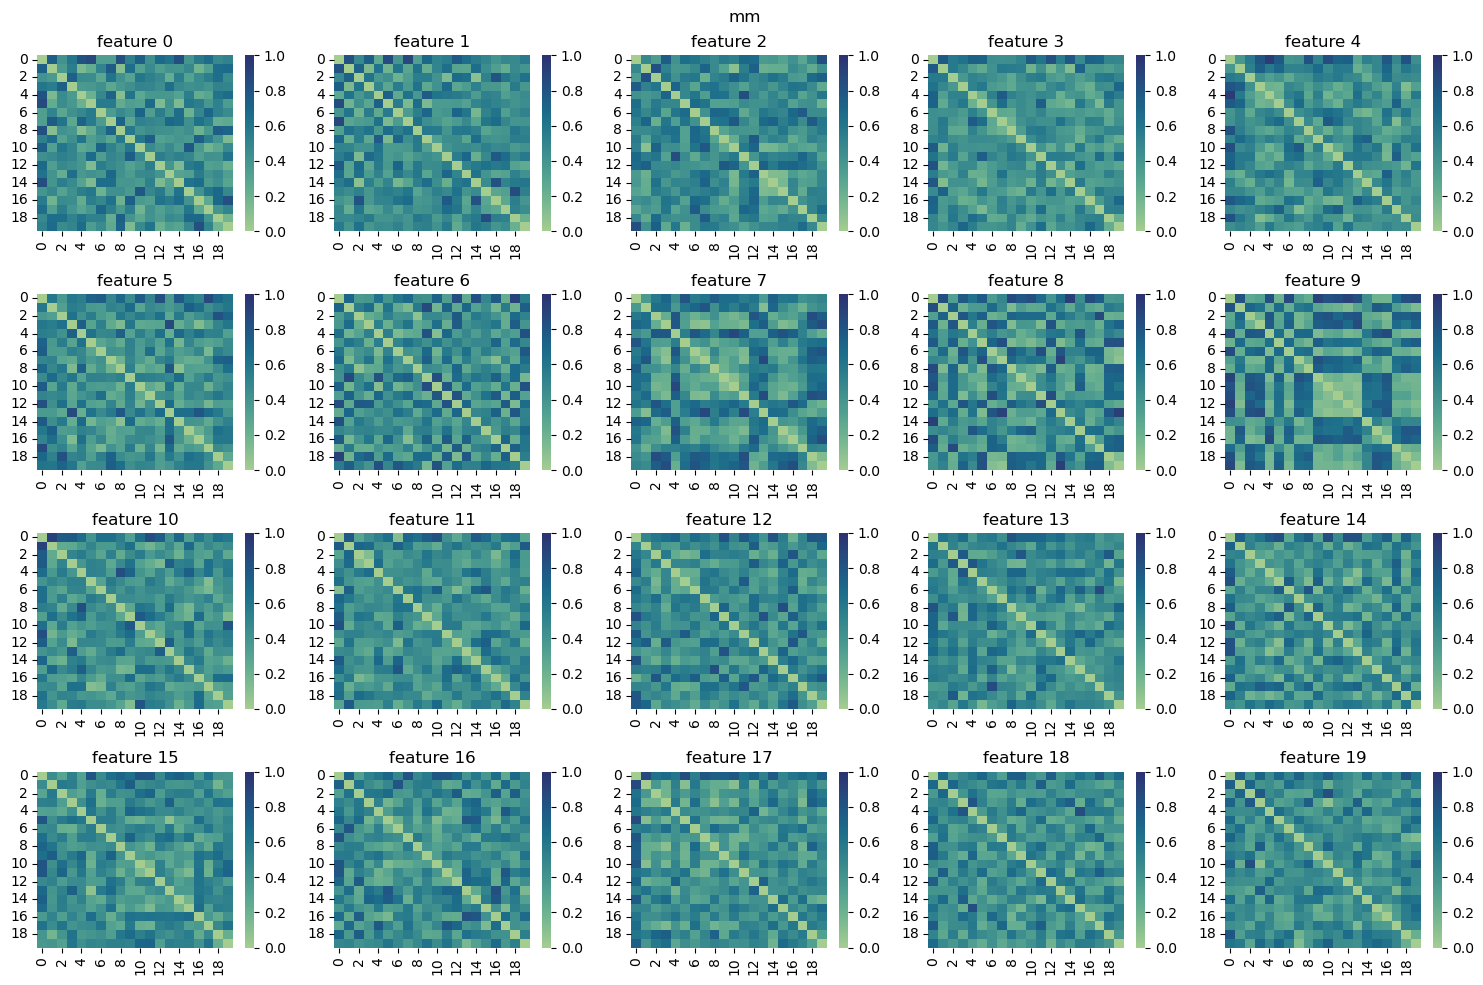

In [834]:
vis_local_model_sim(trackery3, iteration = 20, model='mm')